In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [ ]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-08-09',
    'expnum' :         list(n.arange(1,11)),}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21]),
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 6,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : True,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : False,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 3)

In [6]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 4
job.params['init_n_frames'] = None
job.params['init_file_sample_method'] = 'even'
job.params['voxel_size_um'] = (20, 2.5, 2.5)

In [7]:
# # %%time
# summary = job.run_init_pass()

In [8]:
summary = job.load_summary()

In [20]:
job.params['3d_reg'] = False
job.params['gpu_reg']= True
job.params['lbm']= True

In [21]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

job.register()

      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/registered_fused_data
   Updated main params file
   Starting registration: 3D: False, GPU: True
   Overriding fuse shift value to 6
Will analyze 531 tifs in 531 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 025.593 GB, Virtual Available: 477.602 GB, Virtual Used: 025.593 GB, Swap Used: 000.000 GB
Loading Batch 0 of 530
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00001.tif
    Loaded file into shared memory in 64.28 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.12 sec
    Total time: 66.41 sec
   Loaded 1 files, total 3.22 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 028.815 GB, Virtual Available: 474.381 GB, Virtual Used: 028.815 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 032.040 GB, Virtual Available: 471.156 GB, Virtual Used: 032.040 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 023.581 GB, Virtual Available: 479.615 GB, Virtual Used: 023.581 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 023.581 GB, Virtual Available: 479.615 GB, Virtual Used: 023.581 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00002.tif
         Registered batch in 0.08 sec
         Shifted batch in 0.16 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.73 sec
    Total time: 59.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 039.033 GB, Virtual Available: 464.162 GB, Virtual Used: 039.033 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.036 GB, Virtual Available: 464.159 GB, Virtual Used: 039.036 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 035.814 GB, Virtual Available: 467.382 GB, Virtual Used: 035.814 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 035.813 GB, Virtual Available: 467.382 GB, Virtual Used: 035.813 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.76 sec
    Total time: 55.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 039.105 GB, Virtual Available: 464.091 GB, Virtual Used: 039.105 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.105 GB, Virtual Available: 464.091 GB, Virtual Used: 039.105 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 035.876 GB, Virtual Available: 467.320 GB, Virtual Used: 035.876 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 035.876 GB, Virtual Available: 467.320 GB, Virtual Used: 035.876 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.80 sec
    Total time: 56.29 sec
   Loaded 1 files, total 3.22 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 039.163 GB, Virtual Available: 464.032 GB, Virtual Used: 039.163 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.166 GB, Virtual Available: 464.029 GB, Virtual Used: 039.166 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 035.943 GB, Virtual Available: 467.252 GB, Virtual Used: 035.943 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 035.942 GB, Virtual Available: 467.253 GB, Virtual Used: 035.942 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.94 sec
    Total time: 64.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 039.521 GB, Virtual Available: 463.675 GB, Virtual Used: 039.521 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.518 GB, Virtual Available: 463.678 GB, Virtual Used: 039.518 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 036.297 GB, Virtual Available: 466.899 GB, Virtual Used: 036.297 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00006.tif
         After IO thread launch:Total Used: 036.297 GB, Virtual Available: 466.899 GB, Virtual Used: 036.297 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.99 sec
    Total time: 56.30 sec
   Loaded 1 files, total 3.22 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 039.563 GB, Virtual Available: 463.633 GB, Virtual Used: 039.563 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.564 GB, Virtual Available: 463.632 GB, Virtual Used: 039.564 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 036.339 GB, Virtual Available: 466.857 GB, Virtual Used: 036.339 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00007.tif
         After IO thread launch:Total Used: 036.339 GB, Virtual Available: 466.857 GB, Virtual Used: 036.339 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.91 sec
    Total time: 60.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 039.638 GB, Virtual Available: 463.557 GB, Virtual Used: 039.638 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.640 GB, Virtual Available: 463.556 GB, Virtual Used: 039.640 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 036.419 GB, Virtual Available: 466.777 GB, Virtual Used: 036.419 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.419 GB, Virtual Available: 466.776 GB, Virtual Used: 036.419 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.88 sec
    Total time: 82.87 sec
   Loaded 1 files, total 3.22 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 039.985 GB, Virtual Available: 463.211 GB, Virtual Used: 039.985 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.987 GB, Virtual Available: 463.208 GB, Virtual Used: 039.987 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 036.756 GB, Virtual Available: 466.439 GB, Virtual Used: 036.756 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00009.tif
         After IO thread launch:Total Used: 036.756 GB, Virtual Available: 466.439 GB, Virtual Used: 036.756 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.09 sec
    Total time: 119.01 sec
   Loaded 1 files, total 3.22 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 039.798 GB, Virtual Available: 463.398 GB, Virtual Used: 039.798 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.797 GB, Virtual Available: 463.400 GB, Virtual Used: 039.796 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 036.574 GB, Virtual Available: 466.623 GB, Virtual Used: 036.573 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.574 GB, Virtual Available: 466.623 GB, Virtual Used: 036.573 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.24 sec
    Total time: 111.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 039.972 GB, Virtual Available: 463.225 GB, Virtual Used: 039.971 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.960 GB, Virtual Available: 463.236 GB, Virtual Used: 039.959 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 036.739 GB, Virtual Available: 466.457 GB, Virtual Used: 036.739 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00011.tif
         After IO thread launch:Total Used: 036.740 GB, Virtual Available: 466.456 GB, Virtual Used: 036.739 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.93 sec
    Total time: 107.07 sec
   Loaded 1 files, total 3.22 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 039.681 GB, Virtual Available: 463.515 GB, Virtual Used: 039.680 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 039.683 GB, Virtual Available: 463.513 GB, Virtual Used: 039.683 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 036.464 GB, Virtual Available: 466.732 GB, Virtual Used: 036.464 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.465 GB, Virtual Available: 466.731 GB, Virtual Used: 036.464 GB, Swap Used: 000.000 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.01 sec
    Total time: 104.46 sec
   Loaded 1 files, total 3.22 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 039.649 GB, Virtual Available: 463.547 GB, Virtual Used: 039.648 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.644 GB, Virtual Available: 463.553 GB, Virtual Used: 039.643 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.422 GB, Virtual Available: 466.775 GB, Virtual Used: 036.421 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.421 GB, Virtual Available: 466.776 GB, Virtual Used: 036.420 GB, Swap Used: 000.001 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00013.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.87 sec
    Total time: 76.46 sec
   Loaded 1 files, total 3.22 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 039.712 GB, Virtual Available: 463.485 GB, Virtual Used: 039.711 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.708 GB, Virtual Available: 463.488 GB, Virtual Used: 039.707 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.490 GB, Virtual Available: 466.707 GB, Virtual Used: 036.489 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.489 GB, Virtual Available: 466.707 GB, Virtual Used: 036.488 GB, Swap Used: 000.001 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00014.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.98 sec
    Total time: 78.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 039.731 GB, Virtual Available: 463.465 GB, Virtual Used: 039.730 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.732 GB, Virtual Available: 463.464 GB, Virtual Used: 039.731 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.507 GB, Virtual Available: 466.689 GB, Virtual Used: 036.507 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.507 GB, Virtual Available: 466.689 GB, Virtual Used: 036.507 GB, Swap Used: 000.001 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.97 sec
    Total time: 79.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 039.560 GB, Virtual Available: 463.637 GB, Virtual Used: 039.558 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.572 GB, Virtual Available: 463.625 GB, Virtual Used: 039.571 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.349 GB, Virtual Available: 466.849 GB, Virtual Used: 036.347 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00016.tif
         After IO thread launch:Total Used: 036.348 GB, Virtual Available: 466.849 GB, Virtual Used: 036.347 GB, Swap Used: 000.001 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.22 sec
    Total time: 74.75 sec
   Loaded 1 files, total 3.22 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 039.684 GB, Virtual Available: 463.513 GB, Virtual Used: 039.682 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.685 GB, Virtual Available: 463.512 GB, Virtual Used: 039.683 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.463 GB, Virtual Available: 466.734 GB, Virtual Used: 036.461 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.463 GB, Virtual Available: 466.734 GB, Virtual Used: 036.462 GB, Swap Used: 000.001 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00017.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.08 sec
    Total time: 75.01 sec
   Loaded 1 files, total 3.22 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 039.655 GB, Virtual Available: 463.542 GB, Virtual Used: 039.654 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.664 GB, Virtual Available: 463.533 GB, Virtual Used: 039.663 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.434 GB, Virtual Available: 466.763 GB, Virtual Used: 036.433 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.434 GB, Virtual Available: 466.763 GB, Virtual Used: 036.433 GB, Swap Used: 000.001 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00018.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.92 sec
    Total time: 73.86 sec
   Loaded 1 files, total 3.22 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 039.697 GB, Virtual Available: 463.500 GB, Virtual Used: 039.696 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.691 GB, Virtual Available: 463.506 GB, Virtual Used: 039.690 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.471 GB, Virtual Available: 466.727 GB, Virtual Used: 036.469 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.470 GB, Virtual Available: 466.727 GB, Virtual Used: 036.469 GB, Swap Used: 000.001 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00019.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.23 sec
    Total time: 79.00 sec
   Loaded 1 files, total 3.22 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 039.630 GB, Virtual Available: 463.567 GB, Virtual Used: 039.629 GB, Swap Used: 000.001 GB
         Memory after movie copied from threadTotal Used: 039.630 GB, Virtual Available: 463.567 GB, Virtual Used: 039.629 GB, Swap Used: 000.001 GB
         Memory after thread memory clearedTotal Used: 036.404 GB, Virtual Available: 466.793 GB, Virtual Used: 036.402 GB, Swap Used: 000.001 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00020.tif
         After IO thread launch:Total Used: 036.404 GB, Virtual Available: 466.793 GB, Virtual Used: 036.402 GB, Swap Used: 000.001 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 82.62 sec
   Loaded 1 files, total 3.22 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 039.711 GB, Virtual Available: 463.486 GB, Virtual Used: 039.709 GB, Swap Used: 000.002 GB
         Memory after movie copied from threadTotal Used: 039.708 GB, Virtual Available: 463.490 GB, Virtual Used: 039.706 GB, Swap Used: 000.002 GB
         Memory after thread memory clearedTotal Used: 036.490 GB, Virtual Available: 466.707 GB, Virtual Used: 036.488 GB, Swap Used: 000.002 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00021.tif
         After IO thread launch:Total Used: 036.490 GB, Virtual Available: 466.707 GB, Virtual Used: 036.488 GB, Swap Used: 000.002 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.05 sec
    Total time: 77.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 20 IO thread joined
         Memory after IO thread joinTotal Used: 039.748 GB, Virtual Available: 463.450 GB, Virtual Used: 039.746 GB, Swap Used: 000.002 GB
         Memory after movie copied from threadTotal Used: 039.754 GB, Virtual Available: 463.444 GB, Virtual Used: 039.752 GB, Swap Used: 000.002 GB
         Memory after thread memory clearedTotal Used: 036.531 GB, Virtual Available: 466.666 GB, Virtual Used: 036.529 GB, Swap Used: 000.002 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.532 GB, Virtual Available: 466.666 GB, Virtual Used: 036.529 GB, Swap Used: 000.002 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00022.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.17 sec
    Total time: 74.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 21 IO thread joined
         Memory after IO thread joinTotal Used: 039.613 GB, Virtual Available: 463.585 GB, Virtual Used: 039.610 GB, Swap Used: 000.003 GB
         Memory after movie copied from threadTotal Used: 039.617 GB, Virtual Available: 463.582 GB, Virtual Used: 039.614 GB, Swap Used: 000.003 GB
         Memory after thread memory clearedTotal Used: 036.393 GB, Virtual Available: 466.806 GB, Virtual Used: 036.390 GB, Swap Used: 000.003 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.393 GB, Virtual Available: 466.805 GB, Virtual Used: 036.391 GB, Swap Used: 000.003 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00023.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.23 sec
    Total time: 78.94 sec
   Loaded 1 files, total 3.22 GB
   Batch 22 IO thread joined
         Memory after IO thread joinTotal Used: 039.603 GB, Virtual Available: 463.596 GB, Virtual Used: 039.600 GB, Swap Used: 000.003 GB
         Memory after movie copied from threadTotal Used: 039.607 GB, Virtual Available: 463.591 GB, Virtual Used: 039.604 GB, Swap Used: 000.003 GB
         Memory after thread memory clearedTotal Used: 036.383 GB, Virtual Available: 466.815 GB, Virtual Used: 036.381 GB, Swap Used: 000.003 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.383 GB, Virtual Available: 466.815 GB, Virtual Used: 036.381 GB, Swap Used: 000.003 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00024.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.91 sec
    Total time: 79.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 23 IO thread joined
         Memory after IO thread joinTotal Used: 039.555 GB, Virtual Available: 463.643 GB, Virtual Used: 039.552 GB, Swap Used: 000.003 GB
         Memory after movie copied from threadTotal Used: 039.548 GB, Virtual Available: 463.650 GB, Virtual Used: 039.545 GB, Swap Used: 000.003 GB
         Memory after thread memory clearedTotal Used: 036.327 GB, Virtual Available: 466.871 GB, Virtual Used: 036.324 GB, Swap Used: 000.003 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.327 GB, Virtual Available: 466.871 GB, Virtual Used: 036.324 GB, Swap Used: 000.003 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00025.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.26 sec
    Total time: 75.37 sec
   Loaded 1 files, total 3.22 GB
   Batch 24 IO thread joined
         Memory after IO thread joinTotal Used: 039.651 GB, Virtual Available: 463.548 GB, Virtual Used: 039.648 GB, Swap Used: 000.003 GB
         Memory after movie copied from threadTotal Used: 039.651 GB, Virtual Available: 463.548 GB, Virtual Used: 039.648 GB, Swap Used: 000.003 GB
         Memory after thread memory clearedTotal Used: 036.426 GB, Virtual Available: 466.773 GB, Virtual Used: 036.423 GB, Swap Used: 000.003 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00026.tif
         After IO thread launch:Total Used: 036.427 GB, Virtual Available: 466.772 GB, Virtual Used: 036.423 GB, Swap Used: 000.003 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.91 sec
    Total time: 74.03 sec
   Loaded 1 files, total 3.22 GB
   Batch 25 IO thread joined
         Memory after IO thread joinTotal Used: 039.679 GB, Virtual Available: 463.520 GB, Virtual Used: 039.676 GB, Swap Used: 000.004 GB
         Memory after movie copied from threadTotal Used: 039.688 GB, Virtual Available: 463.512 GB, Virtual Used: 039.684 GB, Swap Used: 000.004 GB
         Memory after thread memory clearedTotal Used: 036.454 GB, Virtual Available: 466.745 GB, Virtual Used: 036.451 GB, Swap Used: 000.004 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00027.tif
         After IO thread launch:Total Used: 036.454 GB, Virtual Available: 466.745 GB, Virtual Used: 036.451 GB, Swap Used: 000.004 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 81.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 26 IO thread joined
         Memory after IO thread joinTotal Used: 039.692 GB, Virtual Available: 463.510 GB, Virtual Used: 039.686 GB, Swap Used: 000.007 GB
         Memory after movie copied from threadTotal Used: 039.694 GB, Virtual Available: 463.509 GB, Virtual Used: 039.687 GB, Swap Used: 000.007 GB
         Memory after thread memory clearedTotal Used: 036.468 GB, Virtual Available: 466.735 GB, Virtual Used: 036.461 GB, Swap Used: 000.007 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.468 GB, Virtual Available: 466.735 GB, Virtual Used: 036.461 GB, Swap Used: 000.007 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00028.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.32 sec
    Total time: 83.60 sec
   Loaded 1 files, total 3.22 GB
   Batch 27 IO thread joined
         Memory after IO thread joinTotal Used: 039.525 GB, Virtual Available: 463.677 GB, Virtual Used: 039.518 GB, Swap Used: 000.007 GB
         Memory after movie copied from threadTotal Used: 039.527 GB, Virtual Available: 463.676 GB, Virtual Used: 039.520 GB, Swap Used: 000.007 GB
         Memory after thread memory clearedTotal Used: 036.306 GB, Virtual Available: 466.897 GB, Virtual Used: 036.299 GB, Swap Used: 000.007 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.305 GB, Virtual Available: 466.897 GB, Virtual Used: 036.298 GB, Swap Used: 000.007 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00029.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.00 sec
    Total time: 83.21 sec
   Loaded 1 files, total 3.22 GB
   Batch 28 IO thread joined
         Memory after IO thread joinTotal Used: 039.881 GB, Virtual Available: 463.322 GB, Virtual Used: 039.874 GB, Swap Used: 000.007 GB
         Memory after movie copied from threadTotal Used: 039.884 GB, Virtual Available: 463.318 GB, Virtual Used: 039.877 GB, Swap Used: 000.007 GB
         Memory after thread memory clearedTotal Used: 036.662 GB, Virtual Available: 466.541 GB, Virtual Used: 036.655 GB, Swap Used: 000.007 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00030.tif
         After IO thread launch:Total Used: 036.662 GB, Virtual Available: 466.541 GB, Virtual Used: 036.655 GB, Swap Used: 000.007 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 85.09 sec
   Loaded 1 files, total 3.22 GB
   Batch 29 IO thread joined
         Memory after IO thread joinTotal Used: 039.507 GB, Virtual Available: 463.696 GB, Virtual Used: 039.500 GB, Swap Used: 000.007 GB
         Memory after movie copied from threadTotal Used: 039.505 GB, Virtual Available: 463.698 GB, Virtual Used: 039.497 GB, Swap Used: 000.007 GB
         Memory after thread memory clearedTotal Used: 036.283 GB, Virtual Available: 466.920 GB, Virtual Used: 036.276 GB, Swap Used: 000.007 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.283 GB, Virtual Available: 466.920 GB, Virtual Used: 036.276 GB, Swap Used: 000.007 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00031.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.15 sec
    Total time: 83.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 30 IO thread joined
         Memory after IO thread joinTotal Used: 039.568 GB, Virtual Available: 463.635 GB, Virtual Used: 039.561 GB, Swap Used: 000.007 GB
         Memory after movie copied from threadTotal Used: 039.576 GB, Virtual Available: 463.627 GB, Virtual Used: 039.569 GB, Swap Used: 000.007 GB
         Memory after thread memory clearedTotal Used: 036.356 GB, Virtual Available: 466.846 GB, Virtual Used: 036.349 GB, Swap Used: 000.007 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.356 GB, Virtual Available: 466.846 GB, Virtual Used: 036.349 GB, Swap Used: 000.007 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00032.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.93 sec
    Total time: 85.38 sec
   Loaded 1 files, total 3.22 GB
   Batch 31 IO thread joined
         Memory after IO thread joinTotal Used: 039.594 GB, Virtual Available: 463.609 GB, Virtual Used: 039.587 GB, Swap Used: 000.008 GB
         Memory after movie copied from threadTotal Used: 039.507 GB, Virtual Available: 463.696 GB, Virtual Used: 039.500 GB, Swap Used: 000.008 GB
         Memory after thread memory clearedTotal Used: 036.276 GB, Virtual Available: 466.927 GB, Virtual Used: 036.268 GB, Swap Used: 000.008 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.276 GB, Virtual Available: 466.927 GB, Virtual Used: 036.268 GB, Swap Used: 000.008 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00033.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.16 sec
    Total time: 81.29 sec
   Loaded 1 files, total 3.22 GB
   Batch 32 IO thread joined
         Memory after IO thread joinTotal Used: 039.504 GB, Virtual Available: 463.700 GB, Virtual Used: 039.496 GB, Swap Used: 000.008 GB
         Memory after movie copied from threadTotal Used: 039.506 GB, Virtual Available: 463.697 GB, Virtual Used: 039.498 GB, Swap Used: 000.008 GB
         Memory after thread memory clearedTotal Used: 036.281 GB, Virtual Available: 466.923 GB, Virtual Used: 036.273 GB, Swap Used: 000.008 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.281 GB, Virtual Available: 466.923 GB, Virtual Used: 036.273 GB, Swap Used: 000.008 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00034.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.19 sec
    Total time: 84.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 33 IO thread joined
         Memory after IO thread joinTotal Used: 039.586 GB, Virtual Available: 463.618 GB, Virtual Used: 039.578 GB, Swap Used: 000.008 GB
         Memory after movie copied from threadTotal Used: 039.591 GB, Virtual Available: 463.613 GB, Virtual Used: 039.583 GB, Swap Used: 000.008 GB
         Memory after thread memory clearedTotal Used: 036.367 GB, Virtual Available: 466.836 GB, Virtual Used: 036.359 GB, Swap Used: 000.008 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00035.tif
         After IO thread launch:Total Used: 036.367 GB, Virtual Available: 466.836 GB, Virtual Used: 036.359 GB, Swap Used: 000.008 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.95 sec
    Total time: 79.04 sec
   Loaded 1 files, total 3.22 GB
   Batch 34 IO thread joined
         Memory after IO thread joinTotal Used: 040.379 GB, Virtual Available: 462.825 GB, Virtual Used: 040.371 GB, Swap Used: 000.008 GB
         Memory after movie copied from threadTotal Used: 040.376 GB, Virtual Available: 462.828 GB, Virtual Used: 040.368 GB, Swap Used: 000.008 GB
         Memory after thread memory clearedTotal Used: 037.145 GB, Virtual Available: 466.059 GB, Virtual Used: 037.137 GB, Swap Used: 000.008 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00036.tif
         After IO thread launch:Total Used: 037.145 GB, Virtual Available: 466.059 GB, Virtual Used: 037.137 GB, Swap Used: 000.008 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 80.26 sec
   Loaded 1 files, total 3.22 GB
   Batch 35 IO thread joined
         Memory after IO thread joinTotal Used: 039.772 GB, Virtual Available: 463.432 GB, Virtual Used: 039.763 GB, Swap Used: 000.009 GB
         Memory after movie copied from threadTotal Used: 039.775 GB, Virtual Available: 463.429 GB, Virtual Used: 039.767 GB, Swap Used: 000.009 GB
         Memory after thread memory clearedTotal Used: 036.548 GB, Virtual Available: 466.656 GB, Virtual Used: 036.540 GB, Swap Used: 000.009 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00037.tif
         After IO thread launch:Total Used: 036.548 GB, Virtual Available: 466.656 GB, Virtual Used: 036.540 GB, Swap Used: 000.009 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.51 sec
    Total time: 80.01 sec
   Loaded 1 files, total 3.22 GB
   Batch 36 IO thread joined
         Memory after IO thread joinTotal Used: 039.687 GB, Virtual Available: 463.518 GB, Virtual Used: 039.678 GB, Swap Used: 000.009 GB
         Memory after movie copied from threadTotal Used: 039.697 GB, Virtual Available: 463.508 GB, Virtual Used: 039.688 GB, Swap Used: 000.009 GB
         Memory after thread memory clearedTotal Used: 036.464 GB, Virtual Available: 466.740 GB, Virtual Used: 036.456 GB, Swap Used: 000.009 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00038.tif
         After IO thread launch:Total Used: 036.465 GB, Virtual Available: 466.740 GB, Virtual Used: 036.456 GB, Swap Used: 000.009 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 77.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 37 IO thread joined
         Memory after IO thread joinTotal Used: 039.799 GB, Virtual Available: 463.406 GB, Virtual Used: 039.790 GB, Swap Used: 000.009 GB
         Memory after movie copied from threadTotal Used: 039.799 GB, Virtual Available: 463.406 GB, Virtual Used: 039.789 GB, Swap Used: 000.009 GB
         Memory after thread memory clearedTotal Used: 036.579 GB, Virtual Available: 466.626 GB, Virtual Used: 036.569 GB, Swap Used: 000.009 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.579 GB, Virtual Available: 466.626 GB, Virtual Used: 036.570 GB, Swap Used: 000.009 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00039.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.15 sec
    Total time: 76.65 sec
   Loaded 1 files, total 3.22 GB
   Batch 38 IO thread joined
         Memory after IO thread joinTotal Used: 040.086 GB, Virtual Available: 463.119 GB, Virtual Used: 040.077 GB, Swap Used: 000.010 GB
         Memory after movie copied from threadTotal Used: 040.087 GB, Virtual Available: 463.118 GB, Virtual Used: 040.077 GB, Swap Used: 000.010 GB
         Memory after thread memory clearedTotal Used: 036.864 GB, Virtual Available: 466.341 GB, Virtual Used: 036.854 GB, Swap Used: 000.010 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00040.tif
         After IO thread launch:Total Used: 036.864 GB, Virtual Available: 466.341 GB, Virtual Used: 036.855 GB, Swap Used: 000.010 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.29 sec
    Total time: 78.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 39 IO thread joined
         Memory after IO thread joinTotal Used: 040.141 GB, Virtual Available: 463.064 GB, Virtual Used: 040.132 GB, Swap Used: 000.010 GB
         Memory after movie copied from threadTotal Used: 040.142 GB, Virtual Available: 463.063 GB, Virtual Used: 040.132 GB, Swap Used: 000.010 GB
         Memory after thread memory clearedTotal Used: 036.922 GB, Virtual Available: 466.283 GB, Virtual Used: 036.912 GB, Swap Used: 000.010 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.922 GB, Virtual Available: 466.283 GB, Virtual Used: 036.912 GB, Swap Used: 000.010 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00041.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.21 sec
    Total time: 75.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 40 IO thread joined
         Memory after IO thread joinTotal Used: 039.668 GB, Virtual Available: 463.537 GB, Virtual Used: 039.658 GB, Swap Used: 000.010 GB
         Memory after movie copied from threadTotal Used: 039.668 GB, Virtual Available: 463.537 GB, Virtual Used: 039.659 GB, Swap Used: 000.010 GB
         Memory after thread memory clearedTotal Used: 036.447 GB, Virtual Available: 466.759 GB, Virtual Used: 036.437 GB, Swap Used: 000.010 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.447 GB, Virtual Available: 466.759 GB, Virtual Used: 036.437 GB, Swap Used: 000.010 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00042.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.17 sec
    Total time: 73.03 sec
   Loaded 1 files, total 3.22 GB
   Batch 41 IO thread joined
         Memory after IO thread joinTotal Used: 039.804 GB, Virtual Available: 463.404 GB, Virtual Used: 039.792 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 039.811 GB, Virtual Available: 463.397 GB, Virtual Used: 039.798 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.587 GB, Virtual Available: 466.622 GB, Virtual Used: 036.574 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.587 GB, Virtual Available: 466.622 GB, Virtual Used: 036.574 GB, Swap Used: 000.013 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00043.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.55 sec
    Total time: 69.30 sec
   Loaded 1 files, total 3.22 GB
   Batch 42 IO thread joined
         Memory after IO thread joinTotal Used: 039.977 GB, Virtual Available: 463.231 GB, Virtual Used: 039.964 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 039.981 GB, Virtual Available: 463.227 GB, Virtual Used: 039.969 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.753 GB, Virtual Available: 466.455 GB, Virtual Used: 036.740 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.753 GB, Virtual Available: 466.455 GB, Virtual Used: 036.740 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00044.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.86 sec
    Total time: 70.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 43 IO thread joined
         Memory after IO thread joinTotal Used: 040.332 GB, Virtual Available: 462.877 GB, Virtual Used: 040.319 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 040.216 GB, Virtual Available: 462.993 GB, Virtual Used: 040.203 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 037.000 GB, Virtual Available: 466.209 GB, Virtual Used: 036.987 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00045.tif
         After IO thread launch:Total Used: 037.000 GB, Virtual Available: 466.209 GB, Virtual Used: 036.987 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.25 sec
    Total time: 70.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 44 IO thread joined
         Memory after IO thread joinTotal Used: 039.928 GB, Virtual Available: 463.281 GB, Virtual Used: 039.915 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 039.918 GB, Virtual Available: 463.291 GB, Virtual Used: 039.905 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.691 GB, Virtual Available: 466.518 GB, Virtual Used: 036.678 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.693 GB, Virtual Available: 466.515 GB, Virtual Used: 036.680 GB, Swap Used: 000.013 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00046.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 69.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 45 IO thread joined
         Memory after IO thread joinTotal Used: 040.030 GB, Virtual Available: 463.179 GB, Virtual Used: 040.017 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 040.028 GB, Virtual Available: 463.180 GB, Virtual Used: 040.015 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.806 GB, Virtual Available: 466.402 GB, Virtual Used: 036.793 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.807 GB, Virtual Available: 466.402 GB, Virtual Used: 036.794 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00047.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 70.91 sec
   Loaded 1 files, total 3.22 GB
   Batch 46 IO thread joined
         Memory after IO thread joinTotal Used: 039.923 GB, Virtual Available: 463.285 GB, Virtual Used: 039.910 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 039.924 GB, Virtual Available: 463.285 GB, Virtual Used: 039.911 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.698 GB, Virtual Available: 466.511 GB, Virtual Used: 036.684 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.698 GB, Virtual Available: 466.511 GB, Virtual Used: 036.684 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00048.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 63.62 sec
   Loaded 1 files, total 3.22 GB
   Batch 47 IO thread joined
         Memory after IO thread joinTotal Used: 040.029 GB, Virtual Available: 463.180 GB, Virtual Used: 040.016 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 040.023 GB, Virtual Available: 463.186 GB, Virtual Used: 040.010 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.799 GB, Virtual Available: 466.410 GB, Virtual Used: 036.786 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00049.tif
         After IO thread launch:Total Used: 036.799 GB, Virtual Available: 466.410 GB, Virtual Used: 036.786 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.00 sec
    Total time: 66.70 sec
   Loaded 1 files, total 3.22 GB
   Batch 48 IO thread joined
         Memory after IO thread joinTotal Used: 040.474 GB, Virtual Available: 462.734 GB, Virtual Used: 040.461 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 040.478 GB, Virtual Available: 462.730 GB, Virtual Used: 040.465 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 037.252 GB, Virtual Available: 465.957 GB, Virtual Used: 037.239 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00050.tif
         After IO thread launch:Total Used: 037.252 GB, Virtual Available: 465.957 GB, Virtual Used: 037.239 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 82.71 sec
   Loaded 1 files, total 3.22 GB
   Batch 49 IO thread joined
         Memory after IO thread joinTotal Used: 039.986 GB, Virtual Available: 463.224 GB, Virtual Used: 039.972 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 039.999 GB, Virtual Available: 463.210 GB, Virtual Used: 039.986 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.774 GB, Virtual Available: 466.435 GB, Virtual Used: 036.760 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.774 GB, Virtual Available: 466.435 GB, Virtual Used: 036.761 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00051.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 84.60 sec
   Loaded 1 files, total 3.22 GB
   Batch 50 IO thread joined
         Memory after IO thread joinTotal Used: 039.960 GB, Virtual Available: 463.249 GB, Virtual Used: 039.946 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 039.963 GB, Virtual Available: 463.246 GB, Virtual Used: 039.950 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.742 GB, Virtual Available: 466.467 GB, Virtual Used: 036.729 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00052.tif
         After IO thread launch:Total Used: 036.742 GB, Virtual Available: 466.467 GB, Virtual Used: 036.729 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 77.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 51 IO thread joined
         Memory after IO thread joinTotal Used: 040.176 GB, Virtual Available: 463.033 GB, Virtual Used: 040.162 GB, Swap Used: 000.013 GB
         Memory after movie copied from threadTotal Used: 039.980 GB, Virtual Available: 463.229 GB, Virtual Used: 039.966 GB, Swap Used: 000.013 GB
         Memory after thread memory clearedTotal Used: 036.759 GB, Virtual Available: 466.450 GB, Virtual Used: 036.745 GB, Swap Used: 000.013 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.759 GB, Virtual Available: 466.450 GB, Virtual Used: 036.746 GB, Swap Used: 000.013 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00053.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.20 sec
    Total time: 72.21 sec
   Loaded 1 files, total 3.22 GB
   Batch 52 IO thread joined
         Memory after IO thread joinTotal Used: 040.041 GB, Virtual Available: 463.169 GB, Virtual Used: 040.027 GB, Swap Used: 000.014 GB
         Memory after movie copied from threadTotal Used: 040.044 GB, Virtual Available: 463.165 GB, Virtual Used: 040.030 GB, Swap Used: 000.014 GB
         Memory after thread memory clearedTotal Used: 036.821 GB, Virtual Available: 466.388 GB, Virtual Used: 036.808 GB, Swap Used: 000.014 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.821 GB, Virtual Available: 466.388 GB, Virtual Used: 036.807 GB, Swap Used: 000.014 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00054.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 72.23 sec
   Loaded 1 files, total 3.22 GB
   Batch 53 IO thread joined
         Memory after IO thread joinTotal Used: 039.992 GB, Virtual Available: 463.218 GB, Virtual Used: 039.978 GB, Swap Used: 000.014 GB
         Memory after movie copied from threadTotal Used: 040.006 GB, Virtual Available: 463.204 GB, Virtual Used: 039.992 GB, Swap Used: 000.014 GB
         Memory after thread memory clearedTotal Used: 036.783 GB, Virtual Available: 466.427 GB, Virtual Used: 036.769 GB, Swap Used: 000.014 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.783 GB, Virtual Available: 466.427 GB, Virtual Used: 036.769 GB, Swap Used: 000.014 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00055.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.78 sec
    Total time: 70.20 sec
   Loaded 1 files, total 3.22 GB
   Batch 54 IO thread joined
         Memory after IO thread joinTotal Used: 040.048 GB, Virtual Available: 463.161 GB, Virtual Used: 040.034 GB, Swap Used: 000.014 GB
         Memory after movie copied from threadTotal Used: 039.991 GB, Virtual Available: 463.219 GB, Virtual Used: 039.977 GB, Swap Used: 000.014 GB
         Memory after thread memory clearedTotal Used: 036.768 GB, Virtual Available: 466.441 GB, Virtual Used: 036.754 GB, Swap Used: 000.014 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00056.tif
         After IO thread launch:Total Used: 036.768 GB, Virtual Available: 466.441 GB, Virtual Used: 036.754 GB, Swap Used: 000.014 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 64.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 55 IO thread joined
         Memory after IO thread joinTotal Used: 039.994 GB, Virtual Available: 463.216 GB, Virtual Used: 039.979 GB, Swap Used: 000.014 GB
         Memory after movie copied from threadTotal Used: 040.014 GB, Virtual Available: 463.196 GB, Virtual Used: 039.999 GB, Swap Used: 000.014 GB
         Memory after thread memory clearedTotal Used: 036.786 GB, Virtual Available: 466.424 GB, Virtual Used: 036.772 GB, Swap Used: 000.014 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00057.tif
         After IO thread launch:Total Used: 036.786 GB, Virtual Available: 466.424 GB, Virtual Used: 036.772 GB, Swap Used: 000.014 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.32 sec
    Total time: 66.59 sec
   Loaded 1 files, total 3.22 GB
   Batch 56 IO thread joined
         Memory after IO thread joinTotal Used: 039.993 GB, Virtual Available: 463.217 GB, Virtual Used: 039.979 GB, Swap Used: 000.014 GB
         Memory after movie copied from threadTotal Used: 040.000 GB, Virtual Available: 463.210 GB, Virtual Used: 039.985 GB, Swap Used: 000.014 GB
         Memory after thread memory clearedTotal Used: 036.773 GB, Virtual Available: 466.437 GB, Virtual Used: 036.759 GB, Swap Used: 000.014 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.774 GB, Virtual Available: 466.436 GB, Virtual Used: 036.760 GB, Swap Used: 000.014 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00058.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 61.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 57 IO thread joined
         Memory after IO thread joinTotal Used: 040.009 GB, Virtual Available: 463.201 GB, Virtual Used: 039.995 GB, Swap Used: 000.015 GB
         Memory after movie copied from threadTotal Used: 040.021 GB, Virtual Available: 463.189 GB, Virtual Used: 040.007 GB, Swap Used: 000.015 GB
         Memory after thread memory clearedTotal Used: 036.796 GB, Virtual Available: 466.414 GB, Virtual Used: 036.782 GB, Swap Used: 000.015 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.796 GB, Virtual Available: 466.415 GB, Virtual Used: 036.781 GB, Swap Used: 000.015 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00059.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.75 sec
    Total time: 63.18 sec
   Loaded 1 files, total 3.22 GB
   Batch 58 IO thread joined
         Memory after IO thread joinTotal Used: 040.095 GB, Virtual Available: 463.116 GB, Virtual Used: 040.080 GB, Swap Used: 000.015 GB
         Memory after movie copied from threadTotal Used: 040.093 GB, Virtual Available: 463.118 GB, Virtual Used: 040.078 GB, Swap Used: 000.015 GB
         Memory after thread memory clearedTotal Used: 036.880 GB, Virtual Available: 466.330 GB, Virtual Used: 036.865 GB, Swap Used: 000.015 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.880 GB, Virtual Available: 466.330 GB, Virtual Used: 036.865 GB, Swap Used: 000.015 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00060.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 64.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 59 IO thread joined
         Memory after IO thread joinTotal Used: 040.070 GB, Virtual Available: 463.141 GB, Virtual Used: 040.055 GB, Swap Used: 000.015 GB
         Memory after movie copied from threadTotal Used: 040.075 GB, Virtual Available: 463.136 GB, Virtual Used: 040.060 GB, Swap Used: 000.015 GB
         Memory after thread memory clearedTotal Used: 036.858 GB, Virtual Available: 466.353 GB, Virtual Used: 036.843 GB, Swap Used: 000.015 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00061.tif
         After IO thread launch:Total Used: 036.858 GB, Virtual Available: 466.352 GB, Virtual Used: 036.843 GB, Swap Used: 000.015 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 69.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 60 IO thread joined
         Memory after IO thread joinTotal Used: 041.227 GB, Virtual Available: 461.984 GB, Virtual Used: 041.212 GB, Swap Used: 000.015 GB
         Memory after movie copied from threadTotal Used: 041.131 GB, Virtual Available: 462.079 GB, Virtual Used: 041.116 GB, Swap Used: 000.015 GB
         Memory after thread memory clearedTotal Used: 037.897 GB, Virtual Available: 465.314 GB, Virtual Used: 037.882 GB, Swap Used: 000.015 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.897 GB, Virtual Available: 465.313 GB, Virtual Used: 037.882 GB, Swap Used: 000.015 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00062.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.28 sec
    Total time: 73.70 sec
   Loaded 1 files, total 3.22 GB
   Batch 61 IO thread joined
         Memory after IO thread joinTotal Used: 039.994 GB, Virtual Available: 463.216 GB, Virtual Used: 039.979 GB, Swap Used: 000.015 GB
         Memory after movie copied from threadTotal Used: 039.989 GB, Virtual Available: 463.221 GB, Virtual Used: 039.975 GB, Swap Used: 000.015 GB
         Memory after thread memory clearedTotal Used: 036.765 GB, Virtual Available: 466.446 GB, Virtual Used: 036.750 GB, Swap Used: 000.015 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.765 GB, Virtual Available: 466.446 GB, Virtual Used: 036.750 GB, Swap Used: 000.015 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00063.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 72.77 sec
   Loaded 1 files, total 3.22 GB
   Batch 62 IO thread joined
         Memory after IO thread joinTotal Used: 040.555 GB, Virtual Available: 462.656 GB, Virtual Used: 040.540 GB, Swap Used: 000.015 GB
         Memory after movie copied from threadTotal Used: 040.560 GB, Virtual Available: 462.651 GB, Virtual Used: 040.545 GB, Swap Used: 000.015 GB
         Memory after thread memory clearedTotal Used: 037.336 GB, Virtual Available: 465.875 GB, Virtual Used: 037.320 GB, Swap Used: 000.015 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.335 GB, Virtual Available: 465.876 GB, Virtual Used: 037.320 GB, Swap Used: 000.015 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00064.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.94 sec
    Total time: 75.79 sec
   Loaded 1 files, total 3.22 GB
   Batch 63 IO thread joined
         Memory after IO thread joinTotal Used: 040.151 GB, Virtual Available: 463.060 GB, Virtual Used: 040.135 GB, Swap Used: 000.015 GB
         Memory after movie copied from threadTotal Used: 040.129 GB, Virtual Available: 463.082 GB, Virtual Used: 040.114 GB, Swap Used: 000.015 GB
         Memory after thread memory clearedTotal Used: 036.909 GB, Virtual Available: 466.303 GB, Virtual Used: 036.893 GB, Swap Used: 000.015 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.909 GB, Virtual Available: 466.302 GB, Virtual Used: 036.893 GB, Swap Used: 000.015 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00065.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 72.79 sec
   Loaded 1 files, total 3.22 GB
   Batch 64 IO thread joined
         Memory after IO thread joinTotal Used: 040.207 GB, Virtual Available: 463.005 GB, Virtual Used: 040.191 GB, Swap Used: 000.016 GB
         Memory after movie copied from threadTotal Used: 040.210 GB, Virtual Available: 463.002 GB, Virtual Used: 040.194 GB, Swap Used: 000.016 GB
         Memory after thread memory clearedTotal Used: 036.988 GB, Virtual Available: 466.224 GB, Virtual Used: 036.971 GB, Swap Used: 000.016 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.988 GB, Virtual Available: 466.224 GB, Virtual Used: 036.972 GB, Swap Used: 000.016 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00066.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.15 sec
    Total time: 74.00 sec
   Loaded 1 files, total 3.22 GB
   Batch 65 IO thread joined
         Memory after IO thread joinTotal Used: 043.761 GB, Virtual Available: 459.452 GB, Virtual Used: 043.744 GB, Swap Used: 000.017 GB
         Memory after movie copied from threadTotal Used: 043.766 GB, Virtual Available: 459.447 GB, Virtual Used: 043.749 GB, Swap Used: 000.017 GB
         Memory after thread memory clearedTotal Used: 040.540 GB, Virtual Available: 462.672 GB, Virtual Used: 040.523 GB, Swap Used: 000.017 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.539 GB, Virtual Available: 462.673 GB, Virtual Used: 040.522 GB, Swap Used: 000.017 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00067.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.66 sec
    Total time: 61.69 sec
   Loaded 1 files, total 3.22 GB
   Batch 66 IO thread joined
         Memory after IO thread joinTotal Used: 040.829 GB, Virtual Available: 462.384 GB, Virtual Used: 040.812 GB, Swap Used: 000.017 GB
         Memory after movie copied from threadTotal Used: 040.726 GB, Virtual Available: 462.487 GB, Virtual Used: 040.708 GB, Swap Used: 000.017 GB
         Memory after thread memory clearedTotal Used: 037.497 GB, Virtual Available: 465.716 GB, Virtual Used: 037.480 GB, Swap Used: 000.017 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.498 GB, Virtual Available: 465.715 GB, Virtual Used: 037.481 GB, Swap Used: 000.017 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/1/2024-08-09_1_AH012_2P_00001_00068.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.98 sec
    Total time: 62.46 sec
   Loaded 1 files, total 2.80 GB
   Batch 67 IO thread joined
         Memory after IO thread joinTotal Used: 039.166 GB, Virtual Available: 464.047 GB, Virtual Used: 039.149 GB, Swap Used: 000.018 GB
         Memory after movie copied from threadTotal Used: 038.757 GB, Virtual Available: 464.457 GB, Virtual Used: 038.739 GB, Swap Used: 000.018 GB
         Memory after thread memory clearedTotal Used: 035.951 GB, Virtual Available: 467.263 GB, Virtual Used: 035.933 GB, Swap Used: 000.018 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00001.tif
         After IO thread launch:Total Used: 035.951 GB, Virtual Available: 467.263 GB, Virtual Used: 035.933 GB, Swap Used: 000.018 GB
      Loaded batch of size (24, 87, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 62.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 68 IO thread joined
         Memory after IO thread joinTotal Used: 038.609 GB, Virtual Available: 464.604 GB, Virtual Used: 038.591 GB, Swap Used: 000.018 GB
         Memory after movie copied from threadTotal Used: 039.018 GB, Virtual Available: 464.196 GB, Virtual Used: 038.999 GB, Swap Used: 000.018 GB
         Memory after thread memory clearedTotal Used: 035.800 GB, Virtual Available: 467.414 GB, Virtual Used: 035.782 GB, Swap Used: 000.018 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 035.799 GB, Virtual Available: 467.415 GB, Virtual Used: 035.781 GB, Swap Used: 000.018 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.77 sec
    Total time: 61.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 69 IO thread joined
         Memory after IO thread joinTotal Used: 040.162 GB, Virtual Available: 463.052 GB, Virtual Used: 040.144 GB, Swap Used: 000.018 GB
         Memory after movie copied from threadTotal Used: 040.157 GB, Virtual Available: 463.057 GB, Virtual Used: 040.139 GB, Swap Used: 000.018 GB
         Memory after thread memory clearedTotal Used: 036.938 GB, Virtual Available: 466.276 GB, Virtual Used: 036.919 GB, Swap Used: 000.018 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.937 GB, Virtual Available: 466.277 GB, Virtual Used: 036.919 GB, Swap Used: 000.018 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.64 sec
    Total time: 60.36 sec
   Loaded 1 files, total 3.22 GB
   Batch 70 IO thread joined
         Memory after IO thread joinTotal Used: 042.209 GB, Virtual Available: 461.005 GB, Virtual Used: 042.190 GB, Swap Used: 000.019 GB
         Memory after movie copied from threadTotal Used: 040.834 GB, Virtual Available: 462.380 GB, Virtual Used: 040.816 GB, Swap Used: 000.019 GB
         Memory after thread memory clearedTotal Used: 037.601 GB, Virtual Available: 465.613 GB, Virtual Used: 037.583 GB, Swap Used: 000.019 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.601 GB, Virtual Available: 465.613 GB, Virtual Used: 037.583 GB, Swap Used: 000.019 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 63.32 sec
   Loaded 1 files, total 3.22 GB
   Batch 71 IO thread joined
         Memory after IO thread joinTotal Used: 042.469 GB, Virtual Available: 460.746 GB, Virtual Used: 042.450 GB, Swap Used: 000.019 GB
         Memory after movie copied from threadTotal Used: 042.470 GB, Virtual Available: 460.745 GB, Virtual Used: 042.451 GB, Swap Used: 000.019 GB
         Memory after thread memory clearedTotal Used: 039.250 GB, Virtual Available: 463.964 GB, Virtual Used: 039.232 GB, Swap Used: 000.019 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.250 GB, Virtual Available: 463.964 GB, Virtual Used: 039.232 GB, Swap Used: 000.019 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.08 sec
    Total time: 49.23 sec
   Loaded 1 files, total 3.22 GB
   Batch 72 IO thread joined
         Memory after IO thread joinTotal Used: 041.386 GB, Virtual Available: 461.830 GB, Virtual Used: 041.365 GB, Swap Used: 000.021 GB
         Memory after movie copied from threadTotal Used: 041.409 GB, Virtual Available: 461.808 GB, Virtual Used: 041.388 GB, Swap Used: 000.021 GB
         Memory after thread memory clearedTotal Used: 038.179 GB, Virtual Available: 465.038 GB, Virtual Used: 038.158 GB, Swap Used: 000.021 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00006.tif
         After IO thread launch:Total Used: 038.179 GB, Virtual Available: 465.037 GB, Virtual Used: 038.158 GB, Swap Used: 000.021 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 41.67 sec
   Loaded 1 files, total 3.22 GB
   Batch 73 IO thread joined
         Memory after IO thread joinTotal Used: 042.192 GB, Virtual Available: 461.024 GB, Virtual Used: 042.172 GB, Swap Used: 000.021 GB
         Memory after movie copied from threadTotal Used: 042.190 GB, Virtual Available: 461.026 GB, Virtual Used: 042.170 GB, Swap Used: 000.021 GB
         Memory after thread memory clearedTotal Used: 038.970 GB, Virtual Available: 464.247 GB, Virtual Used: 038.949 GB, Swap Used: 000.021 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.970 GB, Virtual Available: 464.246 GB, Virtual Used: 038.949 GB, Swap Used: 000.021 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00007.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 42.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 74 IO thread joined
         Memory after IO thread joinTotal Used: 040.174 GB, Virtual Available: 463.042 GB, Virtual Used: 040.154 GB, Swap Used: 000.021 GB
         Memory after movie copied from threadTotal Used: 040.178 GB, Virtual Available: 463.038 GB, Virtual Used: 040.158 GB, Swap Used: 000.021 GB
         Memory after thread memory clearedTotal Used: 036.955 GB, Virtual Available: 466.261 GB, Virtual Used: 036.934 GB, Swap Used: 000.021 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.955 GB, Virtual Available: 466.261 GB, Virtual Used: 036.935 GB, Swap Used: 000.021 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.67 sec
    Total time: 42.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 75 IO thread joined
         Memory after IO thread joinTotal Used: 041.873 GB, Virtual Available: 461.343 GB, Virtual Used: 041.852 GB, Swap Used: 000.021 GB
         Memory after movie copied from threadTotal Used: 041.870 GB, Virtual Available: 461.346 GB, Virtual Used: 041.850 GB, Swap Used: 000.021 GB
         Memory after thread memory clearedTotal Used: 038.653 GB, Virtual Available: 464.563 GB, Virtual Used: 038.632 GB, Swap Used: 000.021 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.653 GB, Virtual Available: 464.563 GB, Virtual Used: 038.633 GB, Swap Used: 000.021 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.66 sec
    Total time: 43.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 76 IO thread joined
         Memory after IO thread joinTotal Used: 040.660 GB, Virtual Available: 462.557 GB, Virtual Used: 040.639 GB, Swap Used: 000.021 GB
         Memory after movie copied from threadTotal Used: 040.664 GB, Virtual Available: 462.553 GB, Virtual Used: 040.643 GB, Swap Used: 000.021 GB
         Memory after thread memory clearedTotal Used: 037.441 GB, Virtual Available: 465.776 GB, Virtual Used: 037.420 GB, Swap Used: 000.021 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00010.tif
         After IO thread launch:Total Used: 037.441 GB, Virtual Available: 465.776 GB, Virtual Used: 037.420 GB, Swap Used: 000.021 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.86 sec
    Total time: 45.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 77 IO thread joined
         Memory after IO thread joinTotal Used: 040.168 GB, Virtual Available: 463.050 GB, Virtual Used: 040.145 GB, Swap Used: 000.022 GB
         Memory after movie copied from threadTotal Used: 040.169 GB, Virtual Available: 463.049 GB, Virtual Used: 040.147 GB, Swap Used: 000.022 GB
         Memory after thread memory clearedTotal Used: 036.943 GB, Virtual Available: 466.275 GB, Virtual Used: 036.920 GB, Swap Used: 000.022 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.944 GB, Virtual Available: 466.275 GB, Virtual Used: 036.921 GB, Swap Used: 000.022 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00011.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.53 sec
    Total time: 44.75 sec
   Loaded 1 files, total 3.22 GB
   Batch 78 IO thread joined
         Memory after IO thread joinTotal Used: 040.274 GB, Virtual Available: 462.944 GB, Virtual Used: 040.252 GB, Swap Used: 000.022 GB
         Memory after movie copied from threadTotal Used: 040.187 GB, Virtual Available: 463.031 GB, Virtual Used: 040.164 GB, Swap Used: 000.022 GB
         Memory after thread memory clearedTotal Used: 036.962 GB, Virtual Available: 466.256 GB, Virtual Used: 036.940 GB, Swap Used: 000.022 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.963 GB, Virtual Available: 466.255 GB, Virtual Used: 036.940 GB, Swap Used: 000.022 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00012.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 86.38 sec
   Loaded 1 files, total 3.22 GB
   Batch 79 IO thread joined
         Memory after IO thread joinTotal Used: 040.611 GB, Virtual Available: 462.607 GB, Virtual Used: 040.589 GB, Swap Used: 000.022 GB
         Memory after movie copied from threadTotal Used: 040.536 GB, Virtual Available: 462.682 GB, Virtual Used: 040.514 GB, Swap Used: 000.022 GB
         Memory after thread memory clearedTotal Used: 037.305 GB, Virtual Available: 465.913 GB, Virtual Used: 037.283 GB, Swap Used: 000.022 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.305 GB, Virtual Available: 465.914 GB, Virtual Used: 037.282 GB, Swap Used: 000.022 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00013.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.01 sec
    Total time: 81.24 sec
   Loaded 1 files, total 3.22 GB
   Batch 80 IO thread joined
         Memory after IO thread joinTotal Used: 040.165 GB, Virtual Available: 463.053 GB, Virtual Used: 040.142 GB, Swap Used: 000.022 GB
         Memory after movie copied from threadTotal Used: 040.157 GB, Virtual Available: 463.061 GB, Virtual Used: 040.134 GB, Swap Used: 000.022 GB
         Memory after thread memory clearedTotal Used: 036.935 GB, Virtual Available: 466.283 GB, Virtual Used: 036.913 GB, Swap Used: 000.022 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 036.935 GB, Virtual Available: 466.283 GB, Virtual Used: 036.912 GB, Swap Used: 000.022 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00014.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.91 sec
    Total time: 85.64 sec
   Loaded 1 files, total 3.22 GB
   Batch 81 IO thread joined
         Memory after IO thread joinTotal Used: 040.340 GB, Virtual Available: 462.878 GB, Virtual Used: 040.318 GB, Swap Used: 000.023 GB
         Memory after movie copied from threadTotal Used: 040.254 GB, Virtual Available: 462.965 GB, Virtual Used: 040.231 GB, Swap Used: 000.023 GB
         Memory after thread memory clearedTotal Used: 037.042 GB, Virtual Available: 466.177 GB, Virtual Used: 037.019 GB, Swap Used: 000.023 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.042 GB, Virtual Available: 466.177 GB, Virtual Used: 037.019 GB, Swap Used: 000.023 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00015.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 80.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 82 IO thread joined
         Memory after IO thread joinTotal Used: 040.278 GB, Virtual Available: 462.940 GB, Virtual Used: 040.255 GB, Swap Used: 000.023 GB
         Memory after movie copied from threadTotal Used: 040.283 GB, Virtual Available: 462.935 GB, Virtual Used: 040.260 GB, Swap Used: 000.023 GB
         Memory after thread memory clearedTotal Used: 037.064 GB, Virtual Available: 466.154 GB, Virtual Used: 037.042 GB, Swap Used: 000.023 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.064 GB, Virtual Available: 466.154 GB, Virtual Used: 037.041 GB, Swap Used: 000.023 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00016.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.55 sec
    Total time: 79.29 sec
   Loaded 1 files, total 3.22 GB
   Batch 83 IO thread joined
         Memory after IO thread joinTotal Used: 040.242 GB, Virtual Available: 462.976 GB, Virtual Used: 040.219 GB, Swap Used: 000.023 GB
         Memory after movie copied from threadTotal Used: 040.238 GB, Virtual Available: 462.981 GB, Virtual Used: 040.215 GB, Swap Used: 000.023 GB
         Memory after thread memory clearedTotal Used: 037.019 GB, Virtual Available: 466.199 GB, Virtual Used: 036.996 GB, Swap Used: 000.023 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00017.tif
         After IO thread launch:Total Used: 037.019 GB, Virtual Available: 466.200 GB, Virtual Used: 036.996 GB, Swap Used: 000.023 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 85.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 84 IO thread joined
         Memory after IO thread joinTotal Used: 040.296 GB, Virtual Available: 462.923 GB, Virtual Used: 040.272 GB, Swap Used: 000.023 GB
         Memory after movie copied from threadTotal Used: 040.301 GB, Virtual Available: 462.917 GB, Virtual Used: 040.278 GB, Swap Used: 000.023 GB
         Memory after thread memory clearedTotal Used: 037.078 GB, Virtual Available: 466.141 GB, Virtual Used: 037.055 GB, Swap Used: 000.023 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.079 GB, Virtual Available: 466.140 GB, Virtual Used: 037.056 GB, Swap Used: 000.023 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00018.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.13 sec
    Total time: 84.90 sec
   Loaded 1 files, total 3.22 GB
   Batch 85 IO thread joined
         Memory after IO thread joinTotal Used: 040.299 GB, Virtual Available: 462.919 GB, Virtual Used: 040.276 GB, Swap Used: 000.023 GB
         Memory after movie copied from threadTotal Used: 040.298 GB, Virtual Available: 462.921 GB, Virtual Used: 040.275 GB, Swap Used: 000.023 GB
         Memory after thread memory clearedTotal Used: 037.088 GB, Virtual Available: 466.131 GB, Virtual Used: 037.064 GB, Swap Used: 000.023 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.088 GB, Virtual Available: 466.131 GB, Virtual Used: 037.064 GB, Swap Used: 000.023 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00019.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.08 sec
    Total time: 87.50 sec
   Loaded 1 files, total 3.22 GB
   Batch 86 IO thread joined
         Memory after IO thread joinTotal Used: 040.324 GB, Virtual Available: 462.895 GB, Virtual Used: 040.300 GB, Swap Used: 000.023 GB
         Memory after movie copied from threadTotal Used: 040.339 GB, Virtual Available: 462.880 GB, Virtual Used: 040.316 GB, Swap Used: 000.023 GB
         Memory after thread memory clearedTotal Used: 037.116 GB, Virtual Available: 466.103 GB, Virtual Used: 037.093 GB, Swap Used: 000.023 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00020.tif
         After IO thread launch:Total Used: 037.117 GB, Virtual Available: 466.102 GB, Virtual Used: 037.094 GB, Swap Used: 000.023 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.05 sec
    Total time: 84.71 sec
   Loaded 1 files, total 3.22 GB
   Batch 87 IO thread joined
         Memory after IO thread joinTotal Used: 040.308 GB, Virtual Available: 462.911 GB, Virtual Used: 040.285 GB, Swap Used: 000.023 GB
         Memory after movie copied from threadTotal Used: 040.316 GB, Virtual Available: 462.902 GB, Virtual Used: 040.293 GB, Swap Used: 000.023 GB
         Memory after thread memory clearedTotal Used: 037.097 GB, Virtual Available: 466.122 GB, Virtual Used: 037.074 GB, Swap Used: 000.023 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.097 GB, Virtual Available: 466.122 GB, Virtual Used: 037.074 GB, Swap Used: 000.023 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00021.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 85.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 88 IO thread joined
         Memory after IO thread joinTotal Used: 040.336 GB, Virtual Available: 462.883 GB, Virtual Used: 040.312 GB, Swap Used: 000.024 GB
         Memory after movie copied from threadTotal Used: 040.338 GB, Virtual Available: 462.881 GB, Virtual Used: 040.315 GB, Swap Used: 000.024 GB
         Memory after thread memory clearedTotal Used: 037.121 GB, Virtual Available: 466.098 GB, Virtual Used: 037.098 GB, Swap Used: 000.024 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.121 GB, Virtual Available: 466.099 GB, Virtual Used: 037.097 GB, Swap Used: 000.024 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00022.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.20 sec
    Total time: 86.22 sec
   Loaded 1 files, total 3.22 GB
   Batch 89 IO thread joined
         Memory after IO thread joinTotal Used: 040.327 GB, Virtual Available: 462.893 GB, Virtual Used: 040.302 GB, Swap Used: 000.024 GB
         Memory after movie copied from threadTotal Used: 040.337 GB, Virtual Available: 462.883 GB, Virtual Used: 040.313 GB, Swap Used: 000.024 GB
         Memory after thread memory clearedTotal Used: 037.111 GB, Virtual Available: 466.109 GB, Virtual Used: 037.087 GB, Swap Used: 000.024 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.111 GB, Virtual Available: 466.109 GB, Virtual Used: 037.087 GB, Swap Used: 000.024 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00023.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.00 sec
    Total time: 85.78 sec
   Loaded 1 files, total 3.22 GB
   Batch 90 IO thread joined
         Memory after IO thread joinTotal Used: 040.351 GB, Virtual Available: 462.869 GB, Virtual Used: 040.327 GB, Swap Used: 000.024 GB
         Memory after movie copied from threadTotal Used: 040.267 GB, Virtual Available: 462.953 GB, Virtual Used: 040.243 GB, Swap Used: 000.024 GB
         Memory after thread memory clearedTotal Used: 037.034 GB, Virtual Available: 466.186 GB, Virtual Used: 037.009 GB, Swap Used: 000.024 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.034 GB, Virtual Available: 466.186 GB, Virtual Used: 037.010 GB, Swap Used: 000.024 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00024.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.11 sec
    Total time: 68.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 91 IO thread joined
         Memory after IO thread joinTotal Used: 040.252 GB, Virtual Available: 462.968 GB, Virtual Used: 040.227 GB, Swap Used: 000.024 GB
         Memory after movie copied from threadTotal Used: 040.252 GB, Virtual Available: 462.968 GB, Virtual Used: 040.228 GB, Swap Used: 000.024 GB
         Memory after thread memory clearedTotal Used: 037.030 GB, Virtual Available: 466.189 GB, Virtual Used: 037.006 GB, Swap Used: 000.024 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.030 GB, Virtual Available: 466.189 GB, Virtual Used: 037.006 GB, Swap Used: 000.024 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00025.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.09 sec
    Total time: 39.43 sec
   Loaded 1 files, total 3.22 GB
   Batch 92 IO thread joined
         Memory after IO thread joinTotal Used: 040.396 GB, Virtual Available: 462.823 GB, Virtual Used: 040.372 GB, Swap Used: 000.024 GB
         Memory after movie copied from threadTotal Used: 040.403 GB, Virtual Available: 462.817 GB, Virtual Used: 040.379 GB, Swap Used: 000.024 GB
         Memory after thread memory clearedTotal Used: 037.168 GB, Virtual Available: 466.052 GB, Virtual Used: 037.144 GB, Swap Used: 000.024 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.167 GB, Virtual Available: 466.052 GB, Virtual Used: 037.143 GB, Swap Used: 000.024 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.92 sec
    Total time: 37.64 sec
   Loaded 1 files, total 3.22 GB
   Batch 93 IO thread joined
         Memory after IO thread joinTotal Used: 040.296 GB, Virtual Available: 462.924 GB, Virtual Used: 040.272 GB, Swap Used: 000.024 GB
         Memory after movie copied from threadTotal Used: 040.299 GB, Virtual Available: 462.921 GB, Virtual Used: 040.275 GB, Swap Used: 000.024 GB
         Memory after thread memory clearedTotal Used: 037.074 GB, Virtual Available: 466.146 GB, Virtual Used: 037.050 GB, Swap Used: 000.024 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.076 GB, Virtual Available: 466.144 GB, Virtual Used: 037.051 GB, Swap Used: 000.024 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00027.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.90 sec
    Total time: 39.60 sec
   Loaded 1 files, total 3.22 GB
   Batch 94 IO thread joined
         Memory after IO thread joinTotal Used: 040.358 GB, Virtual Available: 462.863 GB, Virtual Used: 040.333 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.374 GB, Virtual Available: 462.846 GB, Virtual Used: 040.350 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.146 GB, Virtual Available: 466.074 GB, Virtual Used: 037.122 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.147 GB, Virtual Available: 466.074 GB, Virtual Used: 037.122 GB, Swap Used: 000.025 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00028.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 38.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 95 IO thread joined
         Memory after IO thread joinTotal Used: 040.314 GB, Virtual Available: 462.907 GB, Virtual Used: 040.289 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.321 GB, Virtual Available: 462.899 GB, Virtual Used: 040.296 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.098 GB, Virtual Available: 466.123 GB, Virtual Used: 037.073 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.099 GB, Virtual Available: 466.122 GB, Virtual Used: 037.074 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00029.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 38.43 sec
   Loaded 1 files, total 3.22 GB
   Batch 96 IO thread joined
         Memory after IO thread joinTotal Used: 040.301 GB, Virtual Available: 462.920 GB, Virtual Used: 040.276 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.311 GB, Virtual Available: 462.909 GB, Virtual Used: 040.286 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.078 GB, Virtual Available: 466.142 GB, Virtual Used: 037.053 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.079 GB, Virtual Available: 466.142 GB, Virtual Used: 037.054 GB, Swap Used: 000.025 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00030.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.24 sec
    Total time: 37.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 97 IO thread joined
         Memory after IO thread joinTotal Used: 040.456 GB, Virtual Available: 462.764 GB, Virtual Used: 040.431 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.455 GB, Virtual Available: 462.766 GB, Virtual Used: 040.430 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.234 GB, Virtual Available: 465.986 GB, Virtual Used: 037.209 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.234 GB, Virtual Available: 465.986 GB, Virtual Used: 037.209 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00031.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.80 sec
    Total time: 38.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 98 IO thread joined
         Memory after IO thread joinTotal Used: 040.313 GB, Virtual Available: 462.907 GB, Virtual Used: 040.288 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.321 GB, Virtual Available: 462.900 GB, Virtual Used: 040.296 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.094 GB, Virtual Available: 466.127 GB, Virtual Used: 037.069 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.094 GB, Virtual Available: 466.127 GB, Virtual Used: 037.069 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00032.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.11 sec
    Total time: 37.77 sec
   Loaded 1 files, total 3.22 GB
   Batch 99 IO thread joined
         Memory after IO thread joinTotal Used: 040.315 GB, Virtual Available: 462.905 GB, Virtual Used: 040.290 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.326 GB, Virtual Available: 462.895 GB, Virtual Used: 040.301 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.104 GB, Virtual Available: 466.117 GB, Virtual Used: 037.079 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.104 GB, Virtual Available: 466.117 GB, Virtual Used: 037.079 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00033.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.07 sec
    Total time: 39.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 100 IO thread joined
         Memory after IO thread joinTotal Used: 040.258 GB, Virtual Available: 462.963 GB, Virtual Used: 040.233 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.260 GB, Virtual Available: 462.960 GB, Virtual Used: 040.235 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.048 GB, Virtual Available: 466.173 GB, Virtual Used: 037.023 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.043 GB, Virtual Available: 466.178 GB, Virtual Used: 037.018 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00034.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.81 sec
    Total time: 38.91 sec
   Loaded 1 files, total 3.22 GB
   Batch 101 IO thread joined
         Memory after IO thread joinTotal Used: 043.696 GB, Virtual Available: 459.524 GB, Virtual Used: 043.672 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 043.699 GB, Virtual Available: 459.522 GB, Virtual Used: 043.674 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 040.474 GB, Virtual Available: 462.747 GB, Virtual Used: 040.449 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.474 GB, Virtual Available: 462.746 GB, Virtual Used: 040.449 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00035.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.49 sec
    Total time: 40.90 sec
   Loaded 1 files, total 3.22 GB
   Batch 102 IO thread joined
         Memory after IO thread joinTotal Used: 040.354 GB, Virtual Available: 462.866 GB, Virtual Used: 040.329 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.355 GB, Virtual Available: 462.866 GB, Virtual Used: 040.330 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.131 GB, Virtual Available: 466.090 GB, Virtual Used: 037.106 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.131 GB, Virtual Available: 466.089 GB, Virtual Used: 037.106 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00036.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.75 sec
    Total time: 39.30 sec
   Loaded 1 files, total 3.22 GB
   Batch 103 IO thread joined
         Memory after IO thread joinTotal Used: 040.360 GB, Virtual Available: 462.861 GB, Virtual Used: 040.335 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.359 GB, Virtual Available: 462.862 GB, Virtual Used: 040.334 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.136 GB, Virtual Available: 466.085 GB, Virtual Used: 037.111 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.135 GB, Virtual Available: 466.085 GB, Virtual Used: 037.111 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00037.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.55 sec
    Total time: 39.37 sec
   Loaded 1 files, total 3.22 GB
   Batch 104 IO thread joined
         Memory after IO thread joinTotal Used: 040.346 GB, Virtual Available: 462.875 GB, Virtual Used: 040.321 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 040.373 GB, Virtual Available: 462.847 GB, Virtual Used: 040.348 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 037.139 GB, Virtual Available: 466.081 GB, Virtual Used: 037.114 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.139 GB, Virtual Available: 466.082 GB, Virtual Used: 037.114 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00038.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 38.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 105 IO thread joined
         Memory after IO thread joinTotal Used: 043.567 GB, Virtual Available: 459.653 GB, Virtual Used: 043.542 GB, Swap Used: 000.025 GB
         Memory after movie copied from threadTotal Used: 043.575 GB, Virtual Available: 459.646 GB, Virtual Used: 043.550 GB, Swap Used: 000.025 GB
         Memory after thread memory clearedTotal Used: 040.347 GB, Virtual Available: 462.873 GB, Virtual Used: 040.322 GB, Swap Used: 000.025 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00039.tif
         After IO thread launch:Total Used: 040.348 GB, Virtual Available: 462.873 GB, Virtual Used: 040.323 GB, Swap Used: 000.025 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.07 sec
    Total time: 41.11 sec
   Loaded 1 files, total 3.22 GB
   Batch 106 IO thread joined
         Memory after IO thread joinTotal Used: 040.331 GB, Virtual Available: 462.891 GB, Virtual Used: 040.305 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.338 GB, Virtual Available: 462.883 GB, Virtual Used: 040.312 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.111 GB, Virtual Available: 466.110 GB, Virtual Used: 037.085 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.110 GB, Virtual Available: 466.111 GB, Virtual Used: 037.085 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00040.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.05 sec
    Total time: 39.26 sec
   Loaded 1 files, total 3.22 GB
   Batch 107 IO thread joined
         Memory after IO thread joinTotal Used: 040.300 GB, Virtual Available: 462.921 GB, Virtual Used: 040.274 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.314 GB, Virtual Available: 462.907 GB, Virtual Used: 040.288 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.087 GB, Virtual Available: 466.134 GB, Virtual Used: 037.061 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.088 GB, Virtual Available: 466.134 GB, Virtual Used: 037.062 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00041.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 38.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 108 IO thread joined
         Memory after IO thread joinTotal Used: 040.306 GB, Virtual Available: 462.916 GB, Virtual Used: 040.280 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.304 GB, Virtual Available: 462.917 GB, Virtual Used: 040.278 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.082 GB, Virtual Available: 466.140 GB, Virtual Used: 037.056 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.082 GB, Virtual Available: 466.140 GB, Virtual Used: 037.056 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00042.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 39.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 109 IO thread joined
         Memory after IO thread joinTotal Used: 040.375 GB, Virtual Available: 462.846 GB, Virtual Used: 040.349 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.376 GB, Virtual Available: 462.845 GB, Virtual Used: 040.350 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.154 GB, Virtual Available: 466.067 GB, Virtual Used: 037.128 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.155 GB, Virtual Available: 466.067 GB, Virtual Used: 037.129 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00043.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.84 sec
    Total time: 39.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 110 IO thread joined
         Memory after IO thread joinTotal Used: 040.376 GB, Virtual Available: 462.846 GB, Virtual Used: 040.350 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.380 GB, Virtual Available: 462.841 GB, Virtual Used: 040.354 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.148 GB, Virtual Available: 466.073 GB, Virtual Used: 037.122 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.149 GB, Virtual Available: 466.073 GB, Virtual Used: 037.123 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00044.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.79 sec
    Total time: 40.43 sec
   Loaded 1 files, total 3.22 GB
   Batch 111 IO thread joined
         Memory after IO thread joinTotal Used: 040.323 GB, Virtual Available: 462.898 GB, Virtual Used: 040.298 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.332 GB, Virtual Available: 462.889 GB, Virtual Used: 040.307 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.117 GB, Virtual Available: 466.104 GB, Virtual Used: 037.092 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.117 GB, Virtual Available: 466.104 GB, Virtual Used: 037.091 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00045.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.79 sec
    Total time: 38.12 sec
   Loaded 1 files, total 3.22 GB
   Batch 112 IO thread joined
         Memory after IO thread joinTotal Used: 040.301 GB, Virtual Available: 462.920 GB, Virtual Used: 040.276 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.309 GB, Virtual Available: 462.912 GB, Virtual Used: 040.284 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.090 GB, Virtual Available: 466.131 GB, Virtual Used: 037.064 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.095 GB, Virtual Available: 466.127 GB, Virtual Used: 037.069 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00046.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.96 sec
    Total time: 37.38 sec
   Loaded 1 files, total 3.22 GB
   Batch 113 IO thread joined
         Memory after IO thread joinTotal Used: 040.398 GB, Virtual Available: 462.823 GB, Virtual Used: 040.373 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.402 GB, Virtual Available: 462.819 GB, Virtual Used: 040.377 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.186 GB, Virtual Available: 466.035 GB, Virtual Used: 037.161 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.187 GB, Virtual Available: 466.035 GB, Virtual Used: 037.161 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00047.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.01 sec
    Total time: 37.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 114 IO thread joined
         Memory after IO thread joinTotal Used: 040.407 GB, Virtual Available: 462.814 GB, Virtual Used: 040.382 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.419 GB, Virtual Available: 462.802 GB, Virtual Used: 040.394 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.193 GB, Virtual Available: 466.028 GB, Virtual Used: 037.167 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.193 GB, Virtual Available: 466.029 GB, Virtual Used: 037.167 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00048.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.89 sec
    Total time: 37.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 115 IO thread joined
         Memory after IO thread joinTotal Used: 040.358 GB, Virtual Available: 462.863 GB, Virtual Used: 040.333 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.362 GB, Virtual Available: 462.859 GB, Virtual Used: 040.336 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.133 GB, Virtual Available: 466.088 GB, Virtual Used: 037.107 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00049.tif
         After IO thread launch:Total Used: 037.132 GB, Virtual Available: 466.089 GB, Virtual Used: 037.107 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.45 sec
    Total time: 38.90 sec
   Loaded 1 files, total 3.22 GB
   Batch 116 IO thread joined
         Memory after IO thread joinTotal Used: 043.647 GB, Virtual Available: 459.575 GB, Virtual Used: 043.621 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 043.663 GB, Virtual Available: 459.558 GB, Virtual Used: 043.638 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 040.441 GB, Virtual Available: 462.780 GB, Virtual Used: 040.416 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.441 GB, Virtual Available: 462.780 GB, Virtual Used: 040.416 GB, Swap Used: 000.026 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00050.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.45 sec
    Total time: 38.35 sec
   Loaded 1 files, total 3.22 GB
   Batch 117 IO thread joined
         Memory after IO thread joinTotal Used: 040.355 GB, Virtual Available: 462.866 GB, Virtual Used: 040.329 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.355 GB, Virtual Available: 462.866 GB, Virtual Used: 040.329 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.137 GB, Virtual Available: 466.084 GB, Virtual Used: 037.111 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.140 GB, Virtual Available: 466.081 GB, Virtual Used: 037.114 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00051.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.19 sec
    Total time: 39.37 sec
   Loaded 1 files, total 3.22 GB
   Batch 118 IO thread joined
         Memory after IO thread joinTotal Used: 043.803 GB, Virtual Available: 459.418 GB, Virtual Used: 043.777 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 043.805 GB, Virtual Available: 459.416 GB, Virtual Used: 043.779 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 040.582 GB, Virtual Available: 462.639 GB, Virtual Used: 040.557 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.582 GB, Virtual Available: 462.639 GB, Virtual Used: 040.556 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00052.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 5.16 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 047.252 GB, Virtual Available: 455.969 GB, Virtual Used: 047.227 GB, Swap Used: 000.026 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 119.Total Used: 050.209 GB, Virtual Available: 453.013 GB, Virtual Used: 050.183 GB, Swap Used: 000.026 GB
Loading Batch 119 of 530


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 6.69 sec
    Total time: 40.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 119 IO thread joined
         Memory after IO thread joinTotal Used: 040.347 GB, Virtual Available: 462.874 GB, Virtual Used: 040.322 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.307 GB, Virtual Available: 462.914 GB, Virtual Used: 040.282 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.074 GB, Virtual Available: 466.147 GB, Virtual Used: 037.048 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.073 GB, Virtual Available: 466.148 GB, Virtual Used: 037.048 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00053.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 38.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 120 IO thread joined
         Memory after IO thread joinTotal Used: 040.410 GB, Virtual Available: 462.811 GB, Virtual Used: 040.385 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.426 GB, Virtual Available: 462.795 GB, Virtual Used: 040.401 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.204 GB, Virtual Available: 466.017 GB, Virtual Used: 037.179 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.204 GB, Virtual Available: 466.017 GB, Virtual Used: 037.179 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00054.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.85 sec
    Total time: 37.06 sec
   Loaded 1 files, total 3.22 GB
   Batch 121 IO thread joined
         Memory after IO thread joinTotal Used: 040.529 GB, Virtual Available: 462.692 GB, Virtual Used: 040.504 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.529 GB, Virtual Available: 462.692 GB, Virtual Used: 040.503 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.305 GB, Virtual Available: 465.916 GB, Virtual Used: 037.280 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.305 GB, Virtual Available: 465.916 GB, Virtual Used: 037.280 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00055.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 38.02 sec
   Loaded 1 files, total 3.22 GB
   Batch 122 IO thread joined
         Memory after IO thread joinTotal Used: 040.432 GB, Virtual Available: 462.789 GB, Virtual Used: 040.406 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.355 GB, Virtual Available: 462.866 GB, Virtual Used: 040.330 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.135 GB, Virtual Available: 466.087 GB, Virtual Used: 037.109 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.134 GB, Virtual Available: 466.087 GB, Virtual Used: 037.108 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00056.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.95 sec
    Total time: 38.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 123 IO thread joined
         Memory after IO thread joinTotal Used: 040.487 GB, Virtual Available: 462.735 GB, Virtual Used: 040.461 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.507 GB, Virtual Available: 462.714 GB, Virtual Used: 040.481 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.277 GB, Virtual Available: 465.944 GB, Virtual Used: 037.251 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.278 GB, Virtual Available: 465.943 GB, Virtual Used: 037.252 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00057.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.28 sec
    Total time: 40.08 sec
   Loaded 1 files, total 3.22 GB
   Batch 124 IO thread joined
         Memory after IO thread joinTotal Used: 040.470 GB, Virtual Available: 462.751 GB, Virtual Used: 040.444 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.484 GB, Virtual Available: 462.737 GB, Virtual Used: 040.459 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.259 GB, Virtual Available: 465.962 GB, Virtual Used: 037.233 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.259 GB, Virtual Available: 465.962 GB, Virtual Used: 037.233 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00058.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.05 sec
    Total time: 38.78 sec
   Loaded 1 files, total 3.22 GB
   Batch 125 IO thread joined
         Memory after IO thread joinTotal Used: 040.501 GB, Virtual Available: 462.721 GB, Virtual Used: 040.475 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.498 GB, Virtual Available: 462.723 GB, Virtual Used: 040.473 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.278 GB, Virtual Available: 465.944 GB, Virtual Used: 037.252 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.277 GB, Virtual Available: 465.944 GB, Virtual Used: 037.252 GB, Swap Used: 000.026 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00059.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.03 sec
    Total time: 37.90 sec
   Loaded 1 files, total 3.22 GB
   Batch 126 IO thread joined
         Memory after IO thread joinTotal Used: 043.344 GB, Virtual Available: 459.878 GB, Virtual Used: 043.318 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 043.350 GB, Virtual Available: 459.872 GB, Virtual Used: 043.324 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 040.126 GB, Virtual Available: 463.095 GB, Virtual Used: 040.101 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00060.tif
         After IO thread launch:Total Used: 040.126 GB, Virtual Available: 463.095 GB, Virtual Used: 040.101 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.47 sec
    Total time: 38.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 127 IO thread joined
         Memory after IO thread joinTotal Used: 043.749 GB, Virtual Available: 459.473 GB, Virtual Used: 043.723 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 043.631 GB, Virtual Available: 459.590 GB, Virtual Used: 043.605 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 040.403 GB, Virtual Available: 462.818 GB, Virtual Used: 040.377 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00061.tif
         After IO thread launch:Total Used: 040.403 GB, Virtual Available: 462.818 GB, Virtual Used: 040.377 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.28 sec
    Total time: 40.09 sec
   Loaded 1 files, total 3.22 GB
   Batch 128 IO thread joined
         Memory after IO thread joinTotal Used: 040.486 GB, Virtual Available: 462.736 GB, Virtual Used: 040.460 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.491 GB, Virtual Available: 462.731 GB, Virtual Used: 040.464 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.253 GB, Virtual Available: 465.969 GB, Virtual Used: 037.226 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.253 GB, Virtual Available: 465.969 GB, Virtual Used: 037.227 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00062.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.88 sec
    Total time: 38.84 sec
   Loaded 1 files, total 3.22 GB
   Batch 129 IO thread joined
         Memory after IO thread joinTotal Used: 040.526 GB, Virtual Available: 462.696 GB, Virtual Used: 040.500 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 040.532 GB, Virtual Available: 462.690 GB, Virtual Used: 040.505 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 037.300 GB, Virtual Available: 465.922 GB, Virtual Used: 037.274 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00063.tif
         After IO thread launch:Total Used: 037.300 GB, Virtual Available: 465.922 GB, Virtual Used: 037.274 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.91 sec
    Total time: 37.97 sec
   Loaded 1 files, total 3.22 GB
   Batch 130 IO thread joined
         Memory after IO thread joinTotal Used: 043.773 GB, Virtual Available: 459.449 GB, Virtual Used: 043.747 GB, Swap Used: 000.026 GB
         Memory after movie copied from threadTotal Used: 043.769 GB, Virtual Available: 459.453 GB, Virtual Used: 043.743 GB, Swap Used: 000.026 GB
         Memory after thread memory clearedTotal Used: 040.550 GB, Virtual Available: 462.672 GB, Virtual Used: 040.524 GB, Swap Used: 000.026 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00064.tif
         After IO thread launch:Total Used: 040.550 GB, Virtual Available: 462.672 GB, Virtual Used: 040.524 GB, Swap Used: 000.026 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.06 sec
    Total time: 38.26 sec
   Loaded 1 files, total 3.22 GB
   Batch 131 IO thread joined
         Memory after IO thread joinTotal Used: 040.295 GB, Virtual Available: 462.928 GB, Virtual Used: 040.268 GB, Swap Used: 000.027 GB
         Memory after movie copied from threadTotal Used: 040.299 GB, Virtual Available: 462.924 GB, Virtual Used: 040.272 GB, Swap Used: 000.027 GB
         Memory after thread memory clearedTotal Used: 037.073 GB, Virtual Available: 466.149 GB, Virtual Used: 037.046 GB, Swap Used: 000.027 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00065.tif
         After IO thread launch:Total Used: 037.073 GB, Virtual Available: 466.149 GB, Virtual Used: 037.046 GB, Swap Used: 000.027 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.32 sec
    Total time: 39.18 sec
   Loaded 1 files, total 3.22 GB
   Batch 132 IO thread joined
         Memory after IO thread joinTotal Used: 040.258 GB, Virtual Available: 462.964 GB, Virtual Used: 040.231 GB, Swap Used: 000.027 GB
         Memory after movie copied from threadTotal Used: 040.261 GB, Virtual Available: 462.961 GB, Virtual Used: 040.234 GB, Swap Used: 000.027 GB
         Memory after thread memory clearedTotal Used: 037.041 GB, Virtual Available: 466.181 GB, Virtual Used: 037.014 GB, Swap Used: 000.027 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.034 GB, Virtual Available: 466.188 GB, Virtual Used: 037.008 GB, Swap Used: 000.027 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00066.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.02 sec
    Total time: 37.61 sec
   Loaded 1 files, total 3.22 GB
   Batch 133 IO thread joined
         Memory after IO thread joinTotal Used: 040.348 GB, Virtual Available: 462.875 GB, Virtual Used: 040.321 GB, Swap Used: 000.027 GB
         Memory after movie copied from threadTotal Used: 040.352 GB, Virtual Available: 462.871 GB, Virtual Used: 040.325 GB, Swap Used: 000.027 GB
         Memory after thread memory clearedTotal Used: 037.127 GB, Virtual Available: 466.095 GB, Virtual Used: 037.100 GB, Swap Used: 000.027 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00067.tif
         After IO thread launch:Total Used: 037.127 GB, Virtual Available: 466.095 GB, Virtual Used: 037.100 GB, Swap Used: 000.027 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.98 sec
    Total time: 37.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 134 IO thread joined
         Memory after IO thread joinTotal Used: 040.344 GB, Virtual Available: 462.879 GB, Virtual Used: 040.317 GB, Swap Used: 000.027 GB
         Memory after movie copied from threadTotal Used: 040.352 GB, Virtual Available: 462.871 GB, Virtual Used: 040.325 GB, Swap Used: 000.027 GB
         Memory after thread memory clearedTotal Used: 037.120 GB, Virtual Available: 466.103 GB, Virtual Used: 037.093 GB, Swap Used: 000.027 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.120 GB, Virtual Available: 466.103 GB, Virtual Used: 037.093 GB, Swap Used: 000.027 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/2/2024-08-09_2_AH012_2P_00001_00068.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.21 sec
         Shifted batch in 1.50 sec
         Freeing all blocks
         Completed rigid registration in 4.26 sec
    Workers completed in 3.99 sec
    Total time: 19.72 sec
         Computed non-rigid shifts in 4.79 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.49 sec
         After GPU Batch:    Total Used: 045.021 GB, Virtual Available: 458.201 GB, Virtual Used: 044.994 GB, Swap Used: 000.027 GB
         Sending frames 70-80 to GPU for rigid registration
   Loaded 1 files, total 1.51 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 044.238 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.12 sec
    Total time: 36.68 sec
   Loaded 1 files, total 3.22 GB
   Batch 136 IO thread joined
         Memory after IO thread joinTotal Used: 037.238 GB, Virtual Available: 465.985 GB, Virtual Used: 037.211 GB, Swap Used: 000.027 GB
         Memory after movie copied from threadTotal Used: 038.947 GB, Virtual Available: 464.276 GB, Virtual Used: 038.920 GB, Swap Used: 000.027 GB
         Memory after thread memory clearedTotal Used: 035.721 GB, Virtual Available: 467.502 GB, Virtual Used: 035.694 GB, Swap Used: 000.027 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 035.721 GB, Virtual Available: 467.502 GB, Virtual Used: 035.694 GB, Swap Used: 000.027 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00002.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.01 sec
    Total time: 37.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 137 IO thread joined
         Memory after IO thread joinTotal Used: 040.219 GB, Virtual Available: 463.004 GB, Virtual Used: 040.192 GB, Swap Used: 000.027 GB
         Memory after movie copied from threadTotal Used: 040.223 GB, Virtual Available: 463.000 GB, Virtual Used: 040.196 GB, Swap Used: 000.027 GB
         Memory after thread memory clearedTotal Used: 037.006 GB, Virtual Available: 466.217 GB, Virtual Used: 036.979 GB, Swap Used: 000.027 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00003.tif
         After IO thread launch:Total Used: 037.006 GB, Virtual Available: 466.217 GB, Virtual Used: 036.979 GB, Swap Used: 000.027 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 37.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 138 IO thread joined
         Memory after IO thread joinTotal Used: 040.286 GB, Virtual Available: 462.937 GB, Virtual Used: 040.259 GB, Swap Used: 000.028 GB
         Memory after movie copied from threadTotal Used: 040.283 GB, Virtual Available: 462.941 GB, Virtual Used: 040.255 GB, Swap Used: 000.028 GB
         Memory after thread memory clearedTotal Used: 037.058 GB, Virtual Available: 466.166 GB, Virtual Used: 037.030 GB, Swap Used: 000.028 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.058 GB, Virtual Available: 466.166 GB, Virtual Used: 037.030 GB, Swap Used: 000.028 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 39.20 sec
   Loaded 1 files, total 3.22 GB
   Batch 139 IO thread joined
         Memory after IO thread joinTotal Used: 040.310 GB, Virtual Available: 462.915 GB, Virtual Used: 040.281 GB, Swap Used: 000.029 GB
         Memory after movie copied from threadTotal Used: 040.314 GB, Virtual Available: 462.911 GB, Virtual Used: 040.285 GB, Swap Used: 000.029 GB
         Memory after thread memory clearedTotal Used: 037.081 GB, Virtual Available: 466.144 GB, Virtual Used: 037.052 GB, Swap Used: 000.029 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.081 GB, Virtual Available: 466.144 GB, Virtual Used: 037.052 GB, Swap Used: 000.029 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 37.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 140 IO thread joined
         Memory after IO thread joinTotal Used: 040.465 GB, Virtual Available: 462.760 GB, Virtual Used: 040.435 GB, Swap Used: 000.029 GB
         Memory after movie copied from threadTotal Used: 040.463 GB, Virtual Available: 462.762 GB, Virtual Used: 040.434 GB, Swap Used: 000.029 GB
         Memory after thread memory clearedTotal Used: 037.242 GB, Virtual Available: 465.983 GB, Virtual Used: 037.212 GB, Swap Used: 000.029 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.242 GB, Virtual Available: 465.983 GB, Virtual Used: 037.212 GB, Swap Used: 000.029 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00006.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 37.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 141 IO thread joined
         Memory after IO thread joinTotal Used: 043.109 GB, Virtual Available: 460.116 GB, Virtual Used: 043.079 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 042.936 GB, Virtual Available: 460.289 GB, Virtual Used: 042.907 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 039.723 GB, Virtual Available: 463.503 GB, Virtual Used: 039.693 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.723 GB, Virtual Available: 463.503 GB, Virtual Used: 039.693 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00007.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 38.49 sec
   Loaded 1 files, total 3.22 GB
   Batch 142 IO thread joined
         Memory after IO thread joinTotal Used: 040.944 GB, Virtual Available: 462.282 GB, Virtual Used: 040.914 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 040.822 GB, Virtual Available: 462.404 GB, Virtual Used: 040.792 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 037.600 GB, Virtual Available: 465.625 GB, Virtual Used: 037.570 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00008.tif
         After IO thread launch:Total Used: 037.600 GB, Virtual Available: 465.625 GB, Virtual Used: 037.570 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 38.18 sec
   Loaded 1 files, total 3.22 GB
   Batch 143 IO thread joined
         Memory after IO thread joinTotal Used: 040.388 GB, Virtual Available: 462.838 GB, Virtual Used: 040.358 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 040.284 GB, Virtual Available: 462.942 GB, Virtual Used: 040.254 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 037.057 GB, Virtual Available: 466.169 GB, Virtual Used: 037.027 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00009.tif
         After IO thread launch:Total Used: 037.057 GB, Virtual Available: 466.169 GB, Virtual Used: 037.027 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 38.45 sec
   Loaded 1 files, total 3.22 GB
   Batch 144 IO thread joined
         Memory after IO thread joinTotal Used: 040.499 GB, Virtual Available: 462.726 GB, Virtual Used: 040.469 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 040.509 GB, Virtual Available: 462.716 GB, Virtual Used: 040.479 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 037.281 GB, Virtual Available: 465.945 GB, Virtual Used: 037.251 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.281 GB, Virtual Available: 465.945 GB, Virtual Used: 037.251 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.47 sec
    Total time: 37.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 145 IO thread joined
         Memory after IO thread joinTotal Used: 043.826 GB, Virtual Available: 459.399 GB, Virtual Used: 043.796 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 043.829 GB, Virtual Available: 459.397 GB, Virtual Used: 043.799 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 040.606 GB, Virtual Available: 462.620 GB, Virtual Used: 040.576 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00011.tif
         After IO thread launch:Total Used: 040.606 GB, Virtual Available: 462.620 GB, Virtual Used: 040.576 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.01 sec
    Total time: 39.59 sec
   Loaded 1 files, total 3.22 GB
   Batch 146 IO thread joined
         Memory after IO thread joinTotal Used: 040.539 GB, Virtual Available: 462.687 GB, Virtual Used: 040.509 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 040.344 GB, Virtual Available: 462.881 GB, Virtual Used: 040.314 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 037.106 GB, Virtual Available: 466.120 GB, Virtual Used: 037.076 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.106 GB, Virtual Available: 466.120 GB, Virtual Used: 037.076 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.77 sec
    Total time: 37.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 147 IO thread joined
         Memory after IO thread joinTotal Used: 043.715 GB, Virtual Available: 459.510 GB, Virtual Used: 043.685 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 043.725 GB, Virtual Available: 459.501 GB, Virtual Used: 043.695 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 040.500 GB, Virtual Available: 462.726 GB, Virtual Used: 040.470 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.500 GB, Virtual Available: 462.726 GB, Virtual Used: 040.470 GB, Swap Used: 000.030 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00013.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.92 sec
    Total time: 39.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 148 IO thread joined
         Memory after IO thread joinTotal Used: 043.857 GB, Virtual Available: 459.369 GB, Virtual Used: 043.826 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 043.662 GB, Virtual Available: 459.564 GB, Virtual Used: 043.632 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 040.445 GB, Virtual Available: 462.781 GB, Virtual Used: 040.414 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.445 GB, Virtual Available: 462.781 GB, Virtual Used: 040.414 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00014.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.53 sec
    Total time: 40.84 sec
   Loaded 1 files, total 3.22 GB
   Batch 149 IO thread joined
         Memory after IO thread joinTotal Used: 040.489 GB, Virtual Available: 462.736 GB, Virtual Used: 040.459 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 040.510 GB, Virtual Available: 462.715 GB, Virtual Used: 040.480 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 037.278 GB, Virtual Available: 465.948 GB, Virtual Used: 037.248 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.278 GB, Virtual Available: 465.948 GB, Virtual Used: 037.248 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00015.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.35 sec
    Total time: 39.06 sec
   Loaded 1 files, total 3.22 GB
   Batch 150 IO thread joined
         Memory after IO thread joinTotal Used: 043.775 GB, Virtual Available: 459.451 GB, Virtual Used: 043.745 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 043.623 GB, Virtual Available: 459.603 GB, Virtual Used: 043.592 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 040.400 GB, Virtual Available: 462.826 GB, Virtual Used: 040.370 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.400 GB, Virtual Available: 462.826 GB, Virtual Used: 040.370 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00016.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 37.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 151 IO thread joined
         Memory after IO thread joinTotal Used: 040.487 GB, Virtual Available: 462.739 GB, Virtual Used: 040.457 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 040.487 GB, Virtual Available: 462.739 GB, Virtual Used: 040.457 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 037.261 GB, Virtual Available: 465.965 GB, Virtual Used: 037.230 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.261 GB, Virtual Available: 465.965 GB, Virtual Used: 037.230 GB, Swap Used: 000.030 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00017.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.41 sec
    Total time: 36.91 sec
   Loaded 1 files, total 3.22 GB
   Batch 152 IO thread joined
         Memory after IO thread joinTotal Used: 043.739 GB, Virtual Available: 459.487 GB, Virtual Used: 043.708 GB, Swap Used: 000.030 GB
         Memory after movie copied from threadTotal Used: 043.606 GB, Virtual Available: 459.620 GB, Virtual Used: 043.575 GB, Swap Used: 000.030 GB
         Memory after thread memory clearedTotal Used: 040.374 GB, Virtual Available: 462.852 GB, Virtual Used: 040.343 GB, Swap Used: 000.030 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.374 GB, Virtual Available: 462.852 GB, Virtual Used: 040.343 GB, Swap Used: 000.030 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00018.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.98 sec
    Total time: 37.35 sec
   Loaded 1 files, total 3.22 GB
   Batch 153 IO thread joined
         Memory after IO thread joinTotal Used: 040.538 GB, Virtual Available: 462.688 GB, Virtual Used: 040.508 GB, Swap Used: 000.031 GB
         Memory after movie copied from threadTotal Used: 040.541 GB, Virtual Available: 462.685 GB, Virtual Used: 040.510 GB, Swap Used: 000.031 GB
         Memory after thread memory clearedTotal Used: 037.311 GB, Virtual Available: 465.915 GB, Virtual Used: 037.281 GB, Swap Used: 000.031 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00019.tif
         After IO thread launch:Total Used: 037.311 GB, Virtual Available: 465.915 GB, Virtual Used: 037.281 GB, Swap Used: 000.031 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 37.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 154 IO thread joined
         Memory after IO thread joinTotal Used: 040.588 GB, Virtual Available: 462.639 GB, Virtual Used: 040.557 GB, Swap Used: 000.031 GB
         Memory after movie copied from threadTotal Used: 040.433 GB, Virtual Available: 462.794 GB, Virtual Used: 040.402 GB, Swap Used: 000.031 GB
         Memory after thread memory clearedTotal Used: 037.212 GB, Virtual Available: 466.014 GB, Virtual Used: 037.181 GB, Swap Used: 000.031 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00020.tif
         After IO thread launch:Total Used: 037.212 GB, Virtual Available: 466.014 GB, Virtual Used: 037.181 GB, Swap Used: 000.031 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 37.67 sec
   Loaded 1 files, total 3.22 GB
   Batch 155 IO thread joined
         Memory after IO thread joinTotal Used: 043.716 GB, Virtual Available: 459.511 GB, Virtual Used: 043.685 GB, Swap Used: 000.031 GB
         Memory after movie copied from threadTotal Used: 043.722 GB, Virtual Available: 459.504 GB, Virtual Used: 043.691 GB, Swap Used: 000.031 GB
         Memory after thread memory clearedTotal Used: 040.504 GB, Virtual Available: 462.722 GB, Virtual Used: 040.474 GB, Swap Used: 000.031 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00021.tif
         After IO thread launch:Total Used: 040.504 GB, Virtual Available: 462.722 GB, Virtual Used: 040.474 GB, Swap Used: 000.031 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 37.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 156 IO thread joined
         Memory after IO thread joinTotal Used: 040.483 GB, Virtual Available: 462.743 GB, Virtual Used: 040.453 GB, Swap Used: 000.031 GB
         Memory after movie copied from threadTotal Used: 040.390 GB, Virtual Available: 462.836 GB, Virtual Used: 040.359 GB, Swap Used: 000.031 GB
         Memory after thread memory clearedTotal Used: 037.160 GB, Virtual Available: 466.066 GB, Virtual Used: 037.130 GB, Swap Used: 000.031 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.160 GB, Virtual Available: 466.066 GB, Virtual Used: 037.130 GB, Swap Used: 000.031 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00022.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.13 sec
    Total time: 37.40 sec
   Loaded 1 files, total 3.22 GB
   Batch 157 IO thread joined
         Memory after IO thread joinTotal Used: 043.648 GB, Virtual Available: 459.578 GB, Virtual Used: 043.617 GB, Swap Used: 000.031 GB
         Memory after movie copied from threadTotal Used: 043.646 GB, Virtual Available: 459.580 GB, Virtual Used: 043.615 GB, Swap Used: 000.031 GB
         Memory after thread memory clearedTotal Used: 040.429 GB, Virtual Available: 462.798 GB, Virtual Used: 040.398 GB, Swap Used: 000.031 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00023.tif
         After IO thread launch:Total Used: 040.429 GB, Virtual Available: 462.798 GB, Virtual Used: 040.398 GB, Swap Used: 000.031 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 38.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 158 IO thread joined
         Memory after IO thread joinTotal Used: 040.534 GB, Virtual Available: 462.692 GB, Virtual Used: 040.503 GB, Swap Used: 000.031 GB
         Memory after movie copied from threadTotal Used: 040.431 GB, Virtual Available: 462.795 GB, Virtual Used: 040.400 GB, Swap Used: 000.031 GB
         Memory after thread memory clearedTotal Used: 037.210 GB, Virtual Available: 466.017 GB, Virtual Used: 037.179 GB, Swap Used: 000.031 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00024.tif
         After IO thread launch:Total Used: 037.210 GB, Virtual Available: 466.017 GB, Virtual Used: 037.179 GB, Swap Used: 000.031 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.65 sec
    Total time: 38.08 sec
   Loaded 1 files, total 3.22 GB
   Batch 159 IO thread joined
         Memory after IO thread joinTotal Used: 043.838 GB, Virtual Available: 459.389 GB, Virtual Used: 043.807 GB, Swap Used: 000.031 GB
         Memory after movie copied from threadTotal Used: 043.836 GB, Virtual Available: 459.391 GB, Virtual Used: 043.805 GB, Swap Used: 000.031 GB
         Memory after thread memory clearedTotal Used: 040.617 GB, Virtual Available: 462.611 GB, Virtual Used: 040.585 GB, Swap Used: 000.031 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.617 GB, Virtual Available: 462.611 GB, Virtual Used: 040.585 GB, Swap Used: 000.031 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00025.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 39.17 sec
   Loaded 1 files, total 3.22 GB
   Batch 160 IO thread joined
         Memory after IO thread joinTotal Used: 042.510 GB, Virtual Available: 460.718 GB, Virtual Used: 042.478 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 042.348 GB, Virtual Available: 460.879 GB, Virtual Used: 042.317 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 039.132 GB, Virtual Available: 464.096 GB, Virtual Used: 039.100 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.132 GB, Virtual Available: 464.096 GB, Virtual Used: 039.100 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 36.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 161 IO thread joined
         Memory after IO thread joinTotal Used: 041.829 GB, Virtual Available: 461.398 GB, Virtual Used: 041.798 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 041.829 GB, Virtual Available: 461.399 GB, Virtual Used: 041.797 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 038.605 GB, Virtual Available: 464.622 GB, Virtual Used: 038.574 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.605 GB, Virtual Available: 464.622 GB, Virtual Used: 038.574 GB, Swap Used: 000.032 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00027.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.66 sec
    Total time: 38.15 sec
   Loaded 1 files, total 3.22 GB
   Batch 162 IO thread joined
         Memory after IO thread joinTotal Used: 042.628 GB, Virtual Available: 460.599 GB, Virtual Used: 042.596 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 042.486 GB, Virtual Available: 460.741 GB, Virtual Used: 042.454 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 039.260 GB, Virtual Available: 463.967 GB, Virtual Used: 039.228 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.260 GB, Virtual Available: 463.967 GB, Virtual Used: 039.228 GB, Swap Used: 000.032 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00028.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.22 sec
    Total time: 38.20 sec
   Loaded 1 files, total 3.22 GB
   Batch 163 IO thread joined
         Memory after IO thread joinTotal Used: 041.648 GB, Virtual Available: 461.579 GB, Virtual Used: 041.617 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 041.653 GB, Virtual Available: 461.575 GB, Virtual Used: 041.621 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 038.423 GB, Virtual Available: 464.804 GB, Virtual Used: 038.392 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.423 GB, Virtual Available: 464.804 GB, Virtual Used: 038.392 GB, Swap Used: 000.032 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00029.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 37.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 164 IO thread joined
         Memory after IO thread joinTotal Used: 042.630 GB, Virtual Available: 460.598 GB, Virtual Used: 042.598 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 042.631 GB, Virtual Available: 460.597 GB, Virtual Used: 042.599 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 039.414 GB, Virtual Available: 463.814 GB, Virtual Used: 039.382 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.414 GB, Virtual Available: 463.814 GB, Virtual Used: 039.382 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00030.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 37.75 sec
   Loaded 1 files, total 3.22 GB
   Batch 165 IO thread joined
         Memory after IO thread joinTotal Used: 041.770 GB, Virtual Available: 461.458 GB, Virtual Used: 041.738 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 041.775 GB, Virtual Available: 461.453 GB, Virtual Used: 041.743 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 038.552 GB, Virtual Available: 464.676 GB, Virtual Used: 038.519 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.552 GB, Virtual Available: 464.676 GB, Virtual Used: 038.519 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00031.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.91 sec
    Total time: 37.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 166 IO thread joined
         Memory after IO thread joinTotal Used: 040.618 GB, Virtual Available: 462.610 GB, Virtual Used: 040.586 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 040.623 GB, Virtual Available: 462.605 GB, Virtual Used: 040.590 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 037.391 GB, Virtual Available: 465.838 GB, Virtual Used: 037.358 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00032.tif
         After IO thread launch:Total Used: 037.391 GB, Virtual Available: 465.838 GB, Virtual Used: 037.358 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.75 sec
    Total time: 38.33 sec
   Loaded 1 files, total 3.22 GB
   Batch 167 IO thread joined
         Memory after IO thread joinTotal Used: 040.486 GB, Virtual Available: 462.742 GB, Virtual Used: 040.454 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 040.426 GB, Virtual Available: 462.803 GB, Virtual Used: 040.393 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 037.200 GB, Virtual Available: 466.028 GB, Virtual Used: 037.168 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.200 GB, Virtual Available: 466.028 GB, Virtual Used: 037.168 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00033.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.02 sec
    Total time: 37.07 sec
   Loaded 1 files, total 3.22 GB
   Batch 168 IO thread joined
         Memory after IO thread joinTotal Used: 041.716 GB, Virtual Available: 461.512 GB, Virtual Used: 041.684 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 041.719 GB, Virtual Available: 461.509 GB, Virtual Used: 041.687 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 038.505 GB, Virtual Available: 464.723 GB, Virtual Used: 038.473 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.505 GB, Virtual Available: 464.723 GB, Virtual Used: 038.473 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00034.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.22 sec
    Total time: 36.86 sec
   Loaded 1 files, total 3.22 GB
   Batch 169 IO thread joined
         Memory after IO thread joinTotal Used: 040.529 GB, Virtual Available: 462.699 GB, Virtual Used: 040.496 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 040.460 GB, Virtual Available: 462.768 GB, Virtual Used: 040.427 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 037.233 GB, Virtual Available: 465.995 GB, Virtual Used: 037.200 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00001_00035.tif
         After IO thread launch:Total Used: 037.233 GB, Virtual Available: 465.995 GB, Virtual Used: 037.200 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.20 sec
         After GPU Batch:    Total Used: 056.801 GB, Virtual Available: 446.427 GB, Virtual Used: 056.768 GB, Swap Used: 000.032 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 4.51 sec
    Total time: 27.40 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.39 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.52 sec
         After GPU Batch:    Total Used: 047.327 GB, Virtual Available: 455.902 GB, Virtual Used: 047.294 GB, Swap Used: 000.032 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 047.330 GB, Virtual Available: 455.898 GB, Virtual Used: 047.298 GB, Swap Used: 000.032 GB
      Saving fused, registered file of shape

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.54 sec
    Total time: 36.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 171 IO thread joined
         Memory after IO thread joinTotal Used: 039.679 GB, Virtual Available: 463.549 GB, Virtual Used: 039.646 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 040.653 GB, Virtual Available: 462.575 GB, Virtual Used: 040.620 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 037.430 GB, Virtual Available: 465.798 GB, Virtual Used: 037.397 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.430 GB, Virtual Available: 465.798 GB, Virtual Used: 037.397 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.57 sec
    Total time: 38.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 172 IO thread joined
         Memory after IO thread joinTotal Used: 042.850 GB, Virtual Available: 460.379 GB, Virtual Used: 042.817 GB, Swap Used: 000.032 GB
         Memory after movie copied from threadTotal Used: 042.786 GB, Virtual Available: 460.442 GB, Virtual Used: 042.753 GB, Swap Used: 000.032 GB
         Memory after thread memory clearedTotal Used: 039.565 GB, Virtual Available: 463.663 GB, Virtual Used: 039.532 GB, Swap Used: 000.032 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.565 GB, Virtual Available: 463.663 GB, Virtual Used: 039.532 GB, Swap Used: 000.032 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 38.63 sec
   Loaded 1 files, total 3.22 GB
   Batch 173 IO thread joined
         Memory after IO thread joinTotal Used: 041.495 GB, Virtual Available: 461.734 GB, Virtual Used: 041.462 GB, Swap Used: 000.033 GB
         Memory after movie copied from threadTotal Used: 041.503 GB, Virtual Available: 461.726 GB, Virtual Used: 041.470 GB, Swap Used: 000.033 GB
         Memory after thread memory clearedTotal Used: 038.268 GB, Virtual Available: 464.960 GB, Virtual Used: 038.235 GB, Swap Used: 000.033 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.268 GB, Virtual Available: 464.960 GB, Virtual Used: 038.235 GB, Swap Used: 000.033 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00004.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 39.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 174 IO thread joined
         Memory after IO thread joinTotal Used: 042.871 GB, Virtual Available: 460.358 GB, Virtual Used: 042.838 GB, Swap Used: 000.033 GB
         Memory after movie copied from threadTotal Used: 042.878 GB, Virtual Available: 460.351 GB, Virtual Used: 042.845 GB, Swap Used: 000.033 GB
         Memory after thread memory clearedTotal Used: 039.656 GB, Virtual Available: 463.573 GB, Virtual Used: 039.623 GB, Swap Used: 000.033 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.656 GB, Virtual Available: 463.573 GB, Virtual Used: 039.623 GB, Swap Used: 000.033 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00005.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 37.62 sec
   Loaded 1 files, total 3.22 GB
   Batch 175 IO thread joined
         Memory after IO thread joinTotal Used: 043.811 GB, Virtual Available: 459.418 GB, Virtual Used: 043.777 GB, Swap Used: 000.033 GB
         Memory after movie copied from threadTotal Used: 041.464 GB, Virtual Available: 461.764 GB, Virtual Used: 041.431 GB, Swap Used: 000.033 GB
         Memory after thread memory clearedTotal Used: 038.250 GB, Virtual Available: 464.979 GB, Virtual Used: 038.217 GB, Swap Used: 000.033 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.250 GB, Virtual Available: 464.979 GB, Virtual Used: 038.217 GB, Swap Used: 000.033 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00006.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 38.05 sec
   Loaded 1 files, total 3.22 GB
   Batch 176 IO thread joined
         Memory after IO thread joinTotal Used: 042.795 GB, Virtual Available: 460.434 GB, Virtual Used: 042.761 GB, Swap Used: 000.033 GB
         Memory after movie copied from threadTotal Used: 042.733 GB, Virtual Available: 460.496 GB, Virtual Used: 042.700 GB, Swap Used: 000.033 GB
         Memory after thread memory clearedTotal Used: 039.511 GB, Virtual Available: 463.719 GB, Virtual Used: 039.477 GB, Swap Used: 000.033 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.511 GB, Virtual Available: 463.719 GB, Virtual Used: 039.477 GB, Swap Used: 000.033 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00007.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 37.64 sec
   Loaded 1 files, total 3.22 GB
   Batch 177 IO thread joined
         Memory after IO thread joinTotal Used: 041.491 GB, Virtual Available: 461.738 GB, Virtual Used: 041.458 GB, Swap Used: 000.033 GB
         Memory after movie copied from threadTotal Used: 041.459 GB, Virtual Available: 461.770 GB, Virtual Used: 041.425 GB, Swap Used: 000.033 GB
         Memory after thread memory clearedTotal Used: 038.235 GB, Virtual Available: 464.994 GB, Virtual Used: 038.201 GB, Swap Used: 000.033 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00008.tif
         After IO thread launch:Total Used: 038.235 GB, Virtual Available: 464.994 GB, Virtual Used: 038.201 GB, Swap Used: 000.033 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 37.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 178 IO thread joined
         Memory after IO thread joinTotal Used: 042.712 GB, Virtual Available: 460.517 GB, Virtual Used: 042.678 GB, Swap Used: 000.034 GB
         Memory after movie copied from threadTotal Used: 042.704 GB, Virtual Available: 460.525 GB, Virtual Used: 042.671 GB, Swap Used: 000.034 GB
         Memory after thread memory clearedTotal Used: 039.483 GB, Virtual Available: 463.746 GB, Virtual Used: 039.450 GB, Swap Used: 000.034 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00009.tif
         After IO thread launch:Total Used: 039.483 GB, Virtual Available: 463.746 GB, Virtual Used: 039.450 GB, Swap Used: 000.034 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.16 sec
    Total time: 47.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 179 IO thread joined
         Memory after IO thread joinTotal Used: 041.621 GB, Virtual Available: 461.608 GB, Virtual Used: 041.587 GB, Swap Used: 000.034 GB
         Memory after movie copied from threadTotal Used: 041.495 GB, Virtual Available: 461.735 GB, Virtual Used: 041.461 GB, Swap Used: 000.034 GB
         Memory after thread memory clearedTotal Used: 038.257 GB, Virtual Available: 464.972 GB, Virtual Used: 038.223 GB, Swap Used: 000.034 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00010.tif
         After IO thread launch:Total Used: 038.257 GB, Virtual Available: 464.972 GB, Virtual Used: 038.223 GB, Swap Used: 000.034 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.21 sec
    Total time: 37.05 sec
   Loaded 1 files, total 3.22 GB
   Batch 180 IO thread joined
         Memory after IO thread joinTotal Used: 043.090 GB, Virtual Available: 460.139 GB, Virtual Used: 043.057 GB, Swap Used: 000.034 GB
         Memory after movie copied from threadTotal Used: 043.026 GB, Virtual Available: 460.203 GB, Virtual Used: 042.993 GB, Swap Used: 000.034 GB
         Memory after thread memory clearedTotal Used: 039.799 GB, Virtual Available: 463.430 GB, Virtual Used: 039.766 GB, Swap Used: 000.034 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00011.tif
         After IO thread launch:Total Used: 039.799 GB, Virtual Available: 463.430 GB, Virtual Used: 039.766 GB, Swap Used: 000.034 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 39.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 181 IO thread joined
         Memory after IO thread joinTotal Used: 041.273 GB, Virtual Available: 461.956 GB, Virtual Used: 041.239 GB, Swap Used: 000.034 GB
         Memory after movie copied from threadTotal Used: 041.169 GB, Virtual Available: 462.060 GB, Virtual Used: 041.135 GB, Swap Used: 000.034 GB
         Memory after thread memory clearedTotal Used: 037.937 GB, Virtual Available: 465.292 GB, Virtual Used: 037.904 GB, Swap Used: 000.034 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.937 GB, Virtual Available: 465.292 GB, Virtual Used: 037.904 GB, Swap Used: 000.034 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.20 sec
    Total time: 38.07 sec
   Loaded 1 files, total 3.22 GB
   Batch 182 IO thread joined
         Memory after IO thread joinTotal Used: 043.058 GB, Virtual Available: 460.171 GB, Virtual Used: 043.024 GB, Swap Used: 000.034 GB
         Memory after movie copied from threadTotal Used: 042.990 GB, Virtual Available: 460.239 GB, Virtual Used: 042.956 GB, Swap Used: 000.034 GB
         Memory after thread memory clearedTotal Used: 039.770 GB, Virtual Available: 463.460 GB, Virtual Used: 039.735 GB, Swap Used: 000.034 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.770 GB, Virtual Available: 463.460 GB, Virtual Used: 039.735 GB, Swap Used: 000.034 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00013.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.53 sec
    Total time: 39.00 sec
   Loaded 1 files, total 3.22 GB
   Batch 183 IO thread joined
         Memory after IO thread joinTotal Used: 041.247 GB, Virtual Available: 461.983 GB, Virtual Used: 041.212 GB, Swap Used: 000.034 GB
         Memory after movie copied from threadTotal Used: 041.130 GB, Virtual Available: 462.100 GB, Virtual Used: 041.095 GB, Swap Used: 000.034 GB
         Memory after thread memory clearedTotal Used: 037.892 GB, Virtual Available: 465.338 GB, Virtual Used: 037.857 GB, Swap Used: 000.034 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.892 GB, Virtual Available: 465.338 GB, Virtual Used: 037.857 GB, Swap Used: 000.034 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00014.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 40.59 sec
   Loaded 1 files, total 3.22 GB
   Batch 184 IO thread joined
         Memory after IO thread joinTotal Used: 043.051 GB, Virtual Available: 460.179 GB, Virtual Used: 043.016 GB, Swap Used: 000.034 GB
         Memory after movie copied from threadTotal Used: 042.976 GB, Virtual Available: 460.254 GB, Virtual Used: 042.942 GB, Swap Used: 000.034 GB
         Memory after thread memory clearedTotal Used: 039.744 GB, Virtual Available: 463.486 GB, Virtual Used: 039.710 GB, Swap Used: 000.034 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.744 GB, Virtual Available: 463.486 GB, Virtual Used: 039.710 GB, Swap Used: 000.034 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.26 sec
    Total time: 38.32 sec
   Loaded 1 files, total 3.22 GB
   Batch 185 IO thread joined
         Memory after IO thread joinTotal Used: 041.162 GB, Virtual Available: 462.068 GB, Virtual Used: 041.127 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 041.168 GB, Virtual Available: 462.063 GB, Virtual Used: 041.133 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 037.931 GB, Virtual Available: 465.300 GB, Virtual Used: 037.896 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.931 GB, Virtual Available: 465.300 GB, Virtual Used: 037.896 GB, Swap Used: 000.035 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00016.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.05 sec
    Total time: 38.15 sec
   Loaded 1 files, total 3.22 GB
   Batch 186 IO thread joined
         Memory after IO thread joinTotal Used: 042.956 GB, Virtual Available: 460.274 GB, Virtual Used: 042.921 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 042.830 GB, Virtual Available: 460.400 GB, Virtual Used: 042.795 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 039.613 GB, Virtual Available: 463.617 GB, Virtual Used: 039.578 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.613 GB, Virtual Available: 463.617 GB, Virtual Used: 039.578 GB, Swap Used: 000.035 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00017.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.01 sec
    Total time: 37.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 187 IO thread joined
         Memory after IO thread joinTotal Used: 041.296 GB, Virtual Available: 461.935 GB, Virtual Used: 041.261 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 041.290 GB, Virtual Available: 461.940 GB, Virtual Used: 041.256 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 038.065 GB, Virtual Available: 465.165 GB, Virtual Used: 038.030 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.065 GB, Virtual Available: 465.165 GB, Virtual Used: 038.030 GB, Swap Used: 000.035 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00018.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.11 sec
    Total time: 40.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 188 IO thread joined
         Memory after IO thread joinTotal Used: 042.889 GB, Virtual Available: 460.342 GB, Virtual Used: 042.854 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 042.825 GB, Virtual Available: 460.406 GB, Virtual Used: 042.790 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 039.600 GB, Virtual Available: 463.631 GB, Virtual Used: 039.565 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.600 GB, Virtual Available: 463.631 GB, Virtual Used: 039.565 GB, Swap Used: 000.035 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00019.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 38.12 sec
   Loaded 1 files, total 3.22 GB
   Batch 189 IO thread joined
         Memory after IO thread joinTotal Used: 041.295 GB, Virtual Available: 461.936 GB, Virtual Used: 041.260 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 041.184 GB, Virtual Available: 462.046 GB, Virtual Used: 041.149 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 037.956 GB, Virtual Available: 465.274 GB, Virtual Used: 037.921 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.956 GB, Virtual Available: 465.274 GB, Virtual Used: 037.921 GB, Swap Used: 000.035 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00020.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.19 sec
    Total time: 38.15 sec
   Loaded 1 files, total 3.22 GB
   Batch 190 IO thread joined
         Memory after IO thread joinTotal Used: 042.931 GB, Virtual Available: 460.300 GB, Virtual Used: 042.896 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 042.836 GB, Virtual Available: 460.395 GB, Virtual Used: 042.801 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 039.609 GB, Virtual Available: 463.622 GB, Virtual Used: 039.574 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.609 GB, Virtual Available: 463.622 GB, Virtual Used: 039.574 GB, Swap Used: 000.035 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00021.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 39.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 191 IO thread joined
         Memory after IO thread joinTotal Used: 040.492 GB, Virtual Available: 462.739 GB, Virtual Used: 040.457 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 040.393 GB, Virtual Available: 462.837 GB, Virtual Used: 040.358 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 037.172 GB, Virtual Available: 466.059 GB, Virtual Used: 037.136 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.172 GB, Virtual Available: 466.059 GB, Virtual Used: 037.136 GB, Swap Used: 000.035 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00022.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.12 sec
    Total time: 38.26 sec
   Loaded 1 files, total 3.22 GB
   Batch 192 IO thread joined
         Memory after IO thread joinTotal Used: 041.431 GB, Virtual Available: 461.800 GB, Virtual Used: 041.395 GB, Swap Used: 000.035 GB
         Memory after movie copied from threadTotal Used: 041.372 GB, Virtual Available: 461.858 GB, Virtual Used: 041.337 GB, Swap Used: 000.035 GB
         Memory after thread memory clearedTotal Used: 038.137 GB, Virtual Available: 465.094 GB, Virtual Used: 038.102 GB, Swap Used: 000.035 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00023.tif
         After IO thread launch:Total Used: 038.137 GB, Virtual Available: 465.094 GB, Virtual Used: 038.102 GB, Swap Used: 000.035 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.39 sec
    Total time: 38.32 sec
   Loaded 1 files, total 3.22 GB
   Batch 193 IO thread joined
         Memory after IO thread joinTotal Used: 042.747 GB, Virtual Available: 460.484 GB, Virtual Used: 042.711 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 042.648 GB, Virtual Available: 460.583 GB, Virtual Used: 042.612 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.424 GB, Virtual Available: 463.807 GB, Virtual Used: 039.389 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.424 GB, Virtual Available: 463.807 GB, Virtual Used: 039.389 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00024.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.53 sec
    Total time: 39.00 sec
   Loaded 1 files, total 3.22 GB
   Batch 194 IO thread joined
         Memory after IO thread joinTotal Used: 040.491 GB, Virtual Available: 462.741 GB, Virtual Used: 040.455 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.400 GB, Virtual Available: 462.832 GB, Virtual Used: 040.364 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.178 GB, Virtual Available: 466.054 GB, Virtual Used: 037.142 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.178 GB, Virtual Available: 466.054 GB, Virtual Used: 037.142 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00025.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.24 sec
    Total time: 39.26 sec
   Loaded 1 files, total 3.22 GB
   Batch 195 IO thread joined
         Memory after IO thread joinTotal Used: 040.564 GB, Virtual Available: 462.668 GB, Virtual Used: 040.528 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.562 GB, Virtual Available: 462.670 GB, Virtual Used: 040.526 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.337 GB, Virtual Available: 465.895 GB, Virtual Used: 037.301 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.337 GB, Virtual Available: 465.895 GB, Virtual Used: 037.301 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 38.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 196 IO thread joined
         Memory after IO thread joinTotal Used: 042.934 GB, Virtual Available: 460.298 GB, Virtual Used: 042.898 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 042.851 GB, Virtual Available: 460.381 GB, Virtual Used: 042.815 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.630 GB, Virtual Available: 463.601 GB, Virtual Used: 039.594 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.630 GB, Virtual Available: 463.601 GB, Virtual Used: 039.594 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00027.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 39.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 197 IO thread joined
         Memory after IO thread joinTotal Used: 041.260 GB, Virtual Available: 461.972 GB, Virtual Used: 041.224 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 041.260 GB, Virtual Available: 461.972 GB, Virtual Used: 041.223 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 038.032 GB, Virtual Available: 465.200 GB, Virtual Used: 037.996 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00028.tif
         After IO thread launch:Total Used: 038.032 GB, Virtual Available: 465.200 GB, Virtual Used: 037.996 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.20 sec
    Total time: 38.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 198 IO thread joined
         Memory after IO thread joinTotal Used: 042.939 GB, Virtual Available: 460.292 GB, Virtual Used: 042.903 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 042.876 GB, Virtual Available: 460.355 GB, Virtual Used: 042.840 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.646 GB, Virtual Available: 463.586 GB, Virtual Used: 039.610 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.646 GB, Virtual Available: 463.586 GB, Virtual Used: 039.610 GB, Swap Used: 000.036 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00029.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.08 sec
    Total time: 38.61 sec
   Loaded 1 files, total 3.22 GB
   Batch 199 IO thread joined
         Memory after IO thread joinTotal Used: 041.257 GB, Virtual Available: 461.975 GB, Virtual Used: 041.221 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 041.255 GB, Virtual Available: 461.977 GB, Virtual Used: 041.219 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 038.028 GB, Virtual Available: 465.204 GB, Virtual Used: 037.992 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.028 GB, Virtual Available: 465.204 GB, Virtual Used: 037.992 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00030.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 37.90 sec
   Loaded 1 files, total 3.22 GB
   Batch 200 IO thread joined
         Memory after IO thread joinTotal Used: 043.006 GB, Virtual Available: 460.225 GB, Virtual Used: 042.970 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 042.904 GB, Virtual Available: 460.328 GB, Virtual Used: 042.868 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.681 GB, Virtual Available: 463.550 GB, Virtual Used: 039.645 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.681 GB, Virtual Available: 463.550 GB, Virtual Used: 039.645 GB, Swap Used: 000.036 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00031.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.36 sec
    Total time: 38.04 sec
   Loaded 1 files, total 3.22 GB
   Batch 201 IO thread joined
         Memory after IO thread joinTotal Used: 042.708 GB, Virtual Available: 460.523 GB, Virtual Used: 042.672 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 042.652 GB, Virtual Available: 460.580 GB, Virtual Used: 042.616 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.426 GB, Virtual Available: 463.805 GB, Virtual Used: 039.390 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00032.tif
         After IO thread launch:Total Used: 039.426 GB, Virtual Available: 463.805 GB, Virtual Used: 039.390 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.36 sec
    Total time: 38.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 202 IO thread joined
         Memory after IO thread joinTotal Used: 040.490 GB, Virtual Available: 462.742 GB, Virtual Used: 040.453 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.409 GB, Virtual Available: 462.823 GB, Virtual Used: 040.372 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.184 GB, Virtual Available: 466.048 GB, Virtual Used: 037.148 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/3/2024-08-09_3_AH012_2P_00002_00033.tif
         After IO thread launch:Total Used: 037.184 GB, Virtual Available: 466.048 GB, Virtual Used: 037.148 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.46 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
    Workers completed in 2.69 sec
    Total time: 6.16 sec
   Loaded 1 files, total 0.42 GB
         Non rigid transformed (on CPU) in 1.62 sec
         After GPU Batch:    Total Used: 039.106 GB, Virtual Available: 464.125 GB, Virtual Used: 039.070 GB, Swap Used: 000.036 GB
         Sending frames 20-30 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 039.802 GB, Virtual Available: 463.429 GB, Virtual Used: 039.766 GB, Swap Used: 000.036 GB
         Sending frames 30-40 to GPU for rigid registration
         Regi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.68 sec
    Total time: 34.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 204 IO thread joined
         Memory after IO thread joinTotal Used: 032.915 GB, Virtual Available: 470.316 GB, Virtual Used: 032.879 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 035.726 GB, Virtual Available: 467.506 GB, Virtual Used: 035.689 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 032.504 GB, Virtual Available: 470.728 GB, Virtual Used: 032.468 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 032.504 GB, Virtual Available: 470.728 GB, Virtual Used: 032.468 GB, Swap Used: 000.036 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00002.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.15 sec
    Total time: 38.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 205 IO thread joined
         Memory after IO thread joinTotal Used: 040.724 GB, Virtual Available: 462.508 GB, Virtual Used: 040.688 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.661 GB, Virtual Available: 462.570 GB, Virtual Used: 040.625 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.437 GB, Virtual Available: 465.794 GB, Virtual Used: 037.401 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00003.tif
         After IO thread launch:Total Used: 037.437 GB, Virtual Available: 465.794 GB, Virtual Used: 037.401 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.06 sec
    Total time: 37.11 sec
   Loaded 1 files, total 3.22 GB
   Batch 206 IO thread joined
         Memory after IO thread joinTotal Used: 042.437 GB, Virtual Available: 460.795 GB, Virtual Used: 042.401 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 042.439 GB, Virtual Available: 460.793 GB, Virtual Used: 042.403 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.218 GB, Virtual Available: 464.014 GB, Virtual Used: 039.182 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00004.tif
         After IO thread launch:Total Used: 039.218 GB, Virtual Available: 464.014 GB, Virtual Used: 039.182 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.78 sec
    Total time: 36.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 207 IO thread joined
         Memory after IO thread joinTotal Used: 043.192 GB, Virtual Available: 460.040 GB, Virtual Used: 043.156 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 043.128 GB, Virtual Available: 460.103 GB, Virtual Used: 043.092 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.895 GB, Virtual Available: 463.337 GB, Virtual Used: 039.859 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.895 GB, Virtual Available: 463.337 GB, Virtual Used: 039.859 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.57 sec
    Total time: 38.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 208 IO thread joined
         Memory after IO thread joinTotal Used: 041.533 GB, Virtual Available: 461.699 GB, Virtual Used: 041.497 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 041.537 GB, Virtual Available: 461.695 GB, Virtual Used: 041.501 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 038.314 GB, Virtual Available: 464.918 GB, Virtual Used: 038.278 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00006.tif
         After IO thread launch:Total Used: 038.314 GB, Virtual Available: 464.918 GB, Virtual Used: 038.278 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 37.49 sec
   Loaded 1 files, total 3.22 GB
   Batch 209 IO thread joined
         Memory after IO thread joinTotal Used: 040.808 GB, Virtual Available: 462.424 GB, Virtual Used: 040.772 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.630 GB, Virtual Available: 462.602 GB, Virtual Used: 040.594 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.409 GB, Virtual Available: 465.822 GB, Virtual Used: 037.373 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.409 GB, Virtual Available: 465.822 GB, Virtual Used: 037.373 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00007.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 37.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 210 IO thread joined
         Memory after IO thread joinTotal Used: 040.947 GB, Virtual Available: 462.284 GB, Virtual Used: 040.911 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.960 GB, Virtual Available: 462.272 GB, Virtual Used: 040.924 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.724 GB, Virtual Available: 465.508 GB, Virtual Used: 037.688 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00008.tif
         After IO thread launch:Total Used: 037.724 GB, Virtual Available: 465.508 GB, Virtual Used: 037.688 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 37.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 211 IO thread joined
         Memory after IO thread joinTotal Used: 040.721 GB, Virtual Available: 462.511 GB, Virtual Used: 040.685 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.664 GB, Virtual Available: 462.568 GB, Virtual Used: 040.627 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.442 GB, Virtual Available: 465.790 GB, Virtual Used: 037.406 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00009.tif
         After IO thread launch:Total Used: 037.442 GB, Virtual Available: 465.790 GB, Virtual Used: 037.406 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.18 sec
    Total time: 38.04 sec
   Loaded 1 files, total 3.22 GB
   Batch 212 IO thread joined
         Memory after IO thread joinTotal Used: 043.225 GB, Virtual Available: 460.007 GB, Virtual Used: 043.189 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 043.153 GB, Virtual Available: 460.079 GB, Virtual Used: 043.117 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.936 GB, Virtual Available: 463.296 GB, Virtual Used: 039.899 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00010.tif
         After IO thread launch:Total Used: 039.936 GB, Virtual Available: 463.296 GB, Virtual Used: 039.899 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 37.12 sec
   Loaded 1 files, total 3.22 GB
   Batch 213 IO thread joined
         Memory after IO thread joinTotal Used: 040.714 GB, Virtual Available: 462.518 GB, Virtual Used: 040.678 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.647 GB, Virtual Available: 462.585 GB, Virtual Used: 040.611 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.420 GB, Virtual Available: 465.812 GB, Virtual Used: 037.384 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.420 GB, Virtual Available: 465.812 GB, Virtual Used: 037.384 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00011.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.26 sec
    Total time: 45.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 214 IO thread joined
         Memory after IO thread joinTotal Used: 043.973 GB, Virtual Available: 459.259 GB, Virtual Used: 043.936 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 043.971 GB, Virtual Available: 459.261 GB, Virtual Used: 043.935 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 040.746 GB, Virtual Available: 462.486 GB, Virtual Used: 040.709 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.746 GB, Virtual Available: 462.486 GB, Virtual Used: 040.709 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.86 sec
    Total time: 37.56 sec
   Loaded 1 files, total 3.22 GB
   Batch 215 IO thread joined
         Memory after IO thread joinTotal Used: 043.501 GB, Virtual Available: 459.731 GB, Virtual Used: 043.465 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 043.375 GB, Virtual Available: 459.857 GB, Virtual Used: 043.339 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 040.147 GB, Virtual Available: 463.085 GB, Virtual Used: 040.111 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00013.tif
         After IO thread launch:Total Used: 040.147 GB, Virtual Available: 463.085 GB, Virtual Used: 040.111 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.11 sec
    Total time: 38.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 216 IO thread joined
         Memory after IO thread joinTotal Used: 041.226 GB, Virtual Available: 462.006 GB, Virtual Used: 041.190 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 041.233 GB, Virtual Available: 461.999 GB, Virtual Used: 041.197 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 038.005 GB, Virtual Available: 465.227 GB, Virtual Used: 037.968 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.005 GB, Virtual Available: 465.227 GB, Virtual Used: 037.968 GB, Swap Used: 000.036 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00014.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.21 sec
    Total time: 47.77 sec
   Loaded 1 files, total 3.22 GB
   Batch 217 IO thread joined
         Memory after IO thread joinTotal Used: 040.724 GB, Virtual Available: 462.508 GB, Virtual Used: 040.688 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 040.640 GB, Virtual Available: 462.592 GB, Virtual Used: 040.604 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.409 GB, Virtual Available: 465.823 GB, Virtual Used: 037.372 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.409 GB, Virtual Available: 465.823 GB, Virtual Used: 037.372 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.09 sec
    Total time: 45.30 sec
   Loaded 1 files, total 3.22 GB
   Batch 218 IO thread joined
         Memory after IO thread joinTotal Used: 041.069 GB, Virtual Available: 462.163 GB, Virtual Used: 041.033 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 041.071 GB, Virtual Available: 462.161 GB, Virtual Used: 041.035 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 037.851 GB, Virtual Available: 465.381 GB, Virtual Used: 037.815 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.851 GB, Virtual Available: 465.381 GB, Virtual Used: 037.815 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00016.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 46.28 sec
   Loaded 1 files, total 3.22 GB
   Batch 219 IO thread joined
         Memory after IO thread joinTotal Used: 044.013 GB, Virtual Available: 459.219 GB, Virtual Used: 043.977 GB, Swap Used: 000.036 GB
         Memory after movie copied from threadTotal Used: 043.216 GB, Virtual Available: 460.016 GB, Virtual Used: 043.180 GB, Swap Used: 000.036 GB
         Memory after thread memory clearedTotal Used: 039.992 GB, Virtual Available: 463.240 GB, Virtual Used: 039.955 GB, Swap Used: 000.036 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.992 GB, Virtual Available: 463.240 GB, Virtual Used: 039.955 GB, Swap Used: 000.036 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00017.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.12 sec
    Total time: 44.22 sec
   Loaded 1 files, total 3.22 GB
   Batch 220 IO thread joined
         Memory after IO thread joinTotal Used: 047.216 GB, Virtual Available: 456.016 GB, Virtual Used: 047.179 GB, Swap Used: 000.037 GB
         Memory after movie copied from threadTotal Used: 047.217 GB, Virtual Available: 456.016 GB, Virtual Used: 047.180 GB, Swap Used: 000.037 GB
         Memory after thread memory clearedTotal Used: 043.992 GB, Virtual Available: 459.240 GB, Virtual Used: 043.955 GB, Swap Used: 000.037 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 043.992 GB, Virtual Available: 459.240 GB, Virtual Used: 043.955 GB, Swap Used: 000.037 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00018.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.90 sec
    Total time: 44.11 sec
   Loaded 1 files, total 3.22 GB
   Batch 221 IO thread joined
         Memory after IO thread joinTotal Used: 045.940 GB, Virtual Available: 457.292 GB, Virtual Used: 045.903 GB, Swap Used: 000.037 GB
         Memory after movie copied from threadTotal Used: 045.872 GB, Virtual Available: 457.360 GB, Virtual Used: 045.836 GB, Swap Used: 000.037 GB
         Memory after thread memory clearedTotal Used: 042.643 GB, Virtual Available: 460.589 GB, Virtual Used: 042.606 GB, Swap Used: 000.037 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 042.643 GB, Virtual Available: 460.589 GB, Virtual Used: 042.606 GB, Swap Used: 000.037 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00019.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.06 sec
    Total time: 44.28 sec
   Loaded 1 files, total 3.22 GB
   Batch 222 IO thread joined
         Memory after IO thread joinTotal Used: 041.267 GB, Virtual Available: 461.966 GB, Virtual Used: 041.230 GB, Swap Used: 000.038 GB
         Memory after movie copied from threadTotal Used: 041.258 GB, Virtual Available: 461.975 GB, Virtual Used: 041.221 GB, Swap Used: 000.038 GB
         Memory after thread memory clearedTotal Used: 038.037 GB, Virtual Available: 465.196 GB, Virtual Used: 038.000 GB, Swap Used: 000.038 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.037 GB, Virtual Available: 465.196 GB, Virtual Used: 038.000 GB, Swap Used: 000.038 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00020.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.32 sec
    Total time: 42.64 sec
   Loaded 1 files, total 3.22 GB
   Batch 223 IO thread joined
         Memory after IO thread joinTotal Used: 040.815 GB, Virtual Available: 462.418 GB, Virtual Used: 040.777 GB, Swap Used: 000.038 GB
         Memory after movie copied from threadTotal Used: 040.733 GB, Virtual Available: 462.501 GB, Virtual Used: 040.695 GB, Swap Used: 000.038 GB
         Memory after thread memory clearedTotal Used: 037.519 GB, Virtual Available: 465.714 GB, Virtual Used: 037.481 GB, Swap Used: 000.038 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.519 GB, Virtual Available: 465.714 GB, Virtual Used: 037.481 GB, Swap Used: 000.038 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00021.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.04 sec
    Total time: 42.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 224 IO thread joined
         Memory after IO thread joinTotal Used: 040.726 GB, Virtual Available: 462.507 GB, Virtual Used: 040.688 GB, Swap Used: 000.038 GB
         Memory after movie copied from threadTotal Used: 040.732 GB, Virtual Available: 462.501 GB, Virtual Used: 040.694 GB, Swap Used: 000.038 GB
         Memory after thread memory clearedTotal Used: 037.519 GB, Virtual Available: 465.714 GB, Virtual Used: 037.482 GB, Swap Used: 000.038 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.519 GB, Virtual Available: 465.714 GB, Virtual Used: 037.482 GB, Swap Used: 000.038 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00022.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.93 sec
    Total time: 42.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 225 IO thread joined
         Memory after IO thread joinTotal Used: 043.351 GB, Virtual Available: 459.882 GB, Virtual Used: 043.313 GB, Swap Used: 000.038 GB
         Memory after movie copied from threadTotal Used: 043.274 GB, Virtual Available: 459.959 GB, Virtual Used: 043.237 GB, Swap Used: 000.038 GB
         Memory after thread memory clearedTotal Used: 040.055 GB, Virtual Available: 463.178 GB, Virtual Used: 040.017 GB, Swap Used: 000.038 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00023.tif
         After IO thread launch:Total Used: 040.055 GB, Virtual Available: 463.178 GB, Virtual Used: 040.017 GB, Swap Used: 000.038 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 42.63 sec
   Loaded 1 files, total 3.22 GB
   Batch 226 IO thread joined
         Memory after IO thread joinTotal Used: 042.072 GB, Virtual Available: 461.161 GB, Virtual Used: 042.035 GB, Swap Used: 000.038 GB
         Memory after movie copied from threadTotal Used: 042.010 GB, Virtual Available: 461.223 GB, Virtual Used: 041.973 GB, Swap Used: 000.038 GB
         Memory after thread memory clearedTotal Used: 038.787 GB, Virtual Available: 464.447 GB, Virtual Used: 038.749 GB, Swap Used: 000.038 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.787 GB, Virtual Available: 464.447 GB, Virtual Used: 038.749 GB, Swap Used: 000.038 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00024.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.11 sec
    Total time: 42.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 227 IO thread joined
         Memory after IO thread joinTotal Used: 042.873 GB, Virtual Available: 460.361 GB, Virtual Used: 042.835 GB, Swap Used: 000.038 GB
         Memory after movie copied from threadTotal Used: 042.793 GB, Virtual Available: 460.440 GB, Virtual Used: 042.756 GB, Swap Used: 000.038 GB
         Memory after thread memory clearedTotal Used: 039.569 GB, Virtual Available: 463.664 GB, Virtual Used: 039.531 GB, Swap Used: 000.038 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00025.tif
         After IO thread launch:Total Used: 039.569 GB, Virtual Available: 463.664 GB, Virtual Used: 039.531 GB, Swap Used: 000.038 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 45.88 sec
   Loaded 1 files, total 3.22 GB
   Batch 228 IO thread joined
         Memory after IO thread joinTotal Used: 043.556 GB, Virtual Available: 459.678 GB, Virtual Used: 043.518 GB, Swap Used: 000.038 GB
         Memory after movie copied from threadTotal Used: 043.481 GB, Virtual Available: 459.752 GB, Virtual Used: 043.444 GB, Swap Used: 000.038 GB
         Memory after thread memory clearedTotal Used: 040.252 GB, Virtual Available: 462.982 GB, Virtual Used: 040.214 GB, Swap Used: 000.038 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.252 GB, Virtual Available: 462.982 GB, Virtual Used: 040.214 GB, Swap Used: 000.038 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 127.18 sec
   Loaded 1 files, total 3.22 GB
   Batch 229 IO thread joined
         Memory after IO thread joinTotal Used: 041.318 GB, Virtual Available: 461.916 GB, Virtual Used: 041.280 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 041.317 GB, Virtual Available: 461.917 GB, Virtual Used: 041.278 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 038.100 GB, Virtual Available: 465.135 GB, Virtual Used: 038.061 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.100 GB, Virtual Available: 465.135 GB, Virtual Used: 038.061 GB, Swap Used: 000.039 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00027.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.21 sec
    Total time: 125.49 sec
   Loaded 1 files, total 3.22 GB
   Batch 230 IO thread joined
         Memory after IO thread joinTotal Used: 043.622 GB, Virtual Available: 459.612 GB, Virtual Used: 043.583 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 043.455 GB, Virtual Available: 459.779 GB, Virtual Used: 043.417 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 040.239 GB, Virtual Available: 462.996 GB, Virtual Used: 040.200 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.239 GB, Virtual Available: 462.996 GB, Virtual Used: 040.200 GB, Swap Used: 000.039 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00028.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 91.41 sec
   Loaded 1 files, total 3.22 GB
   Batch 231 IO thread joined
         Memory after IO thread joinTotal Used: 044.977 GB, Virtual Available: 458.257 GB, Virtual Used: 044.939 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 044.907 GB, Virtual Available: 458.327 GB, Virtual Used: 044.868 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 041.683 GB, Virtual Available: 461.551 GB, Virtual Used: 041.645 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.683 GB, Virtual Available: 461.551 GB, Virtual Used: 041.645 GB, Swap Used: 000.039 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00029.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.99 sec
    Total time: 66.53 sec
   Loaded 1 files, total 3.22 GB
   Batch 232 IO thread joined
         Memory after IO thread joinTotal Used: 043.650 GB, Virtual Available: 459.585 GB, Virtual Used: 043.611 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 043.535 GB, Virtual Available: 459.699 GB, Virtual Used: 043.496 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 040.301 GB, Virtual Available: 462.934 GB, Virtual Used: 040.262 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00030.tif
         After IO thread launch:Total Used: 040.301 GB, Virtual Available: 462.934 GB, Virtual Used: 040.262 GB, Swap Used: 000.039 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 63.53 sec
   Loaded 1 files, total 3.22 GB
   Batch 233 IO thread joined
         Memory after IO thread joinTotal Used: 043.103 GB, Virtual Available: 460.131 GB, Virtual Used: 043.064 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 042.936 GB, Virtual Available: 460.299 GB, Virtual Used: 042.897 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 039.713 GB, Virtual Available: 463.521 GB, Virtual Used: 039.674 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00031.tif
         After IO thread launch:Total Used: 039.713 GB, Virtual Available: 463.521 GB, Virtual Used: 039.674 GB, Swap Used: 000.039 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 55.36 sec
   Loaded 1 files, total 3.22 GB
   Batch 234 IO thread joined
         Memory after IO thread joinTotal Used: 043.042 GB, Virtual Available: 460.193 GB, Virtual Used: 043.003 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 042.969 GB, Virtual Available: 460.266 GB, Virtual Used: 042.930 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 039.748 GB, Virtual Available: 463.487 GB, Virtual Used: 039.709 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00032.tif
         After IO thread launch:Total Used: 039.748 GB, Virtual Available: 463.487 GB, Virtual Used: 039.709 GB, Swap Used: 000.039 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 68.35 sec
   Loaded 1 files, total 3.22 GB
   Batch 235 IO thread joined
         Memory after IO thread joinTotal Used: 040.646 GB, Virtual Available: 462.589 GB, Virtual Used: 040.606 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 040.533 GB, Virtual Available: 462.702 GB, Virtual Used: 040.493 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 037.312 GB, Virtual Available: 465.923 GB, Virtual Used: 037.272 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.312 GB, Virtual Available: 465.923 GB, Virtual Used: 037.272 GB, Swap Used: 000.039 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00033.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 52.94 sec
   Loaded 1 files, total 3.22 GB
   Batch 236 IO thread joined
         Memory after IO thread joinTotal Used: 043.854 GB, Virtual Available: 459.381 GB, Virtual Used: 043.814 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 043.854 GB, Virtual Available: 459.381 GB, Virtual Used: 043.814 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 040.628 GB, Virtual Available: 462.607 GB, Virtual Used: 040.589 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.628 GB, Virtual Available: 462.607 GB, Virtual Used: 040.589 GB, Swap Used: 000.039 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00034.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 38.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 237 IO thread joined
         Memory after IO thread joinTotal Used: 040.589 GB, Virtual Available: 462.646 GB, Virtual Used: 040.550 GB, Swap Used: 000.039 GB
         Memory after movie copied from threadTotal Used: 040.533 GB, Virtual Available: 462.702 GB, Virtual Used: 040.494 GB, Swap Used: 000.039 GB
         Memory after thread memory clearedTotal Used: 037.308 GB, Virtual Available: 465.927 GB, Virtual Used: 037.269 GB, Swap Used: 000.039 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.308 GB, Virtual Available: 465.927 GB, Virtual Used: 037.269 GB, Swap Used: 000.039 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00035.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.05 sec
    Total time: 39.31 sec
   Loaded 1 files, total 3.22 GB
   Batch 238 IO thread joined
         Memory after IO thread joinTotal Used: 043.759 GB, Virtual Available: 459.476 GB, Virtual Used: 043.719 GB, Swap Used: 000.040 GB
         Memory after movie copied from threadTotal Used: 043.753 GB, Virtual Available: 459.482 GB, Virtual Used: 043.713 GB, Swap Used: 000.040 GB
         Memory after thread memory clearedTotal Used: 040.528 GB, Virtual Available: 462.708 GB, Virtual Used: 040.488 GB, Swap Used: 000.040 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.528 GB, Virtual Available: 462.708 GB, Virtual Used: 040.488 GB, Swap Used: 000.040 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00036.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 39.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 239 IO thread joined
         Memory after IO thread joinTotal Used: 040.642 GB, Virtual Available: 462.594 GB, Virtual Used: 040.602 GB, Swap Used: 000.040 GB
         Memory after movie copied from threadTotal Used: 040.537 GB, Virtual Available: 462.698 GB, Virtual Used: 040.498 GB, Swap Used: 000.040 GB
         Memory after thread memory clearedTotal Used: 037.314 GB, Virtual Available: 465.921 GB, Virtual Used: 037.274 GB, Swap Used: 000.040 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00037.tif
         After IO thread launch:Total Used: 037.314 GB, Virtual Available: 465.921 GB, Virtual Used: 037.274 GB, Swap Used: 000.040 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.67 sec
    Total time: 39.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 240 IO thread joined
         Memory after IO thread joinTotal Used: 040.623 GB, Virtual Available: 462.613 GB, Virtual Used: 040.583 GB, Swap Used: 000.040 GB
         Memory after movie copied from threadTotal Used: 040.543 GB, Virtual Available: 462.692 GB, Virtual Used: 040.504 GB, Swap Used: 000.040 GB
         Memory after thread memory clearedTotal Used: 037.317 GB, Virtual Available: 465.919 GB, Virtual Used: 037.277 GB, Swap Used: 000.040 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.317 GB, Virtual Available: 465.919 GB, Virtual Used: 037.277 GB, Swap Used: 000.040 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00038.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.08 sec
    Total time: 40.36 sec
   Loaded 1 files, total 3.22 GB
   Batch 241 IO thread joined
         Memory after IO thread joinTotal Used: 043.775 GB, Virtual Available: 459.461 GB, Virtual Used: 043.734 GB, Swap Used: 000.040 GB
         Memory after movie copied from threadTotal Used: 043.776 GB, Virtual Available: 459.460 GB, Virtual Used: 043.736 GB, Swap Used: 000.040 GB
         Memory after thread memory clearedTotal Used: 040.549 GB, Virtual Available: 462.687 GB, Virtual Used: 040.509 GB, Swap Used: 000.040 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.549 GB, Virtual Available: 462.687 GB, Virtual Used: 040.509 GB, Swap Used: 000.040 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00039.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.24 sec
    Total time: 39.89 sec
   Loaded 1 files, total 3.22 GB
   Batch 242 IO thread joined
         Memory after IO thread joinTotal Used: 040.637 GB, Virtual Available: 462.599 GB, Virtual Used: 040.596 GB, Swap Used: 000.040 GB
         Memory after movie copied from threadTotal Used: 040.538 GB, Virtual Available: 462.698 GB, Virtual Used: 040.497 GB, Swap Used: 000.040 GB
         Memory after thread memory clearedTotal Used: 037.317 GB, Virtual Available: 465.919 GB, Virtual Used: 037.277 GB, Swap Used: 000.040 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.317 GB, Virtual Available: 465.919 GB, Virtual Used: 037.277 GB, Swap Used: 000.040 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00040.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.20 sec
    Total time: 40.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 243 IO thread joined
         Memory after IO thread joinTotal Used: 043.747 GB, Virtual Available: 459.489 GB, Virtual Used: 043.707 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 043.753 GB, Virtual Available: 459.483 GB, Virtual Used: 043.713 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 040.523 GB, Virtual Available: 462.714 GB, Virtual Used: 040.482 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.523 GB, Virtual Available: 462.714 GB, Virtual Used: 040.482 GB, Swap Used: 000.041 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00041.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.23 sec
    Total time: 40.67 sec
   Loaded 1 files, total 3.22 GB
   Batch 244 IO thread joined
         Memory after IO thread joinTotal Used: 040.665 GB, Virtual Available: 462.571 GB, Virtual Used: 040.625 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 040.560 GB, Virtual Available: 462.676 GB, Virtual Used: 040.520 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 037.338 GB, Virtual Available: 465.898 GB, Virtual Used: 037.298 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.338 GB, Virtual Available: 465.898 GB, Virtual Used: 037.298 GB, Swap Used: 000.041 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00042.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 40.15 sec
   Loaded 1 files, total 3.22 GB
   Batch 245 IO thread joined
         Memory after IO thread joinTotal Used: 040.603 GB, Virtual Available: 462.633 GB, Virtual Used: 040.562 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 040.608 GB, Virtual Available: 462.628 GB, Virtual Used: 040.567 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 037.383 GB, Virtual Available: 465.853 GB, Virtual Used: 037.343 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.383 GB, Virtual Available: 465.853 GB, Virtual Used: 037.343 GB, Swap Used: 000.041 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00043.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 43.87 sec
   Loaded 1 files, total 3.22 GB
   Batch 246 IO thread joined
         Memory after IO thread joinTotal Used: 043.058 GB, Virtual Available: 460.178 GB, Virtual Used: 043.017 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 042.982 GB, Virtual Available: 460.254 GB, Virtual Used: 042.942 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 039.758 GB, Virtual Available: 463.478 GB, Virtual Used: 039.718 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.758 GB, Virtual Available: 463.478 GB, Virtual Used: 039.718 GB, Swap Used: 000.041 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00044.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.26 sec
    Total time: 45.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 247 IO thread joined
         Memory after IO thread joinTotal Used: 041.549 GB, Virtual Available: 461.688 GB, Virtual Used: 041.508 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 041.413 GB, Virtual Available: 461.823 GB, Virtual Used: 041.372 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 038.183 GB, Virtual Available: 465.054 GB, Virtual Used: 038.142 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.183 GB, Virtual Available: 465.054 GB, Virtual Used: 038.142 GB, Swap Used: 000.041 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00045.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 38.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 248 IO thread joined
         Memory after IO thread joinTotal Used: 043.182 GB, Virtual Available: 460.055 GB, Virtual Used: 043.141 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 043.106 GB, Virtual Available: 460.131 GB, Virtual Used: 043.065 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 039.884 GB, Virtual Available: 463.353 GB, Virtual Used: 039.843 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00046.tif
         After IO thread launch:Total Used: 039.884 GB, Virtual Available: 463.353 GB, Virtual Used: 039.843 GB, Swap Used: 000.041 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.15 sec
    Total time: 40.05 sec
   Loaded 1 files, total 3.22 GB
   Batch 249 IO thread joined
         Memory after IO thread joinTotal Used: 043.166 GB, Virtual Available: 460.071 GB, Virtual Used: 043.125 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 043.105 GB, Virtual Available: 460.132 GB, Virtual Used: 043.064 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 039.878 GB, Virtual Available: 463.358 GB, Virtual Used: 039.837 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00047.tif
         After IO thread launch:Total Used: 039.878 GB, Virtual Available: 463.358 GB, Virtual Used: 039.837 GB, Swap Used: 000.041 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.62 sec
    Total time: 43.50 sec
   Loaded 1 files, total 3.22 GB
   Batch 250 IO thread joined
         Memory after IO thread joinTotal Used: 040.864 GB, Virtual Available: 462.373 GB, Virtual Used: 040.823 GB, Swap Used: 000.041 GB
         Memory after movie copied from threadTotal Used: 040.857 GB, Virtual Available: 462.380 GB, Virtual Used: 040.816 GB, Swap Used: 000.041 GB
         Memory after thread memory clearedTotal Used: 037.636 GB, Virtual Available: 465.601 GB, Virtual Used: 037.595 GB, Swap Used: 000.041 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00048.tif
         After IO thread launch:Total Used: 037.636 GB, Virtual Available: 465.601 GB, Virtual Used: 037.595 GB, Swap Used: 000.041 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 40.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 251 IO thread joined
         Memory after IO thread joinTotal Used: 044.104 GB, Virtual Available: 459.133 GB, Virtual Used: 044.062 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 043.923 GB, Virtual Available: 459.314 GB, Virtual Used: 043.881 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 040.702 GB, Virtual Available: 462.535 GB, Virtual Used: 040.660 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.702 GB, Virtual Available: 462.535 GB, Virtual Used: 040.660 GB, Swap Used: 000.042 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00049.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.41 sec
    Total time: 41.49 sec
   Loaded 1 files, total 3.22 GB
   Batch 252 IO thread joined
         Memory after IO thread joinTotal Used: 040.810 GB, Virtual Available: 462.427 GB, Virtual Used: 040.768 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 040.816 GB, Virtual Available: 462.421 GB, Virtual Used: 040.774 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 037.594 GB, Virtual Available: 465.643 GB, Virtual Used: 037.553 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.594 GB, Virtual Available: 465.643 GB, Virtual Used: 037.553 GB, Swap Used: 000.042 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00050.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.28 sec
    Total time: 39.64 sec
   Loaded 1 files, total 3.22 GB
   Batch 253 IO thread joined
         Memory after IO thread joinTotal Used: 044.201 GB, Virtual Available: 459.036 GB, Virtual Used: 044.160 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 044.205 GB, Virtual Available: 459.033 GB, Virtual Used: 044.163 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 040.981 GB, Virtual Available: 462.256 GB, Virtual Used: 040.940 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.981 GB, Virtual Available: 462.256 GB, Virtual Used: 040.940 GB, Swap Used: 000.042 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00051.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 39.21 sec
   Loaded 1 files, total 3.22 GB
   Batch 254 IO thread joined
         Memory after IO thread joinTotal Used: 040.941 GB, Virtual Available: 462.296 GB, Virtual Used: 040.899 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 040.785 GB, Virtual Available: 462.452 GB, Virtual Used: 040.743 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 037.560 GB, Virtual Available: 465.677 GB, Virtual Used: 037.518 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.560 GB, Virtual Available: 465.677 GB, Virtual Used: 037.518 GB, Swap Used: 000.042 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00052.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 38.85 sec
   Loaded 1 files, total 3.22 GB
   Batch 255 IO thread joined
         Memory after IO thread joinTotal Used: 040.814 GB, Virtual Available: 462.423 GB, Virtual Used: 040.772 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 040.752 GB, Virtual Available: 462.485 GB, Virtual Used: 040.710 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 037.526 GB, Virtual Available: 465.711 GB, Virtual Used: 037.484 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00053.tif
         After IO thread launch:Total Used: 037.526 GB, Virtual Available: 465.711 GB, Virtual Used: 037.484 GB, Swap Used: 000.042 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.35 sec
    Total time: 38.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 256 IO thread joined
         Memory after IO thread joinTotal Used: 044.106 GB, Virtual Available: 459.132 GB, Virtual Used: 044.064 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 044.106 GB, Virtual Available: 459.132 GB, Virtual Used: 044.063 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 040.882 GB, Virtual Available: 462.356 GB, Virtual Used: 040.839 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.882 GB, Virtual Available: 462.356 GB, Virtual Used: 040.839 GB, Swap Used: 000.042 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00054.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 37.38 sec
   Loaded 1 files, total 3.22 GB
   Batch 257 IO thread joined
         Memory after IO thread joinTotal Used: 040.938 GB, Virtual Available: 462.300 GB, Virtual Used: 040.896 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 040.795 GB, Virtual Available: 462.443 GB, Virtual Used: 040.753 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 037.579 GB, Virtual Available: 465.659 GB, Virtual Used: 037.537 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.579 GB, Virtual Available: 465.659 GB, Virtual Used: 037.537 GB, Swap Used: 000.042 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00055.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 37.45 sec
   Loaded 1 files, total 3.22 GB
   Batch 258 IO thread joined
         Memory after IO thread joinTotal Used: 044.111 GB, Virtual Available: 459.128 GB, Virtual Used: 044.068 GB, Swap Used: 000.042 GB
         Memory after movie copied from threadTotal Used: 044.120 GB, Virtual Available: 459.118 GB, Virtual Used: 044.077 GB, Swap Used: 000.042 GB
         Memory after thread memory clearedTotal Used: 040.901 GB, Virtual Available: 462.337 GB, Virtual Used: 040.858 GB, Swap Used: 000.042 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00056.tif
         After IO thread launch:Total Used: 040.901 GB, Virtual Available: 462.337 GB, Virtual Used: 040.858 GB, Swap Used: 000.042 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.13 sec
    Total time: 39.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 259 IO thread joined
         Memory after IO thread joinTotal Used: 040.909 GB, Virtual Available: 462.330 GB, Virtual Used: 040.866 GB, Swap Used: 000.043 GB
         Memory after movie copied from threadTotal Used: 040.910 GB, Virtual Available: 462.328 GB, Virtual Used: 040.867 GB, Swap Used: 000.043 GB
         Memory after thread memory clearedTotal Used: 037.682 GB, Virtual Available: 465.556 GB, Virtual Used: 037.639 GB, Swap Used: 000.043 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00057.tif
         After IO thread launch:Total Used: 037.682 GB, Virtual Available: 465.556 GB, Virtual Used: 037.639 GB, Swap Used: 000.043 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.73 sec
    Total time: 42.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 260 IO thread joined
         Memory after IO thread joinTotal Used: 040.820 GB, Virtual Available: 462.419 GB, Virtual Used: 040.777 GB, Swap Used: 000.043 GB
         Memory after movie copied from threadTotal Used: 040.750 GB, Virtual Available: 462.489 GB, Virtual Used: 040.707 GB, Swap Used: 000.043 GB
         Memory after thread memory clearedTotal Used: 037.534 GB, Virtual Available: 465.705 GB, Virtual Used: 037.491 GB, Swap Used: 000.043 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.534 GB, Virtual Available: 465.705 GB, Virtual Used: 037.491 GB, Swap Used: 000.043 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00058.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 41.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 261 IO thread joined
         Memory after IO thread joinTotal Used: 043.959 GB, Virtual Available: 459.280 GB, Virtual Used: 043.916 GB, Swap Used: 000.043 GB
         Memory after movie copied from threadTotal Used: 043.965 GB, Virtual Available: 459.274 GB, Virtual Used: 043.922 GB, Swap Used: 000.043 GB
         Memory after thread memory clearedTotal Used: 040.738 GB, Virtual Available: 462.501 GB, Virtual Used: 040.695 GB, Swap Used: 000.043 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.738 GB, Virtual Available: 462.501 GB, Virtual Used: 040.695 GB, Swap Used: 000.043 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00059.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.04 sec
    Total time: 40.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 262 IO thread joined
         Memory after IO thread joinTotal Used: 042.982 GB, Virtual Available: 460.257 GB, Virtual Used: 042.938 GB, Swap Used: 000.043 GB
         Memory after movie copied from threadTotal Used: 042.926 GB, Virtual Available: 460.313 GB, Virtual Used: 042.883 GB, Swap Used: 000.043 GB
         Memory after thread memory clearedTotal Used: 039.701 GB, Virtual Available: 463.538 GB, Virtual Used: 039.658 GB, Swap Used: 000.043 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00060.tif
         After IO thread launch:Total Used: 039.701 GB, Virtual Available: 463.538 GB, Virtual Used: 039.658 GB, Swap Used: 000.043 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 39.92 sec
   Loaded 1 files, total 3.22 GB
   Batch 263 IO thread joined
         Memory after IO thread joinTotal Used: 041.150 GB, Virtual Available: 462.088 GB, Virtual Used: 041.107 GB, Swap Used: 000.043 GB
         Memory after movie copied from threadTotal Used: 041.154 GB, Virtual Available: 462.085 GB, Virtual Used: 041.111 GB, Swap Used: 000.043 GB
         Memory after thread memory clearedTotal Used: 037.925 GB, Virtual Available: 465.314 GB, Virtual Used: 037.882 GB, Swap Used: 000.043 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00061.tif
         After IO thread launch:Total Used: 037.925 GB, Virtual Available: 465.314 GB, Virtual Used: 037.882 GB, Swap Used: 000.043 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 39.97 sec
   Loaded 1 files, total 3.22 GB
   Batch 264 IO thread joined
         Memory after IO thread joinTotal Used: 041.489 GB, Virtual Available: 461.749 GB, Virtual Used: 041.446 GB, Swap Used: 000.043 GB
         Memory after movie copied from threadTotal Used: 041.490 GB, Virtual Available: 461.749 GB, Virtual Used: 041.447 GB, Swap Used: 000.043 GB
         Memory after thread memory clearedTotal Used: 038.268 GB, Virtual Available: 464.971 GB, Virtual Used: 038.224 GB, Swap Used: 000.043 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00062.tif
         After IO thread launch:Total Used: 038.268 GB, Virtual Available: 464.971 GB, Virtual Used: 038.224 GB, Swap Used: 000.043 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.79 sec
    Total time: 39.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 265 IO thread joined
         Memory after IO thread joinTotal Used: 040.892 GB, Virtual Available: 462.347 GB, Virtual Used: 040.849 GB, Swap Used: 000.043 GB
         Memory after movie copied from threadTotal Used: 040.833 GB, Virtual Available: 462.406 GB, Virtual Used: 040.790 GB, Swap Used: 000.043 GB
         Memory after thread memory clearedTotal Used: 037.611 GB, Virtual Available: 465.628 GB, Virtual Used: 037.568 GB, Swap Used: 000.043 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00063.tif
         After IO thread launch:Total Used: 037.611 GB, Virtual Available: 465.628 GB, Virtual Used: 037.568 GB, Swap Used: 000.043 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 39.74 sec
   Loaded 1 files, total 3.22 GB
   Batch 266 IO thread joined
         Memory after IO thread joinTotal Used: 043.326 GB, Virtual Available: 459.914 GB, Virtual Used: 043.282 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 043.325 GB, Virtual Available: 459.914 GB, Virtual Used: 043.281 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 040.109 GB, Virtual Available: 463.130 GB, Virtual Used: 040.065 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.109 GB, Virtual Available: 463.130 GB, Virtual Used: 040.065 GB, Swap Used: 000.044 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00064.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.32 sec
    Total time: 41.49 sec
   Loaded 1 files, total 3.22 GB
   Batch 267 IO thread joined
         Memory after IO thread joinTotal Used: 041.333 GB, Virtual Available: 461.907 GB, Virtual Used: 041.289 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 041.177 GB, Virtual Available: 462.062 GB, Virtual Used: 041.134 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 037.958 GB, Virtual Available: 465.282 GB, Virtual Used: 037.914 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.958 GB, Virtual Available: 465.282 GB, Virtual Used: 037.914 GB, Swap Used: 000.044 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00065.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 40.04 sec
   Loaded 1 files, total 3.22 GB
   Batch 268 IO thread joined
         Memory after IO thread joinTotal Used: 040.886 GB, Virtual Available: 462.354 GB, Virtual Used: 040.842 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 040.814 GB, Virtual Available: 462.426 GB, Virtual Used: 040.770 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 037.587 GB, Virtual Available: 465.653 GB, Virtual Used: 037.543 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00066.tif
         After IO thread launch:Total Used: 037.587 GB, Virtual Available: 465.653 GB, Virtual Used: 037.543 GB, Swap Used: 000.044 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 40.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 269 IO thread joined
         Memory after IO thread joinTotal Used: 040.817 GB, Virtual Available: 462.423 GB, Virtual Used: 040.773 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 040.833 GB, Virtual Available: 462.406 GB, Virtual Used: 040.789 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 037.610 GB, Virtual Available: 465.630 GB, Virtual Used: 037.566 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.610 GB, Virtual Available: 465.630 GB, Virtual Used: 037.566 GB, Swap Used: 000.044 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00067.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.48 sec
    Total time: 40.59 sec
   Loaded 1 files, total 3.22 GB
   Batch 270 IO thread joined
         Memory after IO thread joinTotal Used: 040.868 GB, Virtual Available: 462.372 GB, Virtual Used: 040.824 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 040.801 GB, Virtual Available: 462.438 GB, Virtual Used: 040.757 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 037.581 GB, Virtual Available: 465.658 GB, Virtual Used: 037.537 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.581 GB, Virtual Available: 465.658 GB, Virtual Used: 037.537 GB, Swap Used: 000.044 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/4/2024-08-09_4_AH012_2P_00001_00068.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 3.31 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 044.501 GB, Virtual Available: 458.739 GB, Virtual Used: 044.457 GB, Swap Used: 000.044 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 271.Total Used: 044.698 GB, Virtual Available: 458.541 GB, Virtual Used: 044.654 GB, Swap Used: 000.044 GB
Loading Batch 271 of 530


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.80 sec
    Total time: 31.73 sec
   Loaded 1 files, total 2.51 GB
   Batch 271 IO thread joined
         Memory after IO thread joinTotal Used: 043.422 GB, Virtual Available: 459.818 GB, Virtual Used: 043.377 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 042.734 GB, Virtual Available: 460.506 GB, Virtual Used: 042.689 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 040.217 GB, Virtual Available: 463.023 GB, Virtual Used: 040.172 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.217 GB, Virtual Available: 463.023 GB, Virtual Used: 040.172 GB, Swap Used: 000.044 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00001.tif
      Loaded batch of size (24, 78, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.77 sec
    Total time: 37.21 sec
   Loaded 1 files, total 3.22 GB
   Batch 272 IO thread joined
         Memory after IO thread joinTotal Used: 038.562 GB, Virtual Available: 464.678 GB, Virtual Used: 038.517 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 039.075 GB, Virtual Available: 464.165 GB, Virtual Used: 039.030 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 035.856 GB, Virtual Available: 467.384 GB, Virtual Used: 035.812 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00002.tif
         After IO thread launch:Total Used: 035.856 GB, Virtual Available: 467.384 GB, Virtual Used: 035.812 GB, Swap Used: 000.044 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.53 sec
    Total time: 38.75 sec
   Loaded 1 files, total 3.22 GB
   Batch 273 IO thread joined
         Memory after IO thread joinTotal Used: 040.823 GB, Virtual Available: 462.417 GB, Virtual Used: 040.778 GB, Swap Used: 000.044 GB
         Memory after movie copied from threadTotal Used: 040.827 GB, Virtual Available: 462.413 GB, Virtual Used: 040.782 GB, Swap Used: 000.044 GB
         Memory after thread memory clearedTotal Used: 037.604 GB, Virtual Available: 465.636 GB, Virtual Used: 037.559 GB, Swap Used: 000.044 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.604 GB, Virtual Available: 465.636 GB, Virtual Used: 037.559 GB, Swap Used: 000.044 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.36 sec
    Total time: 40.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 274 IO thread joined
         Memory after IO thread joinTotal Used: 043.734 GB, Virtual Available: 459.507 GB, Virtual Used: 043.689 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 043.742 GB, Virtual Available: 459.499 GB, Virtual Used: 043.697 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 040.517 GB, Virtual Available: 462.724 GB, Virtual Used: 040.472 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00004.tif
         After IO thread launch:Total Used: 040.517 GB, Virtual Available: 462.724 GB, Virtual Used: 040.472 GB, Swap Used: 000.045 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 39.66 sec
   Loaded 1 files, total 3.22 GB
   Batch 275 IO thread joined
         Memory after IO thread joinTotal Used: 042.387 GB, Virtual Available: 460.854 GB, Virtual Used: 042.342 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 042.299 GB, Virtual Available: 460.941 GB, Virtual Used: 042.254 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 039.070 GB, Virtual Available: 464.170 GB, Virtual Used: 039.025 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.070 GB, Virtual Available: 464.170 GB, Virtual Used: 039.025 GB, Swap Used: 000.045 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.28 sec
    Total time: 40.86 sec
   Loaded 1 files, total 3.22 GB
   Batch 276 IO thread joined
         Memory after IO thread joinTotal Used: 042.497 GB, Virtual Available: 460.744 GB, Virtual Used: 042.452 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 042.484 GB, Virtual Available: 460.757 GB, Virtual Used: 042.439 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 039.264 GB, Virtual Available: 463.976 GB, Virtual Used: 039.219 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.264 GB, Virtual Available: 463.976 GB, Virtual Used: 039.219 GB, Swap Used: 000.045 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00006.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 40.41 sec
   Loaded 1 files, total 3.22 GB
   Batch 277 IO thread joined
         Memory after IO thread joinTotal Used: 042.199 GB, Virtual Available: 461.042 GB, Virtual Used: 042.154 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 042.099 GB, Virtual Available: 461.142 GB, Virtual Used: 042.054 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 038.875 GB, Virtual Available: 464.366 GB, Virtual Used: 038.830 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.875 GB, Virtual Available: 464.366 GB, Virtual Used: 038.830 GB, Swap Used: 000.045 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00007.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 40.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 278 IO thread joined
         Memory after IO thread joinTotal Used: 040.873 GB, Virtual Available: 462.368 GB, Virtual Used: 040.828 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 040.779 GB, Virtual Available: 462.462 GB, Virtual Used: 040.734 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 037.551 GB, Virtual Available: 465.690 GB, Virtual Used: 037.506 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.551 GB, Virtual Available: 465.690 GB, Virtual Used: 037.506 GB, Swap Used: 000.045 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.21 sec
    Total time: 37.57 sec
   Loaded 1 files, total 3.22 GB
   Batch 279 IO thread joined
         Memory after IO thread joinTotal Used: 043.974 GB, Virtual Available: 459.267 GB, Virtual Used: 043.929 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 043.985 GB, Virtual Available: 459.255 GB, Virtual Used: 043.940 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 040.765 GB, Virtual Available: 462.476 GB, Virtual Used: 040.719 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00009.tif
         After IO thread launch:Total Used: 040.765 GB, Virtual Available: 462.476 GB, Virtual Used: 040.719 GB, Swap Used: 000.045 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 39.56 sec
   Loaded 1 files, total 3.22 GB
   Batch 280 IO thread joined
         Memory after IO thread joinTotal Used: 040.885 GB, Virtual Available: 462.356 GB, Virtual Used: 040.840 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 040.815 GB, Virtual Available: 462.426 GB, Virtual Used: 040.770 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 037.595 GB, Virtual Available: 465.647 GB, Virtual Used: 037.549 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.595 GB, Virtual Available: 465.647 GB, Virtual Used: 037.549 GB, Swap Used: 000.045 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.64 sec
    Total time: 37.77 sec
   Loaded 1 files, total 3.22 GB
   Batch 281 IO thread joined
         Memory after IO thread joinTotal Used: 044.155 GB, Virtual Available: 459.086 GB, Virtual Used: 044.109 GB, Swap Used: 000.045 GB
         Memory after movie copied from threadTotal Used: 044.016 GB, Virtual Available: 459.225 GB, Virtual Used: 043.970 GB, Swap Used: 000.045 GB
         Memory after thread memory clearedTotal Used: 040.792 GB, Virtual Available: 462.449 GB, Virtual Used: 040.747 GB, Swap Used: 000.045 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.792 GB, Virtual Available: 462.449 GB, Virtual Used: 040.747 GB, Swap Used: 000.045 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00011.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 37.62 sec
   Loaded 1 files, total 3.22 GB
   Batch 282 IO thread joined
         Memory after IO thread joinTotal Used: 040.885 GB, Virtual Available: 462.356 GB, Virtual Used: 040.839 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 040.886 GB, Virtual Available: 462.356 GB, Virtual Used: 040.840 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 037.666 GB, Virtual Available: 465.575 GB, Virtual Used: 037.620 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.666 GB, Virtual Available: 465.575 GB, Virtual Used: 037.620 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.20 sec
    Total time: 43.66 sec
   Loaded 1 files, total 3.22 GB
   Batch 283 IO thread joined
         Memory after IO thread joinTotal Used: 043.854 GB, Virtual Available: 459.387 GB, Virtual Used: 043.808 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 043.762 GB, Virtual Available: 459.479 GB, Virtual Used: 043.716 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 040.545 GB, Virtual Available: 462.696 GB, Virtual Used: 040.500 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.545 GB, Virtual Available: 462.696 GB, Virtual Used: 040.500 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00013.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 40.24 sec
   Loaded 1 files, total 3.22 GB
   Batch 284 IO thread joined
         Memory after IO thread joinTotal Used: 041.308 GB, Virtual Available: 461.934 GB, Virtual Used: 041.262 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 041.334 GB, Virtual Available: 461.907 GB, Virtual Used: 041.288 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 038.101 GB, Virtual Available: 465.140 GB, Virtual Used: 038.055 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00014.tif
         After IO thread launch:Total Used: 038.101 GB, Virtual Available: 465.140 GB, Virtual Used: 038.055 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 39.75 sec
   Loaded 1 files, total 3.22 GB
   Batch 285 IO thread joined
         Memory after IO thread joinTotal Used: 043.842 GB, Virtual Available: 459.400 GB, Virtual Used: 043.796 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 043.843 GB, Virtual Available: 459.398 GB, Virtual Used: 043.798 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 040.619 GB, Virtual Available: 462.623 GB, Virtual Used: 040.573 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00015.tif
         After IO thread launch:Total Used: 040.619 GB, Virtual Available: 462.623 GB, Virtual Used: 040.573 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 40.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 286 IO thread joined
         Memory after IO thread joinTotal Used: 040.831 GB, Virtual Available: 462.411 GB, Virtual Used: 040.785 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 040.772 GB, Virtual Available: 462.470 GB, Virtual Used: 040.726 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 037.548 GB, Virtual Available: 465.694 GB, Virtual Used: 037.502 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.548 GB, Virtual Available: 465.694 GB, Virtual Used: 037.502 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00016.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 41.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 287 IO thread joined
         Memory after IO thread joinTotal Used: 040.814 GB, Virtual Available: 462.427 GB, Virtual Used: 040.768 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 040.828 GB, Virtual Available: 462.413 GB, Virtual Used: 040.782 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 037.602 GB, Virtual Available: 465.639 GB, Virtual Used: 037.556 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.602 GB, Virtual Available: 465.639 GB, Virtual Used: 037.556 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00017.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.35 sec
    Total time: 39.11 sec
   Loaded 1 files, total 3.22 GB
   Batch 288 IO thread joined
         Memory after IO thread joinTotal Used: 040.930 GB, Virtual Available: 462.312 GB, Virtual Used: 040.883 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 040.932 GB, Virtual Available: 462.310 GB, Virtual Used: 040.886 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 037.709 GB, Virtual Available: 465.533 GB, Virtual Used: 037.663 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.709 GB, Virtual Available: 465.533 GB, Virtual Used: 037.663 GB, Swap Used: 000.046 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00018.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.87 sec
    Total time: 39.97 sec
   Loaded 1 files, total 3.22 GB
   Batch 289 IO thread joined
         Memory after IO thread joinTotal Used: 044.117 GB, Virtual Available: 459.125 GB, Virtual Used: 044.071 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 044.045 GB, Virtual Available: 459.197 GB, Virtual Used: 043.999 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 040.827 GB, Virtual Available: 462.415 GB, Virtual Used: 040.781 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.827 GB, Virtual Available: 462.415 GB, Virtual Used: 040.781 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00019.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 39.22 sec
   Loaded 1 files, total 3.22 GB
   Batch 290 IO thread joined
         Memory after IO thread joinTotal Used: 040.813 GB, Virtual Available: 462.429 GB, Virtual Used: 040.766 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 040.823 GB, Virtual Available: 462.419 GB, Virtual Used: 040.776 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 037.593 GB, Virtual Available: 465.649 GB, Virtual Used: 037.547 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00020.tif
         After IO thread launch:Total Used: 037.593 GB, Virtual Available: 465.649 GB, Virtual Used: 037.547 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.64 sec
    Total time: 39.23 sec
   Loaded 1 files, total 3.22 GB
   Batch 291 IO thread joined
         Memory after IO thread joinTotal Used: 040.916 GB, Virtual Available: 462.326 GB, Virtual Used: 040.870 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 040.818 GB, Virtual Available: 462.424 GB, Virtual Used: 040.772 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 037.591 GB, Virtual Available: 465.651 GB, Virtual Used: 037.545 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.591 GB, Virtual Available: 465.651 GB, Virtual Used: 037.545 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00021.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 38.94 sec
   Loaded 1 files, total 3.22 GB
   Batch 292 IO thread joined
         Memory after IO thread joinTotal Used: 044.051 GB, Virtual Available: 459.191 GB, Virtual Used: 044.005 GB, Swap Used: 000.046 GB
         Memory after movie copied from threadTotal Used: 044.057 GB, Virtual Available: 459.185 GB, Virtual Used: 044.010 GB, Swap Used: 000.046 GB
         Memory after thread memory clearedTotal Used: 040.829 GB, Virtual Available: 462.413 GB, Virtual Used: 040.783 GB, Swap Used: 000.046 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00022.tif
         After IO thread launch:Total Used: 040.829 GB, Virtual Available: 462.413 GB, Virtual Used: 040.783 GB, Swap Used: 000.046 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 39.88 sec
   Loaded 1 files, total 3.22 GB
   Batch 293 IO thread joined
         Memory after IO thread joinTotal Used: 040.986 GB, Virtual Available: 462.256 GB, Virtual Used: 040.940 GB, Swap Used: 000.047 GB
         Memory after movie copied from threadTotal Used: 040.843 GB, Virtual Available: 462.399 GB, Virtual Used: 040.797 GB, Swap Used: 000.047 GB
         Memory after thread memory clearedTotal Used: 037.620 GB, Virtual Available: 465.622 GB, Virtual Used: 037.573 GB, Swap Used: 000.047 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.620 GB, Virtual Available: 465.622 GB, Virtual Used: 037.573 GB, Swap Used: 000.047 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00023.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 40.88 sec
   Loaded 1 files, total 3.22 GB
   Batch 294 IO thread joined
         Memory after IO thread joinTotal Used: 044.180 GB, Virtual Available: 459.063 GB, Virtual Used: 044.133 GB, Swap Used: 000.047 GB
         Memory after movie copied from threadTotal Used: 044.188 GB, Virtual Available: 459.055 GB, Virtual Used: 044.141 GB, Swap Used: 000.047 GB
         Memory after thread memory clearedTotal Used: 040.961 GB, Virtual Available: 462.281 GB, Virtual Used: 040.914 GB, Swap Used: 000.047 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00024.tif
         After IO thread launch:Total Used: 040.961 GB, Virtual Available: 462.281 GB, Virtual Used: 040.914 GB, Swap Used: 000.047 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 40.64 sec
   Loaded 1 files, total 3.22 GB
   Batch 295 IO thread joined
         Memory after IO thread joinTotal Used: 040.966 GB, Virtual Available: 462.277 GB, Virtual Used: 040.919 GB, Swap Used: 000.047 GB
         Memory after movie copied from threadTotal Used: 040.967 GB, Virtual Available: 462.276 GB, Virtual Used: 040.920 GB, Swap Used: 000.047 GB
         Memory after thread memory clearedTotal Used: 037.740 GB, Virtual Available: 465.503 GB, Virtual Used: 037.693 GB, Swap Used: 000.047 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.740 GB, Virtual Available: 465.503 GB, Virtual Used: 037.693 GB, Swap Used: 000.047 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00025.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 39.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 296 IO thread joined
         Memory after IO thread joinTotal Used: 044.245 GB, Virtual Available: 458.998 GB, Virtual Used: 044.198 GB, Swap Used: 000.048 GB
         Memory after movie copied from threadTotal Used: 044.250 GB, Virtual Available: 458.994 GB, Virtual Used: 044.202 GB, Swap Used: 000.048 GB
         Memory after thread memory clearedTotal Used: 041.026 GB, Virtual Available: 462.217 GB, Virtual Used: 040.979 GB, Swap Used: 000.048 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.026 GB, Virtual Available: 462.217 GB, Virtual Used: 040.979 GB, Swap Used: 000.048 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 43.11 sec
   Loaded 1 files, total 3.22 GB
   Batch 297 IO thread joined
         Memory after IO thread joinTotal Used: 041.001 GB, Virtual Available: 462.243 GB, Virtual Used: 040.953 GB, Swap Used: 000.048 GB
         Memory after movie copied from threadTotal Used: 041.004 GB, Virtual Available: 462.239 GB, Virtual Used: 040.956 GB, Swap Used: 000.048 GB
         Memory after thread memory clearedTotal Used: 037.779 GB, Virtual Available: 465.464 GB, Virtual Used: 037.731 GB, Swap Used: 000.048 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.779 GB, Virtual Available: 465.464 GB, Virtual Used: 037.731 GB, Swap Used: 000.048 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00027.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.09 sec
    Total time: 38.43 sec
   Loaded 1 files, total 3.22 GB
   Batch 298 IO thread joined
         Memory after IO thread joinTotal Used: 043.606 GB, Virtual Available: 459.638 GB, Virtual Used: 043.558 GB, Swap Used: 000.048 GB
         Memory after movie copied from threadTotal Used: 043.532 GB, Virtual Available: 459.711 GB, Virtual Used: 043.484 GB, Swap Used: 000.048 GB
         Memory after thread memory clearedTotal Used: 040.302 GB, Virtual Available: 462.942 GB, Virtual Used: 040.254 GB, Swap Used: 000.048 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.302 GB, Virtual Available: 462.942 GB, Virtual Used: 040.254 GB, Swap Used: 000.048 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00028.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.22 sec
    Total time: 39.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 299 IO thread joined
         Memory after IO thread joinTotal Used: 041.546 GB, Virtual Available: 461.698 GB, Virtual Used: 041.498 GB, Swap Used: 000.048 GB
         Memory after movie copied from threadTotal Used: 041.538 GB, Virtual Available: 461.705 GB, Virtual Used: 041.491 GB, Swap Used: 000.048 GB
         Memory after thread memory clearedTotal Used: 038.315 GB, Virtual Available: 464.928 GB, Virtual Used: 038.267 GB, Swap Used: 000.048 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.315 GB, Virtual Available: 464.928 GB, Virtual Used: 038.267 GB, Swap Used: 000.048 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00029.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.39 sec
    Total time: 40.54 sec
   Loaded 1 files, total 3.22 GB
   Batch 300 IO thread joined
         Memory after IO thread joinTotal Used: 040.956 GB, Virtual Available: 462.288 GB, Virtual Used: 040.908 GB, Swap Used: 000.048 GB
         Memory after movie copied from threadTotal Used: 040.868 GB, Virtual Available: 462.375 GB, Virtual Used: 040.821 GB, Swap Used: 000.048 GB
         Memory after thread memory clearedTotal Used: 037.652 GB, Virtual Available: 465.591 GB, Virtual Used: 037.604 GB, Swap Used: 000.048 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.652 GB, Virtual Available: 465.591 GB, Virtual Used: 037.604 GB, Swap Used: 000.048 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00030.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 38.84 sec
   Loaded 1 files, total 3.22 GB
   Batch 301 IO thread joined
         Memory after IO thread joinTotal Used: 040.874 GB, Virtual Available: 462.369 GB, Virtual Used: 040.826 GB, Swap Used: 000.048 GB
         Memory after movie copied from threadTotal Used: 040.873 GB, Virtual Available: 462.370 GB, Virtual Used: 040.826 GB, Swap Used: 000.048 GB
         Memory after thread memory clearedTotal Used: 037.648 GB, Virtual Available: 465.596 GB, Virtual Used: 037.600 GB, Swap Used: 000.048 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.648 GB, Virtual Available: 465.596 GB, Virtual Used: 037.600 GB, Swap Used: 000.048 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00031.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.03 sec
    Total time: 45.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 302 IO thread joined
         Memory after IO thread joinTotal Used: 040.955 GB, Virtual Available: 462.289 GB, Virtual Used: 040.907 GB, Swap Used: 000.048 GB
         Memory after movie copied from threadTotal Used: 040.876 GB, Virtual Available: 462.368 GB, Virtual Used: 040.828 GB, Swap Used: 000.048 GB
         Memory after thread memory clearedTotal Used: 037.648 GB, Virtual Available: 465.596 GB, Virtual Used: 037.600 GB, Swap Used: 000.048 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.648 GB, Virtual Available: 465.596 GB, Virtual Used: 037.600 GB, Swap Used: 000.048 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00032.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 44.12 sec
   Loaded 1 files, total 3.22 GB
   Batch 303 IO thread joined
         Memory after IO thread joinTotal Used: 044.090 GB, Virtual Available: 459.183 GB, Virtual Used: 044.012 GB, Swap Used: 000.078 GB
         Memory after movie copied from threadTotal Used: 044.081 GB, Virtual Available: 459.193 GB, Virtual Used: 044.003 GB, Swap Used: 000.078 GB
         Memory after thread memory clearedTotal Used: 040.859 GB, Virtual Available: 462.414 GB, Virtual Used: 040.782 GB, Swap Used: 000.078 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.859 GB, Virtual Available: 462.414 GB, Virtual Used: 040.782 GB, Swap Used: 000.078 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00033.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 39.50 sec
   Loaded 1 files, total 3.22 GB
   Batch 304 IO thread joined
         Memory after IO thread joinTotal Used: 040.955 GB, Virtual Available: 462.318 GB, Virtual Used: 040.877 GB, Swap Used: 000.078 GB
         Memory after movie copied from threadTotal Used: 040.843 GB, Virtual Available: 462.432 GB, Virtual Used: 040.763 GB, Swap Used: 000.080 GB
         Memory after thread memory clearedTotal Used: 037.624 GB, Virtual Available: 465.651 GB, Virtual Used: 037.544 GB, Swap Used: 000.080 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.624 GB, Virtual Available: 465.651 GB, Virtual Used: 037.544 GB, Swap Used: 000.080 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00034.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 50.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 305 IO thread joined
         Memory after IO thread joinTotal Used: 044.185 GB, Virtual Available: 459.129 GB, Virtual Used: 044.067 GB, Swap Used: 000.118 GB
         Memory after movie copied from threadTotal Used: 044.026 GB, Virtual Available: 459.288 GB, Virtual Used: 043.907 GB, Swap Used: 000.118 GB
         Memory after thread memory clearedTotal Used: 040.808 GB, Virtual Available: 462.506 GB, Virtual Used: 040.690 GB, Swap Used: 000.118 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00035.tif
         After IO thread launch:Total Used: 040.808 GB, Virtual Available: 462.506 GB, Virtual Used: 040.690 GB, Swap Used: 000.118 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.35 sec
    Total time: 59.02 sec
   Loaded 1 files, total 3.22 GB
   Batch 306 IO thread joined
         Memory after IO thread joinTotal Used: 040.871 GB, Virtual Available: 462.443 GB, Virtual Used: 040.752 GB, Swap Used: 000.118 GB
         Memory after movie copied from threadTotal Used: 040.791 GB, Virtual Available: 462.523 GB, Virtual Used: 040.673 GB, Swap Used: 000.118 GB
         Memory after thread memory clearedTotal Used: 037.577 GB, Virtual Available: 465.737 GB, Virtual Used: 037.459 GB, Swap Used: 000.118 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00036.tif
         After IO thread launch:Total Used: 037.577 GB, Virtual Available: 465.737 GB, Virtual Used: 037.459 GB, Swap Used: 000.118 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 56.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 307 IO thread joined
         Memory after IO thread joinTotal Used: 042.030 GB, Virtual Available: 461.284 GB, Virtual Used: 041.912 GB, Swap Used: 000.118 GB
         Memory after movie copied from threadTotal Used: 041.963 GB, Virtual Available: 461.352 GB, Virtual Used: 041.844 GB, Swap Used: 000.119 GB
         Memory after thread memory clearedTotal Used: 038.743 GB, Virtual Available: 464.571 GB, Virtual Used: 038.625 GB, Swap Used: 000.119 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.743 GB, Virtual Available: 464.571 GB, Virtual Used: 038.625 GB, Swap Used: 000.119 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00037.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 54.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 308 IO thread joined
         Memory after IO thread joinTotal Used: 043.063 GB, Virtual Available: 460.294 GB, Virtual Used: 042.902 GB, Swap Used: 000.161 GB
         Memory after movie copied from threadTotal Used: 043.071 GB, Virtual Available: 460.286 GB, Virtual Used: 042.910 GB, Swap Used: 000.161 GB
         Memory after thread memory clearedTotal Used: 039.837 GB, Virtual Available: 463.519 GB, Virtual Used: 039.677 GB, Swap Used: 000.161 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.837 GB, Virtual Available: 463.519 GB, Virtual Used: 039.677 GB, Swap Used: 000.161 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00038.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 48.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 309 IO thread joined
         Memory after IO thread joinTotal Used: 043.595 GB, Virtual Available: 459.761 GB, Virtual Used: 043.434 GB, Swap Used: 000.161 GB
         Memory after movie copied from threadTotal Used: 043.528 GB, Virtual Available: 459.829 GB, Virtual Used: 043.367 GB, Swap Used: 000.161 GB
         Memory after thread memory clearedTotal Used: 040.309 GB, Virtual Available: 463.048 GB, Virtual Used: 040.148 GB, Swap Used: 000.161 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00039.tif
         After IO thread launch:Total Used: 040.309 GB, Virtual Available: 463.048 GB, Virtual Used: 040.148 GB, Swap Used: 000.161 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 39.33 sec
   Loaded 1 files, total 3.22 GB
   Batch 310 IO thread joined
         Memory after IO thread joinTotal Used: 041.434 GB, Virtual Available: 461.950 GB, Virtual Used: 041.246 GB, Swap Used: 000.188 GB
         Memory after movie copied from threadTotal Used: 041.427 GB, Virtual Available: 461.957 GB, Virtual Used: 041.239 GB, Swap Used: 000.188 GB
         Memory after thread memory clearedTotal Used: 038.209 GB, Virtual Available: 465.174 GB, Virtual Used: 038.021 GB, Swap Used: 000.188 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00040.tif
         After IO thread launch:Total Used: 038.209 GB, Virtual Available: 465.174 GB, Virtual Used: 038.021 GB, Swap Used: 000.188 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 40.47 sec
   Loaded 1 files, total 3.22 GB
   Batch 311 IO thread joined
         Memory after IO thread joinTotal Used: 040.981 GB, Virtual Available: 462.403 GB, Virtual Used: 040.793 GB, Swap Used: 000.188 GB
         Memory after movie copied from threadTotal Used: 040.876 GB, Virtual Available: 462.507 GB, Virtual Used: 040.688 GB, Swap Used: 000.188 GB
         Memory after thread memory clearedTotal Used: 037.660 GB, Virtual Available: 465.724 GB, Virtual Used: 037.472 GB, Swap Used: 000.188 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00041.tif
         After IO thread launch:Total Used: 037.660 GB, Virtual Available: 465.724 GB, Virtual Used: 037.472 GB, Swap Used: 000.188 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.22 sec
    Total time: 55.00 sec
   Loaded 1 files, total 3.22 GB
   Batch 312 IO thread joined
         Memory after IO thread joinTotal Used: 040.865 GB, Virtual Available: 462.518 GB, Virtual Used: 040.677 GB, Swap Used: 000.188 GB
         Memory after movie copied from threadTotal Used: 040.876 GB, Virtual Available: 462.507 GB, Virtual Used: 040.688 GB, Swap Used: 000.188 GB
         Memory after thread memory clearedTotal Used: 037.644 GB, Virtual Available: 465.740 GB, Virtual Used: 037.456 GB, Swap Used: 000.188 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00042.tif
         After IO thread launch:Total Used: 037.644 GB, Virtual Available: 465.740 GB, Virtual Used: 037.456 GB, Swap Used: 000.188 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 45.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 313 IO thread joined
         Memory after IO thread joinTotal Used: 040.968 GB, Virtual Available: 462.415 GB, Virtual Used: 040.780 GB, Swap Used: 000.188 GB
         Memory after movie copied from threadTotal Used: 040.884 GB, Virtual Available: 462.500 GB, Virtual Used: 040.696 GB, Swap Used: 000.188 GB
         Memory after thread memory clearedTotal Used: 037.662 GB, Virtual Available: 465.722 GB, Virtual Used: 037.474 GB, Swap Used: 000.188 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.662 GB, Virtual Available: 465.722 GB, Virtual Used: 037.474 GB, Swap Used: 000.188 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00043.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 39.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 314 IO thread joined
         Memory after IO thread joinTotal Used: 044.110 GB, Virtual Available: 459.310 GB, Virtual Used: 043.886 GB, Swap Used: 000.224 GB
         Memory after movie copied from threadTotal Used: 044.110 GB, Virtual Available: 459.310 GB, Virtual Used: 043.886 GB, Swap Used: 000.224 GB
         Memory after thread memory clearedTotal Used: 040.892 GB, Virtual Available: 462.527 GB, Virtual Used: 040.669 GB, Swap Used: 000.224 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00044.tif
         After IO thread launch:Total Used: 040.892 GB, Virtual Available: 462.527 GB, Virtual Used: 040.669 GB, Swap Used: 000.224 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 39.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 315 IO thread joined
         Memory after IO thread joinTotal Used: 041.092 GB, Virtual Available: 462.348 GB, Virtual Used: 040.848 GB, Swap Used: 000.244 GB
         Memory after movie copied from threadTotal Used: 040.979 GB, Virtual Available: 462.461 GB, Virtual Used: 040.735 GB, Swap Used: 000.244 GB
         Memory after thread memory clearedTotal Used: 037.750 GB, Virtual Available: 465.690 GB, Virtual Used: 037.506 GB, Swap Used: 000.244 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.750 GB, Virtual Available: 465.690 GB, Virtual Used: 037.506 GB, Swap Used: 000.244 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00045.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 56.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 316 IO thread joined
         Memory after IO thread joinTotal Used: 041.107 GB, Virtual Available: 462.370 GB, Virtual Used: 040.825 GB, Swap Used: 000.281 GB
         Memory after movie copied from threadTotal Used: 041.117 GB, Virtual Available: 462.360 GB, Virtual Used: 040.835 GB, Swap Used: 000.281 GB
         Memory after thread memory clearedTotal Used: 037.892 GB, Virtual Available: 465.585 GB, Virtual Used: 037.611 GB, Swap Used: 000.281 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.892 GB, Virtual Available: 465.585 GB, Virtual Used: 037.611 GB, Swap Used: 000.281 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00046.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 60.22 sec
   Loaded 1 files, total 3.22 GB
   Batch 317 IO thread joined
         Memory after IO thread joinTotal Used: 044.450 GB, Virtual Available: 459.061 GB, Virtual Used: 044.134 GB, Swap Used: 000.316 GB
         Memory after movie copied from threadTotal Used: 044.446 GB, Virtual Available: 459.066 GB, Virtual Used: 044.130 GB, Swap Used: 000.316 GB
         Memory after thread memory clearedTotal Used: 041.224 GB, Virtual Available: 462.287 GB, Virtual Used: 040.909 GB, Swap Used: 000.316 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.224 GB, Virtual Available: 462.287 GB, Virtual Used: 040.909 GB, Swap Used: 000.316 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00047.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 56.67 sec
   Loaded 1 files, total 3.22 GB
   Batch 318 IO thread joined
         Memory after IO thread joinTotal Used: 044.424 GB, Virtual Available: 459.088 GB, Virtual Used: 044.108 GB, Swap Used: 000.316 GB
         Memory after movie copied from threadTotal Used: 044.348 GB, Virtual Available: 459.164 GB, Virtual Used: 044.032 GB, Swap Used: 000.316 GB
         Memory after thread memory clearedTotal Used: 041.127 GB, Virtual Available: 462.385 GB, Virtual Used: 040.811 GB, Swap Used: 000.316 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.127 GB, Virtual Available: 462.385 GB, Virtual Used: 040.811 GB, Swap Used: 000.316 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00048.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.32 sec
    Total time: 69.41 sec
   Loaded 1 files, total 3.22 GB
   Batch 319 IO thread joined
         Memory after IO thread joinTotal Used: 040.975 GB, Virtual Available: 462.564 GB, Virtual Used: 040.631 GB, Swap Used: 000.344 GB
         Memory after movie copied from threadTotal Used: 040.972 GB, Virtual Available: 462.567 GB, Virtual Used: 040.628 GB, Swap Used: 000.344 GB
         Memory after thread memory clearedTotal Used: 037.750 GB, Virtual Available: 465.790 GB, Virtual Used: 037.406 GB, Swap Used: 000.344 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.750 GB, Virtual Available: 465.790 GB, Virtual Used: 037.406 GB, Swap Used: 000.344 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00049.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.36 sec
    Total time: 52.22 sec
   Loaded 1 files, total 3.22 GB
   Batch 320 IO thread joined
         Memory after IO thread joinTotal Used: 040.948 GB, Virtual Available: 462.592 GB, Virtual Used: 040.604 GB, Swap Used: 000.344 GB
         Memory after movie copied from threadTotal Used: 040.962 GB, Virtual Available: 462.578 GB, Virtual Used: 040.618 GB, Swap Used: 000.344 GB
         Memory after thread memory clearedTotal Used: 037.729 GB, Virtual Available: 465.811 GB, Virtual Used: 037.384 GB, Swap Used: 000.344 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00050.tif
         After IO thread launch:Total Used: 037.729 GB, Virtual Available: 465.811 GB, Virtual Used: 037.384 GB, Swap Used: 000.344 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.53 sec
    Total time: 48.13 sec
   Loaded 1 files, total 3.22 GB
   Batch 321 IO thread joined
         Memory after IO thread joinTotal Used: 040.952 GB, Virtual Available: 462.587 GB, Virtual Used: 040.608 GB, Swap Used: 000.344 GB
         Memory after movie copied from threadTotal Used: 040.878 GB, Virtual Available: 462.663 GB, Virtual Used: 040.533 GB, Swap Used: 000.345 GB
         Memory after thread memory clearedTotal Used: 037.663 GB, Virtual Available: 465.878 GB, Virtual Used: 037.318 GB, Swap Used: 000.345 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00051.tif
         After IO thread launch:Total Used: 037.663 GB, Virtual Available: 465.878 GB, Virtual Used: 037.318 GB, Swap Used: 000.345 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.55 sec
    Total time: 63.58 sec
   Loaded 1 files, total 3.22 GB
   Batch 322 IO thread joined
         Memory after IO thread joinTotal Used: 040.947 GB, Virtual Available: 462.593 GB, Virtual Used: 040.602 GB, Swap Used: 000.345 GB
         Memory after movie copied from threadTotal Used: 040.955 GB, Virtual Available: 462.586 GB, Virtual Used: 040.610 GB, Swap Used: 000.345 GB
         Memory after thread memory clearedTotal Used: 037.732 GB, Virtual Available: 465.809 GB, Virtual Used: 037.386 GB, Swap Used: 000.345 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.732 GB, Virtual Available: 465.809 GB, Virtual Used: 037.386 GB, Swap Used: 000.345 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00052.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.74 sec
    Total time: 65.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 323 IO thread joined
         Memory after IO thread joinTotal Used: 044.282 GB, Virtual Available: 459.294 GB, Virtual Used: 043.902 GB, Swap Used: 000.380 GB
         Memory after movie copied from threadTotal Used: 044.279 GB, Virtual Available: 459.297 GB, Virtual Used: 043.899 GB, Swap Used: 000.380 GB
         Memory after thread memory clearedTotal Used: 041.062 GB, Virtual Available: 462.514 GB, Virtual Used: 040.681 GB, Swap Used: 000.380 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.062 GB, Virtual Available: 462.514 GB, Virtual Used: 040.681 GB, Swap Used: 000.380 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00053.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 52.84 sec
   Loaded 1 files, total 3.22 GB
   Batch 324 IO thread joined
         Memory after IO thread joinTotal Used: 044.267 GB, Virtual Available: 459.309 GB, Virtual Used: 043.887 GB, Swap Used: 000.380 GB
         Memory after movie copied from threadTotal Used: 044.122 GB, Virtual Available: 459.456 GB, Virtual Used: 043.740 GB, Swap Used: 000.382 GB
         Memory after thread memory clearedTotal Used: 040.906 GB, Virtual Available: 462.671 GB, Virtual Used: 040.524 GB, Swap Used: 000.382 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.906 GB, Virtual Available: 462.671 GB, Virtual Used: 040.524 GB, Swap Used: 000.382 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00054.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.36 sec
    Total time: 40.46 sec
   Loaded 1 files, total 3.22 GB
   Batch 325 IO thread joined
         Memory after IO thread joinTotal Used: 040.897 GB, Virtual Available: 462.717 GB, Virtual Used: 040.479 GB, Swap Used: 000.418 GB
         Memory after movie copied from threadTotal Used: 040.898 GB, Virtual Available: 462.716 GB, Virtual Used: 040.480 GB, Swap Used: 000.418 GB
         Memory after thread memory clearedTotal Used: 037.677 GB, Virtual Available: 465.937 GB, Virtual Used: 037.259 GB, Swap Used: 000.418 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.677 GB, Virtual Available: 465.937 GB, Virtual Used: 037.259 GB, Swap Used: 000.418 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00055.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.72 sec
    Total time: 54.54 sec
   Loaded 1 files, total 3.22 GB
   Batch 326 IO thread joined
         Memory after IO thread joinTotal Used: 040.992 GB, Virtual Available: 462.621 GB, Virtual Used: 040.574 GB, Swap Used: 000.418 GB
         Memory after movie copied from threadTotal Used: 040.885 GB, Virtual Available: 462.728 GB, Virtual Used: 040.467 GB, Swap Used: 000.418 GB
         Memory after thread memory clearedTotal Used: 037.657 GB, Virtual Available: 465.957 GB, Virtual Used: 037.239 GB, Swap Used: 000.418 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.657 GB, Virtual Available: 465.957 GB, Virtual Used: 037.239 GB, Swap Used: 000.418 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00056.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.30 sec
    Total time: 40.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 327 IO thread joined
         Memory after IO thread joinTotal Used: 044.171 GB, Virtual Available: 459.476 GB, Virtual Used: 043.719 GB, Swap Used: 000.452 GB
         Memory after movie copied from threadTotal Used: 044.182 GB, Virtual Available: 459.466 GB, Virtual Used: 043.730 GB, Swap Used: 000.452 GB
         Memory after thread memory clearedTotal Used: 040.960 GB, Virtual Available: 462.688 GB, Virtual Used: 040.507 GB, Swap Used: 000.452 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00057.tif
         After IO thread launch:Total Used: 040.960 GB, Virtual Available: 462.688 GB, Virtual Used: 040.507 GB, Swap Used: 000.452 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 38.33 sec
   Loaded 1 files, total 3.22 GB
   Batch 328 IO thread joined
         Memory after IO thread joinTotal Used: 043.578 GB, Virtual Available: 460.070 GB, Virtual Used: 043.126 GB, Swap Used: 000.452 GB
         Memory after movie copied from threadTotal Used: 043.503 GB, Virtual Available: 460.145 GB, Virtual Used: 043.051 GB, Swap Used: 000.452 GB
         Memory after thread memory clearedTotal Used: 040.282 GB, Virtual Available: 463.366 GB, Virtual Used: 039.829 GB, Swap Used: 000.452 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.282 GB, Virtual Available: 463.366 GB, Virtual Used: 039.829 GB, Swap Used: 000.452 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00058.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 36.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 329 IO thread joined
         Memory after IO thread joinTotal Used: 041.527 GB, Virtual Available: 462.122 GB, Virtual Used: 041.073 GB, Swap Used: 000.454 GB
         Memory after movie copied from threadTotal Used: 041.524 GB, Virtual Available: 462.126 GB, Virtual Used: 041.070 GB, Swap Used: 000.454 GB
         Memory after thread memory clearedTotal Used: 038.293 GB, Virtual Available: 465.357 GB, Virtual Used: 037.839 GB, Swap Used: 000.454 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.293 GB, Virtual Available: 465.357 GB, Virtual Used: 037.839 GB, Swap Used: 000.454 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00059.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 53.84 sec
   Loaded 1 files, total 3.22 GB
   Batch 330 IO thread joined
         Memory after IO thread joinTotal Used: 040.948 GB, Virtual Available: 462.701 GB, Virtual Used: 040.494 GB, Swap Used: 000.454 GB
         Memory after movie copied from threadTotal Used: 040.870 GB, Virtual Available: 462.780 GB, Virtual Used: 040.416 GB, Swap Used: 000.454 GB
         Memory after thread memory clearedTotal Used: 037.653 GB, Virtual Available: 465.997 GB, Virtual Used: 037.198 GB, Swap Used: 000.454 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.653 GB, Virtual Available: 465.997 GB, Virtual Used: 037.198 GB, Swap Used: 000.454 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00060.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.31 sec
    Total time: 46.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 331 IO thread joined
         Memory after IO thread joinTotal Used: 044.198 GB, Virtual Available: 459.486 GB, Virtual Used: 043.710 GB, Swap Used: 000.488 GB
         Memory after movie copied from threadTotal Used: 044.197 GB, Virtual Available: 459.486 GB, Virtual Used: 043.710 GB, Swap Used: 000.488 GB
         Memory after thread memory clearedTotal Used: 040.980 GB, Virtual Available: 462.704 GB, Virtual Used: 040.492 GB, Swap Used: 000.488 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00061.tif
         After IO thread launch:Total Used: 040.980 GB, Virtual Available: 462.704 GB, Virtual Used: 040.492 GB, Swap Used: 000.488 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.47 sec
    Total time: 36.61 sec
   Loaded 1 files, total 3.22 GB
   Batch 332 IO thread joined
         Memory after IO thread joinTotal Used: 041.033 GB, Virtual Available: 462.651 GB, Virtual Used: 040.545 GB, Swap Used: 000.488 GB
         Memory after movie copied from threadTotal Used: 040.927 GB, Virtual Available: 462.756 GB, Virtual Used: 040.440 GB, Swap Used: 000.488 GB
         Memory after thread memory clearedTotal Used: 037.696 GB, Virtual Available: 465.988 GB, Virtual Used: 037.208 GB, Swap Used: 000.488 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.696 GB, Virtual Available: 465.988 GB, Virtual Used: 037.208 GB, Swap Used: 000.488 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00062.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.12 sec
    Total time: 36.23 sec
   Loaded 1 files, total 3.22 GB
   Batch 333 IO thread joined
         Memory after IO thread joinTotal Used: 040.993 GB, Virtual Available: 462.691 GB, Virtual Used: 040.505 GB, Swap Used: 000.488 GB
         Memory after movie copied from threadTotal Used: 040.999 GB, Virtual Available: 462.684 GB, Virtual Used: 040.511 GB, Swap Used: 000.488 GB
         Memory after thread memory clearedTotal Used: 037.769 GB, Virtual Available: 465.914 GB, Virtual Used: 037.281 GB, Swap Used: 000.488 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00063.tif
         After IO thread launch:Total Used: 037.769 GB, Virtual Available: 465.914 GB, Virtual Used: 037.281 GB, Swap Used: 000.488 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 49.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 334 IO thread joined
         Memory after IO thread joinTotal Used: 041.001 GB, Virtual Available: 462.682 GB, Virtual Used: 040.513 GB, Swap Used: 000.488 GB
         Memory after movie copied from threadTotal Used: 040.930 GB, Virtual Available: 462.755 GB, Virtual Used: 040.441 GB, Swap Used: 000.489 GB
         Memory after thread memory clearedTotal Used: 037.704 GB, Virtual Available: 465.980 GB, Virtual Used: 037.216 GB, Swap Used: 000.489 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.704 GB, Virtual Available: 465.980 GB, Virtual Used: 037.216 GB, Swap Used: 000.489 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00064.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 51.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 335 IO thread joined
         Memory after IO thread joinTotal Used: 044.219 GB, Virtual Available: 459.501 GB, Virtual Used: 043.694 GB, Swap Used: 000.525 GB
         Memory after movie copied from threadTotal Used: 044.217 GB, Virtual Available: 459.503 GB, Virtual Used: 043.692 GB, Swap Used: 000.525 GB
         Memory after thread memory clearedTotal Used: 040.997 GB, Virtual Available: 462.723 GB, Virtual Used: 040.472 GB, Swap Used: 000.525 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00065.tif
         After IO thread launch:Total Used: 040.997 GB, Virtual Available: 462.723 GB, Virtual Used: 040.472 GB, Swap Used: 000.525 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.47 sec
    Total time: 38.21 sec
   Loaded 1 files, total 3.22 GB
   Batch 336 IO thread joined
         Memory after IO thread joinTotal Used: 040.955 GB, Virtual Available: 462.798 GB, Virtual Used: 040.398 GB, Swap Used: 000.557 GB
         Memory after movie copied from threadTotal Used: 040.790 GB, Virtual Available: 462.963 GB, Virtual Used: 040.232 GB, Swap Used: 000.557 GB
         Memory after thread memory clearedTotal Used: 037.567 GB, Virtual Available: 466.186 GB, Virtual Used: 037.010 GB, Swap Used: 000.557 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00066.tif
         After IO thread launch:Total Used: 037.567 GB, Virtual Available: 466.186 GB, Virtual Used: 037.010 GB, Swap Used: 000.557 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.67 sec
    Total time: 36.43 sec
   Loaded 1 files, total 3.22 GB
   Batch 337 IO thread joined
         Memory after IO thread joinTotal Used: 044.041 GB, Virtual Available: 459.745 GB, Virtual Used: 043.451 GB, Swap Used: 000.590 GB
         Memory after movie copied from threadTotal Used: 044.041 GB, Virtual Available: 459.745 GB, Virtual Used: 043.451 GB, Swap Used: 000.590 GB
         Memory after thread memory clearedTotal Used: 040.818 GB, Virtual Available: 462.967 GB, Virtual Used: 040.228 GB, Swap Used: 000.590 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00067.tif
         After IO thread launch:Total Used: 040.818 GB, Virtual Available: 462.967 GB, Virtual Used: 040.228 GB, Swap Used: 000.590 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 43.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 338 IO thread joined
         Memory after IO thread joinTotal Used: 040.933 GB, Virtual Available: 462.886 GB, Virtual Used: 040.309 GB, Swap Used: 000.624 GB
         Memory after movie copied from threadTotal Used: 040.815 GB, Virtual Available: 463.005 GB, Virtual Used: 040.191 GB, Swap Used: 000.624 GB
         Memory after thread memory clearedTotal Used: 037.578 GB, Virtual Available: 466.241 GB, Virtual Used: 036.954 GB, Swap Used: 000.624 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/5/2024-08-09_5_AH012_2P_00001_00068.tif
         After IO thread launch:Total Used: 037.578 GB, Virtual Available: 466.241 GB, Virtual Used: 036.954 GB, Swap Used: 000.624 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.47 sec
    Total time: 49.57 sec
   Loaded 1 files, total 3.06 GB
   Batch 339 IO thread joined
         Memory after IO thread joinTotal Used: 044.042 GB, Virtual Available: 459.842 GB, Virtual Used: 043.353 GB, Swap Used: 000.689 GB
         Memory after movie copied from threadTotal Used: 043.882 GB, Virtual Available: 460.002 GB, Virtual Used: 043.193 GB, Swap Used: 000.689 GB
         Memory after thread memory clearedTotal Used: 040.814 GB, Virtual Available: 463.070 GB, Virtual Used: 040.125 GB, Swap Used: 000.689 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.814 GB, Virtual Available: 463.070 GB, Virtual Used: 040.125 GB, Swap Used: 000.689 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00001.tif
      Loaded batch of size (24, 95, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.62 sec
    Total time: 39.07 sec
   Loaded 1 files, total 3.22 GB
   Batch 340 IO thread joined
         Memory after IO thread joinTotal Used: 040.208 GB, Virtual Available: 463.701 GB, Virtual Used: 039.495 GB, Swap Used: 000.713 GB
         Memory after movie copied from threadTotal Used: 040.377 GB, Virtual Available: 463.532 GB, Virtual Used: 039.664 GB, Swap Used: 000.713 GB
         Memory after thread memory clearedTotal Used: 037.155 GB, Virtual Available: 466.754 GB, Virtual Used: 036.441 GB, Swap Used: 000.713 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.155 GB, Virtual Available: 466.754 GB, Virtual Used: 036.441 GB, Swap Used: 000.713 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.82 sec
    Total time: 37.24 sec
   Loaded 1 files, total 3.22 GB
   Batch 341 IO thread joined
         Memory after IO thread joinTotal Used: 041.010 GB, Virtual Available: 462.898 GB, Virtual Used: 040.297 GB, Swap Used: 000.713 GB
         Memory after movie copied from threadTotal Used: 040.899 GB, Virtual Available: 463.010 GB, Virtual Used: 040.185 GB, Swap Used: 000.714 GB
         Memory after thread memory clearedTotal Used: 037.677 GB, Virtual Available: 466.232 GB, Virtual Used: 036.963 GB, Swap Used: 000.714 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.677 GB, Virtual Available: 466.232 GB, Virtual Used: 036.963 GB, Swap Used: 000.714 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.72 sec
    Total time: 53.06 sec
   Loaded 1 files, total 3.22 GB
   Batch 342 IO thread joined
         Memory after IO thread joinTotal Used: 041.032 GB, Virtual Available: 462.902 GB, Virtual Used: 040.293 GB, Swap Used: 000.739 GB
         Memory after movie copied from threadTotal Used: 041.034 GB, Virtual Available: 462.900 GB, Virtual Used: 040.296 GB, Swap Used: 000.739 GB
         Memory after thread memory clearedTotal Used: 037.806 GB, Virtual Available: 466.128 GB, Virtual Used: 037.068 GB, Swap Used: 000.739 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.806 GB, Virtual Available: 466.128 GB, Virtual Used: 037.068 GB, Swap Used: 000.739 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.79 sec
    Total time: 45.14 sec
   Loaded 1 files, total 3.22 GB
   Batch 343 IO thread joined
         Memory after IO thread joinTotal Used: 044.325 GB, Virtual Available: 459.634 GB, Virtual Used: 043.561 GB, Swap Used: 000.763 GB
         Memory after movie copied from threadTotal Used: 044.146 GB, Virtual Available: 459.813 GB, Virtual Used: 043.383 GB, Swap Used: 000.763 GB
         Memory after thread memory clearedTotal Used: 040.925 GB, Virtual Available: 463.034 GB, Virtual Used: 040.162 GB, Swap Used: 000.763 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.925 GB, Virtual Available: 463.034 GB, Virtual Used: 040.162 GB, Swap Used: 000.763 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.94 sec
    Total time: 38.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 344 IO thread joined
         Memory after IO thread joinTotal Used: 041.072 GB, Virtual Available: 462.912 GB, Virtual Used: 040.283 GB, Swap Used: 000.789 GB
         Memory after movie copied from threadTotal Used: 041.076 GB, Virtual Available: 462.909 GB, Virtual Used: 040.287 GB, Swap Used: 000.789 GB
         Memory after thread memory clearedTotal Used: 037.853 GB, Virtual Available: 466.132 GB, Virtual Used: 037.064 GB, Swap Used: 000.789 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.853 GB, Virtual Available: 466.132 GB, Virtual Used: 037.064 GB, Swap Used: 000.789 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00006.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.85 sec
    Total time: 36.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 345 IO thread joined
         Memory after IO thread joinTotal Used: 041.028 GB, Virtual Available: 462.957 GB, Virtual Used: 040.239 GB, Swap Used: 000.789 GB
         Memory after movie copied from threadTotal Used: 040.934 GB, Virtual Available: 463.051 GB, Virtual Used: 040.144 GB, Swap Used: 000.789 GB
         Memory after thread memory clearedTotal Used: 037.704 GB, Virtual Available: 466.281 GB, Virtual Used: 036.915 GB, Swap Used: 000.789 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.704 GB, Virtual Available: 466.281 GB, Virtual Used: 036.915 GB, Swap Used: 000.789 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00007.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.14 sec
    Total time: 54.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 346 IO thread joined
         Memory after IO thread joinTotal Used: 044.294 GB, Virtual Available: 459.708 GB, Virtual Used: 043.488 GB, Swap Used: 000.807 GB
         Memory after movie copied from threadTotal Used: 044.327 GB, Virtual Available: 459.675 GB, Virtual Used: 043.521 GB, Swap Used: 000.807 GB
         Memory after thread memory clearedTotal Used: 041.100 GB, Virtual Available: 462.902 GB, Virtual Used: 040.294 GB, Swap Used: 000.807 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.100 GB, Virtual Available: 462.902 GB, Virtual Used: 040.294 GB, Swap Used: 000.807 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.08 sec
    Total time: 46.02 sec
   Loaded 1 files, total 3.22 GB
   Batch 347 IO thread joined
         Memory after IO thread joinTotal Used: 043.598 GB, Virtual Available: 460.404 GB, Virtual Used: 042.791 GB, Swap Used: 000.807 GB
         Memory after movie copied from threadTotal Used: 043.534 GB, Virtual Available: 460.468 GB, Virtual Used: 042.727 GB, Swap Used: 000.807 GB
         Memory after thread memory clearedTotal Used: 040.320 GB, Virtual Available: 463.682 GB, Virtual Used: 039.514 GB, Swap Used: 000.807 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00009.tif
         After IO thread launch:Total Used: 040.320 GB, Virtual Available: 463.682 GB, Virtual Used: 039.514 GB, Swap Used: 000.807 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 36.89 sec
   Loaded 1 files, total 3.22 GB
   Batch 348 IO thread joined
         Memory after IO thread joinTotal Used: 041.910 GB, Virtual Available: 462.113 GB, Virtual Used: 041.082 GB, Swap Used: 000.827 GB
         Memory after movie copied from threadTotal Used: 041.945 GB, Virtual Available: 462.078 GB, Virtual Used: 041.117 GB, Swap Used: 000.828 GB
         Memory after thread memory clearedTotal Used: 038.725 GB, Virtual Available: 465.299 GB, Virtual Used: 037.897 GB, Swap Used: 000.828 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.725 GB, Virtual Available: 465.299 GB, Virtual Used: 037.897 GB, Swap Used: 000.828 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.78 sec
    Total time: 36.65 sec
   Loaded 1 files, total 3.22 GB
   Batch 349 IO thread joined
         Memory after IO thread joinTotal Used: 044.492 GB, Virtual Available: 459.532 GB, Virtual Used: 043.664 GB, Swap Used: 000.828 GB
         Memory after movie copied from threadTotal Used: 044.403 GB, Virtual Available: 459.622 GB, Virtual Used: 043.574 GB, Swap Used: 000.829 GB
         Memory after thread memory clearedTotal Used: 041.184 GB, Virtual Available: 462.841 GB, Virtual Used: 040.355 GB, Swap Used: 000.829 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.184 GB, Virtual Available: 462.841 GB, Virtual Used: 040.355 GB, Swap Used: 000.829 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00011.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.39 sec
    Total time: 53.97 sec
   Loaded 1 files, total 3.22 GB
   Batch 350 IO thread joined
         Memory after IO thread joinTotal Used: 041.120 GB, Virtual Available: 462.968 GB, Virtual Used: 040.228 GB, Swap Used: 000.892 GB
         Memory after movie copied from threadTotal Used: 041.112 GB, Virtual Available: 462.976 GB, Virtual Used: 040.220 GB, Swap Used: 000.892 GB
         Memory after thread memory clearedTotal Used: 037.891 GB, Virtual Available: 466.197 GB, Virtual Used: 036.999 GB, Swap Used: 000.892 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.891 GB, Virtual Available: 466.197 GB, Virtual Used: 036.999 GB, Swap Used: 000.892 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 43.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 351 IO thread joined
         Memory after IO thread joinTotal Used: 041.196 GB, Virtual Available: 462.913 GB, Virtual Used: 040.282 GB, Swap Used: 000.914 GB
         Memory after movie copied from threadTotal Used: 041.103 GB, Virtual Available: 463.007 GB, Virtual Used: 040.189 GB, Swap Used: 000.914 GB
         Memory after thread memory clearedTotal Used: 037.885 GB, Virtual Available: 466.225 GB, Virtual Used: 036.971 GB, Swap Used: 000.914 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.885 GB, Virtual Available: 466.225 GB, Virtual Used: 036.971 GB, Swap Used: 000.914 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00013.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 36.26 sec
   Loaded 1 files, total 3.22 GB
   Batch 352 IO thread joined
         Memory after IO thread joinTotal Used: 044.460 GB, Virtual Available: 459.673 GB, Virtual Used: 043.522 GB, Swap Used: 000.937 GB
         Memory after movie copied from threadTotal Used: 044.462 GB, Virtual Available: 459.670 GB, Virtual Used: 043.525 GB, Swap Used: 000.937 GB
         Memory after thread memory clearedTotal Used: 041.239 GB, Virtual Available: 462.894 GB, Virtual Used: 040.302 GB, Swap Used: 000.937 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.239 GB, Virtual Available: 462.894 GB, Virtual Used: 040.302 GB, Swap Used: 000.937 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00014.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 36.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 353 IO thread joined
         Memory after IO thread joinTotal Used: 043.564 GB, Virtual Available: 460.569 GB, Virtual Used: 042.626 GB, Swap Used: 000.937 GB
         Memory after movie copied from threadTotal Used: 043.500 GB, Virtual Available: 460.632 GB, Virtual Used: 042.563 GB, Swap Used: 000.937 GB
         Memory after thread memory clearedTotal Used: 040.276 GB, Virtual Available: 463.857 GB, Virtual Used: 039.338 GB, Swap Used: 000.937 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.276 GB, Virtual Available: 463.857 GB, Virtual Used: 039.338 GB, Swap Used: 000.937 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00015.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.76 sec
    Total time: 53.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 354 IO thread joined
         Memory after IO thread joinTotal Used: 041.219 GB, Virtual Available: 462.914 GB, Virtual Used: 040.281 GB, Swap Used: 000.937 GB
         Memory after movie copied from threadTotal Used: 041.115 GB, Virtual Available: 463.018 GB, Virtual Used: 040.177 GB, Swap Used: 000.937 GB
         Memory after thread memory clearedTotal Used: 037.894 GB, Virtual Available: 466.239 GB, Virtual Used: 036.957 GB, Swap Used: 000.937 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.894 GB, Virtual Available: 466.239 GB, Virtual Used: 036.957 GB, Swap Used: 000.937 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00016.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.39 sec
    Total time: 46.74 sec
   Loaded 1 files, total 3.22 GB
   Batch 355 IO thread joined
         Memory after IO thread joinTotal Used: 044.469 GB, Virtual Available: 459.690 GB, Virtual Used: 043.506 GB, Swap Used: 000.962 GB
         Memory after movie copied from threadTotal Used: 044.340 GB, Virtual Available: 459.818 GB, Virtual Used: 043.378 GB, Swap Used: 000.962 GB
         Memory after thread memory clearedTotal Used: 041.127 GB, Virtual Available: 463.032 GB, Virtual Used: 040.164 GB, Swap Used: 000.962 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.127 GB, Virtual Available: 463.032 GB, Virtual Used: 040.164 GB, Swap Used: 000.962 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00017.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.81 sec
    Total time: 37.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 356 IO thread joined
         Memory after IO thread joinTotal Used: 041.323 GB, Virtual Available: 462.863 GB, Virtual Used: 040.333 GB, Swap Used: 000.991 GB
         Memory after movie copied from threadTotal Used: 041.191 GB, Virtual Available: 462.995 GB, Virtual Used: 040.200 GB, Swap Used: 000.991 GB
         Memory after thread memory clearedTotal Used: 037.946 GB, Virtual Available: 466.241 GB, Virtual Used: 036.955 GB, Swap Used: 000.991 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.946 GB, Virtual Available: 466.241 GB, Virtual Used: 036.955 GB, Swap Used: 000.991 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00018.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.74 sec
    Total time: 37.12 sec
   Loaded 1 files, total 3.22 GB
   Batch 357 IO thread joined
         Memory after IO thread joinTotal Used: 044.180 GB, Virtual Available: 460.175 GB, Virtual Used: 043.021 GB, Swap Used: 001.159 GB
         Memory after movie copied from threadTotal Used: 044.182 GB, Virtual Available: 460.172 GB, Virtual Used: 043.023 GB, Swap Used: 001.159 GB
         Memory after thread memory clearedTotal Used: 040.961 GB, Virtual Available: 463.393 GB, Virtual Used: 039.802 GB, Swap Used: 001.159 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00019.tif
         After IO thread launch:Total Used: 040.961 GB, Virtual Available: 463.393 GB, Virtual Used: 039.802 GB, Swap Used: 001.159 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 50.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 358 IO thread joined
         Memory after IO thread joinTotal Used: 043.472 GB, Virtual Available: 460.894 GB, Virtual Used: 042.301 GB, Swap Used: 001.171 GB
         Memory after movie copied from threadTotal Used: 043.426 GB, Virtual Available: 460.940 GB, Virtual Used: 042.255 GB, Swap Used: 001.171 GB
         Memory after thread memory clearedTotal Used: 040.215 GB, Virtual Available: 464.151 GB, Virtual Used: 039.044 GB, Swap Used: 001.171 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.215 GB, Virtual Available: 464.151 GB, Virtual Used: 039.044 GB, Swap Used: 001.171 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00020.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 47.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 359 IO thread joined
         Memory after IO thread joinTotal Used: 042.159 GB, Virtual Available: 462.231 GB, Virtual Used: 040.964 GB, Swap Used: 001.195 GB
         Memory after movie copied from threadTotal Used: 042.031 GB, Virtual Available: 462.360 GB, Virtual Used: 040.836 GB, Swap Used: 001.195 GB
         Memory after thread memory clearedTotal Used: 038.794 GB, Virtual Available: 465.597 GB, Virtual Used: 037.599 GB, Swap Used: 001.195 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.794 GB, Virtual Available: 465.597 GB, Virtual Used: 037.599 GB, Swap Used: 001.195 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00021.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.77 sec
    Total time: 36.63 sec
   Loaded 1 files, total 3.22 GB
   Batch 360 IO thread joined
         Memory after IO thread joinTotal Used: 043.402 GB, Virtual Available: 461.009 GB, Virtual Used: 042.187 GB, Swap Used: 001.215 GB
         Memory after movie copied from threadTotal Used: 043.333 GB, Virtual Available: 461.078 GB, Virtual Used: 042.117 GB, Swap Used: 001.215 GB
         Memory after thread memory clearedTotal Used: 040.105 GB, Virtual Available: 464.306 GB, Virtual Used: 038.889 GB, Swap Used: 001.215 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00022.tif
         After IO thread launch:Total Used: 040.105 GB, Virtual Available: 464.306 GB, Virtual Used: 038.889 GB, Swap Used: 001.215 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.83 sec
    Total time: 37.54 sec
   Loaded 1 files, total 3.22 GB
   Batch 361 IO thread joined
         Memory after IO thread joinTotal Used: 042.116 GB, Virtual Available: 462.318 GB, Virtual Used: 040.877 GB, Swap Used: 001.239 GB
         Memory after movie copied from threadTotal Used: 042.030 GB, Virtual Available: 462.405 GB, Virtual Used: 040.791 GB, Swap Used: 001.239 GB
         Memory after thread memory clearedTotal Used: 038.809 GB, Virtual Available: 465.625 GB, Virtual Used: 037.570 GB, Swap Used: 001.239 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.809 GB, Virtual Available: 465.625 GB, Virtual Used: 037.570 GB, Swap Used: 001.239 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00023.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.77 sec
    Total time: 49.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 362 IO thread joined
         Memory after IO thread joinTotal Used: 043.506 GB, Virtual Available: 460.951 GB, Virtual Used: 042.245 GB, Swap Used: 001.262 GB
         Memory after movie copied from threadTotal Used: 043.384 GB, Virtual Available: 461.074 GB, Virtual Used: 042.122 GB, Swap Used: 001.262 GB
         Memory after thread memory clearedTotal Used: 040.151 GB, Virtual Available: 464.307 GB, Virtual Used: 038.889 GB, Swap Used: 001.262 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.151 GB, Virtual Available: 464.307 GB, Virtual Used: 038.889 GB, Swap Used: 001.262 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00024.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.85 sec
    Total time: 51.24 sec
   Loaded 1 files, total 3.22 GB
   Batch 363 IO thread joined
         Memory after IO thread joinTotal Used: 042.229 GB, Virtual Available: 462.241 GB, Virtual Used: 040.955 GB, Swap Used: 001.274 GB
         Memory after movie copied from threadTotal Used: 042.089 GB, Virtual Available: 462.381 GB, Virtual Used: 040.815 GB, Swap Used: 001.274 GB
         Memory after thread memory clearedTotal Used: 038.869 GB, Virtual Available: 465.601 GB, Virtual Used: 037.594 GB, Swap Used: 001.274 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.869 GB, Virtual Available: 465.601 GB, Virtual Used: 037.594 GB, Swap Used: 001.274 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00025.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.76 sec
    Total time: 37.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 364 IO thread joined
         Memory after IO thread joinTotal Used: 043.497 GB, Virtual Available: 460.981 GB, Virtual Used: 042.215 GB, Swap Used: 001.282 GB
         Memory after movie copied from threadTotal Used: 043.423 GB, Virtual Available: 461.055 GB, Virtual Used: 042.141 GB, Swap Used: 001.282 GB
         Memory after thread memory clearedTotal Used: 040.204 GB, Virtual Available: 464.274 GB, Virtual Used: 038.922 GB, Swap Used: 001.282 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.204 GB, Virtual Available: 464.274 GB, Virtual Used: 038.922 GB, Swap Used: 001.282 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.77 sec
    Total time: 36.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 365 IO thread joined
         Memory after IO thread joinTotal Used: 041.294 GB, Virtual Available: 463.206 GB, Virtual Used: 039.990 GB, Swap Used: 001.305 GB
         Memory after movie copied from threadTotal Used: 041.294 GB, Virtual Available: 463.206 GB, Virtual Used: 039.989 GB, Swap Used: 001.305 GB
         Memory after thread memory clearedTotal Used: 038.070 GB, Virtual Available: 466.430 GB, Virtual Used: 036.766 GB, Swap Used: 001.305 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.070 GB, Virtual Available: 466.430 GB, Virtual Used: 036.766 GB, Swap Used: 001.305 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00027.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.75 sec
    Total time: 48.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 366 IO thread joined
         Memory after IO thread joinTotal Used: 044.364 GB, Virtual Available: 460.159 GB, Virtual Used: 043.037 GB, Swap Used: 001.327 GB
         Memory after movie copied from threadTotal Used: 044.218 GB, Virtual Available: 460.305 GB, Virtual Used: 042.890 GB, Swap Used: 001.327 GB
         Memory after thread memory clearedTotal Used: 040.989 GB, Virtual Available: 463.534 GB, Virtual Used: 039.662 GB, Swap Used: 001.327 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00028.tif
         After IO thread launch:Total Used: 040.989 GB, Virtual Available: 463.534 GB, Virtual Used: 039.662 GB, Swap Used: 001.327 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.76 sec
    Total time: 52.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 367 IO thread joined
         Memory after IO thread joinTotal Used: 041.337 GB, Virtual Available: 463.210 GB, Virtual Used: 039.986 GB, Swap Used: 001.351 GB
         Memory after movie copied from threadTotal Used: 041.227 GB, Virtual Available: 463.319 GB, Virtual Used: 039.876 GB, Swap Used: 001.351 GB
         Memory after thread memory clearedTotal Used: 038.010 GB, Virtual Available: 466.537 GB, Virtual Used: 036.659 GB, Swap Used: 001.351 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.010 GB, Virtual Available: 466.537 GB, Virtual Used: 036.659 GB, Swap Used: 001.351 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00029.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.66 sec
    Total time: 37.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 368 IO thread joined
         Memory after IO thread joinTotal Used: 044.553 GB, Virtual Available: 460.013 GB, Virtual Used: 043.182 GB, Swap Used: 001.371 GB
         Memory after movie copied from threadTotal Used: 044.448 GB, Virtual Available: 460.118 GB, Virtual Used: 043.077 GB, Swap Used: 001.371 GB
         Memory after thread memory clearedTotal Used: 041.223 GB, Virtual Available: 463.343 GB, Virtual Used: 039.853 GB, Swap Used: 001.371 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.223 GB, Virtual Available: 463.343 GB, Virtual Used: 039.853 GB, Swap Used: 001.371 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00030.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.63 sec
    Total time: 36.04 sec
   Loaded 1 files, total 3.22 GB
   Batch 369 IO thread joined
         Memory after IO thread joinTotal Used: 041.295 GB, Virtual Available: 463.316 GB, Virtual Used: 039.879 GB, Swap Used: 001.416 GB
         Memory after movie copied from threadTotal Used: 041.295 GB, Virtual Available: 463.316 GB, Virtual Used: 039.880 GB, Swap Used: 001.416 GB
         Memory after thread memory clearedTotal Used: 038.071 GB, Virtual Available: 466.540 GB, Virtual Used: 036.655 GB, Swap Used: 001.416 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.071 GB, Virtual Available: 466.540 GB, Virtual Used: 036.655 GB, Swap Used: 001.416 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00031.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.97 sec
    Total time: 48.04 sec
   Loaded 1 files, total 3.22 GB
   Batch 370 IO thread joined
         Memory after IO thread joinTotal Used: 044.475 GB, Virtual Available: 460.137 GB, Virtual Used: 043.059 GB, Swap Used: 001.416 GB
         Memory after movie copied from threadTotal Used: 044.419 GB, Virtual Available: 460.192 GB, Virtual Used: 043.003 GB, Swap Used: 001.416 GB
         Memory after thread memory clearedTotal Used: 041.193 GB, Virtual Available: 463.418 GB, Virtual Used: 039.777 GB, Swap Used: 001.416 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.193 GB, Virtual Available: 463.418 GB, Virtual Used: 039.777 GB, Swap Used: 001.416 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00032.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.77 sec
    Total time: 53.43 sec
   Loaded 1 files, total 3.22 GB
   Batch 371 IO thread joined
         Memory after IO thread joinTotal Used: 041.374 GB, Virtual Available: 463.258 GB, Virtual Used: 039.937 GB, Swap Used: 001.437 GB
         Memory after movie copied from threadTotal Used: 041.257 GB, Virtual Available: 463.375 GB, Virtual Used: 039.821 GB, Swap Used: 001.437 GB
         Memory after thread memory clearedTotal Used: 038.035 GB, Virtual Available: 466.597 GB, Virtual Used: 036.599 GB, Swap Used: 001.437 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.035 GB, Virtual Available: 466.597 GB, Virtual Used: 036.599 GB, Swap Used: 001.437 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00033.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.55 sec
    Total time: 37.85 sec
   Loaded 1 files, total 3.22 GB
   Batch 372 IO thread joined
         Memory after IO thread joinTotal Used: 043.529 GB, Virtual Available: 461.103 GB, Virtual Used: 042.092 GB, Swap Used: 001.437 GB
         Memory after movie copied from threadTotal Used: 043.434 GB, Virtual Available: 461.198 GB, Virtual Used: 041.998 GB, Swap Used: 001.437 GB
         Memory after thread memory clearedTotal Used: 040.210 GB, Virtual Available: 464.422 GB, Virtual Used: 038.774 GB, Swap Used: 001.437 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.210 GB, Virtual Available: 464.422 GB, Virtual Used: 038.774 GB, Swap Used: 001.437 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00034.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.88 sec
    Total time: 48.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 373 IO thread joined
         Memory after IO thread joinTotal Used: 042.233 GB, Virtual Available: 462.399 GB, Virtual Used: 040.796 GB, Swap Used: 001.437 GB
         Memory after movie copied from threadTotal Used: 042.111 GB, Virtual Available: 462.521 GB, Virtual Used: 040.675 GB, Swap Used: 001.437 GB
         Memory after thread memory clearedTotal Used: 038.886 GB, Virtual Available: 465.746 GB, Virtual Used: 037.449 GB, Swap Used: 001.437 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.886 GB, Virtual Available: 465.746 GB, Virtual Used: 037.449 GB, Swap Used: 001.437 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00035.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.52 sec
    Total time: 54.48 sec
   Loaded 1 files, total 3.22 GB
   Batch 374 IO thread joined
         Memory after IO thread joinTotal Used: 043.628 GB, Virtual Available: 461.005 GB, Virtual Used: 042.191 GB, Swap Used: 001.437 GB
         Memory after movie copied from threadTotal Used: 043.571 GB, Virtual Available: 461.061 GB, Virtual Used: 042.135 GB, Swap Used: 001.437 GB
         Memory after thread memory clearedTotal Used: 040.354 GB, Virtual Available: 464.279 GB, Virtual Used: 038.917 GB, Swap Used: 001.437 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.354 GB, Virtual Available: 464.279 GB, Virtual Used: 038.917 GB, Swap Used: 001.437 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00036.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 36.30 sec
   Loaded 1 files, total 3.22 GB
   Batch 375 IO thread joined
         Memory after IO thread joinTotal Used: 042.137 GB, Virtual Available: 462.518 GB, Virtual Used: 040.678 GB, Swap Used: 001.459 GB
         Memory after movie copied from threadTotal Used: 042.144 GB, Virtual Available: 462.511 GB, Virtual Used: 040.685 GB, Swap Used: 001.459 GB
         Memory after thread memory clearedTotal Used: 038.915 GB, Virtual Available: 465.740 GB, Virtual Used: 037.456 GB, Swap Used: 001.459 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.915 GB, Virtual Available: 465.740 GB, Virtual Used: 037.456 GB, Swap Used: 001.459 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00037.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 36.36 sec
   Loaded 1 files, total 3.22 GB
   Batch 376 IO thread joined
         Memory after IO thread joinTotal Used: 041.322 GB, Virtual Available: 463.354 GB, Virtual Used: 039.842 GB, Swap Used: 001.480 GB
         Memory after movie copied from threadTotal Used: 041.236 GB, Virtual Available: 463.440 GB, Virtual Used: 039.756 GB, Swap Used: 001.480 GB
         Memory after thread memory clearedTotal Used: 038.006 GB, Virtual Available: 466.670 GB, Virtual Used: 036.526 GB, Swap Used: 001.480 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00038.tif
         After IO thread launch:Total Used: 038.006 GB, Virtual Available: 466.670 GB, Virtual Used: 036.526 GB, Swap Used: 001.480 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 45.78 sec
   Loaded 1 files, total 3.22 GB
   Batch 377 IO thread joined
         Memory after IO thread joinTotal Used: 044.498 GB, Virtual Available: 460.200 GB, Virtual Used: 042.995 GB, Swap Used: 001.503 GB
         Memory after movie copied from threadTotal Used: 044.493 GB, Virtual Available: 460.206 GB, Virtual Used: 042.990 GB, Swap Used: 001.503 GB
         Memory after thread memory clearedTotal Used: 041.277 GB, Virtual Available: 463.422 GB, Virtual Used: 039.774 GB, Swap Used: 001.503 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.277 GB, Virtual Available: 463.422 GB, Virtual Used: 039.774 GB, Swap Used: 001.503 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00039.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 53.49 sec
   Loaded 1 files, total 3.22 GB
   Batch 378 IO thread joined
         Memory after IO thread joinTotal Used: 041.276 GB, Virtual Available: 463.446 GB, Virtual Used: 039.750 GB, Swap Used: 001.526 GB
         Memory after movie copied from threadTotal Used: 041.288 GB, Virtual Available: 463.433 GB, Virtual Used: 039.762 GB, Swap Used: 001.526 GB
         Memory after thread memory clearedTotal Used: 038.052 GB, Virtual Available: 466.669 GB, Virtual Used: 036.527 GB, Swap Used: 001.526 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00040.tif
         After IO thread launch:Total Used: 038.052 GB, Virtual Available: 466.669 GB, Virtual Used: 036.527 GB, Swap Used: 001.526 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.47 sec
    Total time: 37.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 379 IO thread joined
         Memory after IO thread joinTotal Used: 042.412 GB, Virtual Available: 462.309 GB, Virtual Used: 040.886 GB, Swap Used: 001.526 GB
         Memory after movie copied from threadTotal Used: 042.348 GB, Virtual Available: 462.373 GB, Virtual Used: 040.822 GB, Swap Used: 001.526 GB
         Memory after thread memory clearedTotal Used: 039.128 GB, Virtual Available: 465.593 GB, Virtual Used: 037.602 GB, Swap Used: 001.526 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.128 GB, Virtual Available: 465.593 GB, Virtual Used: 037.602 GB, Swap Used: 001.526 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00041.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 37.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 380 IO thread joined
         Memory after IO thread joinTotal Used: 041.264 GB, Virtual Available: 463.471 GB, Virtual Used: 039.724 GB, Swap Used: 001.540 GB
         Memory after movie copied from threadTotal Used: 041.155 GB, Virtual Available: 463.581 GB, Virtual Used: 039.615 GB, Swap Used: 001.540 GB
         Memory after thread memory clearedTotal Used: 037.927 GB, Virtual Available: 466.809 GB, Virtual Used: 036.387 GB, Swap Used: 001.540 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00042.tif
         After IO thread launch:Total Used: 037.927 GB, Virtual Available: 466.809 GB, Virtual Used: 036.387 GB, Swap Used: 001.540 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 45.01 sec
   Loaded 1 files, total 3.22 GB
   Batch 381 IO thread joined
         Memory after IO thread joinTotal Used: 041.231 GB, Virtual Available: 463.526 GB, Virtual Used: 039.670 GB, Swap Used: 001.562 GB
         Memory after movie copied from threadTotal Used: 041.139 GB, Virtual Available: 463.618 GB, Virtual Used: 039.577 GB, Swap Used: 001.562 GB
         Memory after thread memory clearedTotal Used: 037.916 GB, Virtual Available: 466.841 GB, Virtual Used: 036.355 GB, Swap Used: 001.562 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00043.tif
         After IO thread launch:Total Used: 037.916 GB, Virtual Available: 466.841 GB, Virtual Used: 036.355 GB, Swap Used: 001.562 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.75 sec
    Total time: 53.76 sec
   Loaded 1 files, total 3.22 GB
   Batch 382 IO thread joined
         Memory after IO thread joinTotal Used: 044.619 GB, Virtual Available: 460.167 GB, Virtual Used: 043.028 GB, Swap Used: 001.591 GB
         Memory after movie copied from threadTotal Used: 044.615 GB, Virtual Available: 460.172 GB, Virtual Used: 043.024 GB, Swap Used: 001.591 GB
         Memory after thread memory clearedTotal Used: 041.396 GB, Virtual Available: 463.391 GB, Virtual Used: 039.805 GB, Swap Used: 001.591 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.396 GB, Virtual Available: 463.391 GB, Virtual Used: 039.805 GB, Swap Used: 001.591 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00044.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 37.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 383 IO thread joined
         Memory after IO thread joinTotal Used: 042.789 GB, Virtual Available: 461.998 GB, Virtual Used: 041.198 GB, Swap Used: 001.591 GB
         Memory after movie copied from threadTotal Used: 042.724 GB, Virtual Available: 462.062 GB, Virtual Used: 041.133 GB, Swap Used: 001.591 GB
         Memory after thread memory clearedTotal Used: 039.504 GB, Virtual Available: 465.282 GB, Virtual Used: 037.913 GB, Swap Used: 001.591 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.504 GB, Virtual Available: 465.282 GB, Virtual Used: 037.913 GB, Swap Used: 001.591 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00045.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 36.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 384 IO thread joined
         Memory after IO thread joinTotal Used: 043.067 GB, Virtual Available: 461.743 GB, Virtual Used: 041.453 GB, Swap Used: 001.615 GB
         Memory after movie copied from threadTotal Used: 043.070 GB, Virtual Available: 461.740 GB, Virtual Used: 041.456 GB, Swap Used: 001.615 GB
         Memory after thread memory clearedTotal Used: 039.845 GB, Virtual Available: 464.966 GB, Virtual Used: 038.230 GB, Swap Used: 001.615 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00046.tif
         After IO thread launch:Total Used: 039.845 GB, Virtual Available: 464.966 GB, Virtual Used: 038.230 GB, Swap Used: 001.615 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 43.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 385 IO thread joined
         Memory after IO thread joinTotal Used: 042.320 GB, Virtual Available: 462.491 GB, Virtual Used: 040.705 GB, Swap Used: 001.615 GB
         Memory after movie copied from threadTotal Used: 042.232 GB, Virtual Available: 462.578 GB, Virtual Used: 040.618 GB, Swap Used: 001.615 GB
         Memory after thread memory clearedTotal Used: 039.012 GB, Virtual Available: 465.798 GB, Virtual Used: 037.397 GB, Swap Used: 001.615 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00047.tif
         After IO thread launch:Total Used: 039.012 GB, Virtual Available: 465.798 GB, Virtual Used: 037.397 GB, Swap Used: 001.615 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 53.76 sec
   Loaded 1 files, total 3.22 GB
   Batch 386 IO thread joined
         Memory after IO thread joinTotal Used: 043.649 GB, Virtual Available: 461.185 GB, Virtual Used: 042.010 GB, Swap Used: 001.639 GB
         Memory after movie copied from threadTotal Used: 043.644 GB, Virtual Available: 461.191 GB, Virtual Used: 042.005 GB, Swap Used: 001.639 GB
         Memory after thread memory clearedTotal Used: 040.419 GB, Virtual Available: 464.416 GB, Virtual Used: 038.780 GB, Swap Used: 001.639 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.419 GB, Virtual Available: 464.416 GB, Virtual Used: 038.780 GB, Swap Used: 001.639 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00048.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.16 sec
    Total time: 39.54 sec
   Loaded 1 files, total 3.22 GB
   Batch 387 IO thread joined
         Memory after IO thread joinTotal Used: 044.280 GB, Virtual Available: 460.555 GB, Virtual Used: 042.641 GB, Swap Used: 001.639 GB
         Memory after movie copied from threadTotal Used: 044.097 GB, Virtual Available: 460.738 GB, Virtual Used: 042.458 GB, Swap Used: 001.639 GB
         Memory after thread memory clearedTotal Used: 040.876 GB, Virtual Available: 463.959 GB, Virtual Used: 039.237 GB, Swap Used: 001.639 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.876 GB, Virtual Available: 463.959 GB, Virtual Used: 039.237 GB, Swap Used: 001.639 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00049.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 36.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 388 IO thread joined
         Memory after IO thread joinTotal Used: 041.492 GB, Virtual Available: 463.372 GB, Virtual Used: 039.824 GB, Swap Used: 001.668 GB
         Memory after movie copied from threadTotal Used: 041.506 GB, Virtual Available: 463.357 GB, Virtual Used: 039.839 GB, Swap Used: 001.668 GB
         Memory after thread memory clearedTotal Used: 038.287 GB, Virtual Available: 466.576 GB, Virtual Used: 036.620 GB, Swap Used: 001.668 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.287 GB, Virtual Available: 466.576 GB, Virtual Used: 036.620 GB, Swap Used: 001.668 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00050.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 40.50 sec
   Loaded 1 files, total 3.22 GB
   Batch 389 IO thread joined
         Memory after IO thread joinTotal Used: 043.744 GB, Virtual Available: 461.119 GB, Virtual Used: 042.076 GB, Swap Used: 001.668 GB
         Memory after movie copied from threadTotal Used: 043.682 GB, Virtual Available: 461.182 GB, Virtual Used: 042.014 GB, Swap Used: 001.668 GB
         Memory after thread memory clearedTotal Used: 040.456 GB, Virtual Available: 464.407 GB, Virtual Used: 038.789 GB, Swap Used: 001.668 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.456 GB, Virtual Available: 464.407 GB, Virtual Used: 038.789 GB, Swap Used: 001.668 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00051.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 54.23 sec
   Loaded 1 files, total 3.22 GB
   Batch 390 IO thread joined
         Memory after IO thread joinTotal Used: 042.081 GB, Virtual Available: 462.807 GB, Virtual Used: 040.389 GB, Swap Used: 001.692 GB
         Memory after movie copied from threadTotal Used: 041.944 GB, Virtual Available: 462.943 GB, Virtual Used: 040.252 GB, Swap Used: 001.692 GB
         Memory after thread memory clearedTotal Used: 038.720 GB, Virtual Available: 466.167 GB, Virtual Used: 037.028 GB, Swap Used: 001.692 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.720 GB, Virtual Available: 466.167 GB, Virtual Used: 037.028 GB, Swap Used: 001.692 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00052.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.51 sec
    Total time: 38.91 sec
   Loaded 1 files, total 3.22 GB
   Batch 391 IO thread joined
         Memory after IO thread joinTotal Used: 043.926 GB, Virtual Available: 460.962 GB, Virtual Used: 042.234 GB, Swap Used: 001.692 GB
         Memory after movie copied from threadTotal Used: 043.879 GB, Virtual Available: 461.008 GB, Virtual Used: 042.188 GB, Swap Used: 001.692 GB
         Memory after thread memory clearedTotal Used: 040.661 GB, Virtual Available: 464.227 GB, Virtual Used: 038.969 GB, Swap Used: 001.692 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.661 GB, Virtual Available: 464.227 GB, Virtual Used: 038.969 GB, Swap Used: 001.692 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00053.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 36.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 392 IO thread joined
         Memory after IO thread joinTotal Used: 041.819 GB, Virtual Available: 463.098 GB, Virtual Used: 040.097 GB, Swap Used: 001.721 GB
         Memory after movie copied from threadTotal Used: 041.821 GB, Virtual Available: 463.096 GB, Virtual Used: 040.099 GB, Swap Used: 001.721 GB
         Memory after thread memory clearedTotal Used: 038.603 GB, Virtual Available: 466.314 GB, Virtual Used: 036.882 GB, Swap Used: 001.721 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00054.tif
         After IO thread launch:Total Used: 038.603 GB, Virtual Available: 466.314 GB, Virtual Used: 036.882 GB, Swap Used: 001.721 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 36.45 sec
   Loaded 1 files, total 3.22 GB
   Batch 393 IO thread joined
         Memory after IO thread joinTotal Used: 044.074 GB, Virtual Available: 460.865 GB, Virtual Used: 042.331 GB, Swap Used: 001.744 GB
         Memory after movie copied from threadTotal Used: 044.073 GB, Virtual Available: 460.866 GB, Virtual Used: 042.329 GB, Swap Used: 001.744 GB
         Memory after thread memory clearedTotal Used: 040.852 GB, Virtual Available: 464.087 GB, Virtual Used: 039.108 GB, Swap Used: 001.744 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.852 GB, Virtual Available: 464.087 GB, Virtual Used: 039.108 GB, Swap Used: 001.744 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00055.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 102.72 sec
   Loaded 1 files, total 3.22 GB
   Batch 394 IO thread joined
         Memory after IO thread joinTotal Used: 041.895 GB, Virtual Available: 463.077 GB, Virtual Used: 040.119 GB, Swap Used: 001.776 GB
         Memory after movie copied from threadTotal Used: 041.899 GB, Virtual Available: 463.073 GB, Virtual Used: 040.123 GB, Swap Used: 001.776 GB
         Memory after thread memory clearedTotal Used: 038.676 GB, Virtual Available: 466.296 GB, Virtual Used: 036.900 GB, Swap Used: 001.776 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00056.tif
         After IO thread launch:Total Used: 038.676 GB, Virtual Available: 466.296 GB, Virtual Used: 036.900 GB, Swap Used: 001.776 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.06 sec
    Total time: 86.67 sec
   Loaded 1 files, total 3.22 GB
   Batch 395 IO thread joined
         Memory after IO thread joinTotal Used: 041.310 GB, Virtual Available: 463.662 GB, Virtual Used: 039.534 GB, Swap Used: 001.776 GB
         Memory after movie copied from threadTotal Used: 041.204 GB, Virtual Available: 463.767 GB, Virtual Used: 039.428 GB, Swap Used: 001.776 GB
         Memory after thread memory clearedTotal Used: 037.986 GB, Virtual Available: 466.985 GB, Virtual Used: 036.211 GB, Swap Used: 001.776 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.986 GB, Virtual Available: 466.985 GB, Virtual Used: 036.211 GB, Swap Used: 001.776 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00057.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.05 sec
    Total time: 77.48 sec
   Loaded 1 files, total 3.22 GB
   Batch 396 IO thread joined
         Memory after IO thread joinTotal Used: 044.453 GB, Virtual Available: 460.538 GB, Virtual Used: 042.657 GB, Swap Used: 001.796 GB
         Memory after movie copied from threadTotal Used: 044.466 GB, Virtual Available: 460.526 GB, Virtual Used: 042.669 GB, Swap Used: 001.796 GB
         Memory after thread memory clearedTotal Used: 041.235 GB, Virtual Available: 463.757 GB, Virtual Used: 039.439 GB, Swap Used: 001.796 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.235 GB, Virtual Available: 463.757 GB, Virtual Used: 039.439 GB, Swap Used: 001.796 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00058.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.11 sec
    Total time: 58.68 sec
   Loaded 1 files, total 3.22 GB
   Batch 397 IO thread joined
         Memory after IO thread joinTotal Used: 041.336 GB, Virtual Available: 463.676 GB, Virtual Used: 039.519 GB, Swap Used: 001.817 GB
         Memory after movie copied from threadTotal Used: 041.336 GB, Virtual Available: 463.677 GB, Virtual Used: 039.519 GB, Swap Used: 001.817 GB
         Memory after thread memory clearedTotal Used: 038.111 GB, Virtual Available: 466.901 GB, Virtual Used: 036.294 GB, Swap Used: 001.817 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.111 GB, Virtual Available: 466.901 GB, Virtual Used: 036.294 GB, Swap Used: 001.817 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00059.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 42.77 sec
   Loaded 1 files, total 3.22 GB
   Batch 398 IO thread joined
         Memory after IO thread joinTotal Used: 044.413 GB, Virtual Available: 460.622 GB, Virtual Used: 042.574 GB, Swap Used: 001.839 GB
         Memory after movie copied from threadTotal Used: 044.426 GB, Virtual Available: 460.609 GB, Virtual Used: 042.587 GB, Swap Used: 001.839 GB
         Memory after thread memory clearedTotal Used: 041.202 GB, Virtual Available: 463.833 GB, Virtual Used: 039.363 GB, Swap Used: 001.839 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00060.tif
         After IO thread launch:Total Used: 041.202 GB, Virtual Available: 463.833 GB, Virtual Used: 039.363 GB, Swap Used: 001.839 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 52.17 sec
   Loaded 1 files, total 3.22 GB
   Batch 399 IO thread joined
         Memory after IO thread joinTotal Used: 041.368 GB, Virtual Available: 463.666 GB, Virtual Used: 039.529 GB, Swap Used: 001.839 GB
         Memory after movie copied from threadTotal Used: 041.239 GB, Virtual Available: 463.796 GB, Virtual Used: 039.399 GB, Swap Used: 001.839 GB
         Memory after thread memory clearedTotal Used: 038.017 GB, Virtual Available: 467.018 GB, Virtual Used: 036.178 GB, Swap Used: 001.839 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.017 GB, Virtual Available: 467.018 GB, Virtual Used: 036.178 GB, Swap Used: 001.839 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00061.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 45.18 sec
   Loaded 1 files, total 3.22 GB
   Batch 400 IO thread joined
         Memory after IO thread joinTotal Used: 041.260 GB, Virtual Available: 463.775 GB, Virtual Used: 039.421 GB, Swap Used: 001.839 GB
         Memory after movie copied from threadTotal Used: 041.209 GB, Virtual Available: 463.826 GB, Virtual Used: 039.370 GB, Swap Used: 001.839 GB
         Memory after thread memory clearedTotal Used: 037.990 GB, Virtual Available: 467.045 GB, Virtual Used: 036.151 GB, Swap Used: 001.839 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.990 GB, Virtual Available: 467.045 GB, Virtual Used: 036.151 GB, Swap Used: 001.839 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00062.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 36.69 sec
   Loaded 1 files, total 3.22 GB
   Batch 401 IO thread joined
         Memory after IO thread joinTotal Used: 044.531 GB, Virtual Available: 460.534 GB, Virtual Used: 042.662 GB, Swap Used: 001.869 GB
         Memory after movie copied from threadTotal Used: 044.539 GB, Virtual Available: 460.526 GB, Virtual Used: 042.670 GB, Swap Used: 001.869 GB
         Memory after thread memory clearedTotal Used: 041.306 GB, Virtual Available: 463.759 GB, Virtual Used: 039.437 GB, Swap Used: 001.869 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.306 GB, Virtual Available: 463.759 GB, Virtual Used: 039.437 GB, Swap Used: 001.869 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00063.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 62.46 sec
   Loaded 1 files, total 3.22 GB
   Batch 402 IO thread joined
         Memory after IO thread joinTotal Used: 042.823 GB, Virtual Available: 462.242 GB, Virtual Used: 040.954 GB, Swap Used: 001.869 GB
         Memory after movie copied from threadTotal Used: 042.760 GB, Virtual Available: 462.304 GB, Virtual Used: 040.891 GB, Swap Used: 001.869 GB
         Memory after thread memory clearedTotal Used: 039.521 GB, Virtual Available: 465.544 GB, Virtual Used: 037.652 GB, Swap Used: 001.869 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.521 GB, Virtual Available: 465.544 GB, Virtual Used: 037.652 GB, Swap Used: 001.869 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00064.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 43.20 sec
   Loaded 1 files, total 3.22 GB
   Batch 403 IO thread joined
         Memory after IO thread joinTotal Used: 042.985 GB, Virtual Available: 462.110 GB, Virtual Used: 041.086 GB, Swap Used: 001.899 GB
         Memory after movie copied from threadTotal Used: 042.988 GB, Virtual Available: 462.107 GB, Virtual Used: 041.088 GB, Swap Used: 001.899 GB
         Memory after thread memory clearedTotal Used: 039.765 GB, Virtual Available: 465.330 GB, Virtual Used: 037.866 GB, Swap Used: 001.899 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.765 GB, Virtual Available: 465.330 GB, Virtual Used: 037.866 GB, Swap Used: 001.899 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00065.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 38.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 404 IO thread joined
         Memory after IO thread joinTotal Used: 042.873 GB, Virtual Available: 462.252 GB, Virtual Used: 040.944 GB, Swap Used: 001.930 GB
         Memory after movie copied from threadTotal Used: 042.811 GB, Virtual Available: 462.314 GB, Virtual Used: 040.882 GB, Swap Used: 001.930 GB
         Memory after thread memory clearedTotal Used: 039.589 GB, Virtual Available: 465.537 GB, Virtual Used: 037.659 GB, Swap Used: 001.930 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.589 GB, Virtual Available: 465.537 GB, Virtual Used: 037.659 GB, Swap Used: 001.930 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00066.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.68 sec
    Total time: 37.13 sec
   Loaded 1 files, total 3.22 GB
   Batch 405 IO thread joined
         Memory after IO thread joinTotal Used: 042.952 GB, Virtual Available: 462.195 GB, Virtual Used: 041.001 GB, Swap Used: 001.952 GB
         Memory after movie copied from threadTotal Used: 042.950 GB, Virtual Available: 462.198 GB, Virtual Used: 040.998 GB, Swap Used: 001.952 GB
         Memory after thread memory clearedTotal Used: 039.732 GB, Virtual Available: 465.416 GB, Virtual Used: 037.780 GB, Swap Used: 001.952 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.732 GB, Virtual Available: 465.416 GB, Virtual Used: 037.780 GB, Swap Used: 001.952 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00067.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.62 sec
    Total time: 53.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 406 IO thread joined
         Memory after IO thread joinTotal Used: 042.956 GB, Virtual Available: 462.214 GB, Virtual Used: 040.981 GB, Swap Used: 001.975 GB
         Memory after movie copied from threadTotal Used: 042.817 GB, Virtual Available: 462.354 GB, Virtual Used: 040.842 GB, Swap Used: 001.975 GB
         Memory after thread memory clearedTotal Used: 039.594 GB, Virtual Available: 465.576 GB, Virtual Used: 037.619 GB, Swap Used: 001.975 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.594 GB, Virtual Available: 465.576 GB, Virtual Used: 037.619 GB, Swap Used: 001.975 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/6/2024-08-09_6_AH012_2P_00001_00068.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.43 sec
    Total time: 32.25 sec
   Loaded 1 files, total 2.00 GB
   Batch 407 IO thread joined
         Memory after IO thread joinTotal Used: 041.679 GB, Virtual Available: 463.521 GB, Virtual Used: 039.675 GB, Swap Used: 002.004 GB
         Memory after movie copied from threadTotal Used: 040.463 GB, Virtual Available: 464.737 GB, Virtual Used: 038.459 GB, Swap Used: 002.004 GB
         Memory after thread memory clearedTotal Used: 038.456 GB, Virtual Available: 466.744 GB, Virtual Used: 036.452 GB, Swap Used: 002.004 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.456 GB, Virtual Available: 466.744 GB, Virtual Used: 036.452 GB, Swap Used: 002.004 GB
      Loaded batch of size (24, 62, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00001.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 37.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 408 IO thread joined
         Memory after IO thread joinTotal Used: 040.110 GB, Virtual Available: 465.109 GB, Virtual Used: 038.086 GB, Swap Used: 002.024 GB
         Memory after movie copied from threadTotal Used: 041.250 GB, Virtual Available: 463.969 GB, Virtual Used: 039.226 GB, Swap Used: 002.024 GB
         Memory after thread memory clearedTotal Used: 038.045 GB, Virtual Available: 467.175 GB, Virtual Used: 036.021 GB, Swap Used: 002.024 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.045 GB, Virtual Available: 467.175 GB, Virtual Used: 036.021 GB, Swap Used: 002.024 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.83 sec
    Total time: 36.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 409 IO thread joined
         Memory after IO thread joinTotal Used: 041.355 GB, Virtual Available: 463.894 GB, Virtual Used: 039.301 GB, Swap Used: 002.053 GB
         Memory after movie copied from threadTotal Used: 041.257 GB, Virtual Available: 463.992 GB, Virtual Used: 039.203 GB, Swap Used: 002.053 GB
         Memory after thread memory clearedTotal Used: 038.031 GB, Virtual Available: 467.218 GB, Virtual Used: 035.978 GB, Swap Used: 002.053 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.031 GB, Virtual Available: 467.218 GB, Virtual Used: 035.978 GB, Swap Used: 002.053 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00003.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.73 sec
    Total time: 45.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 410 IO thread joined
         Memory after IO thread joinTotal Used: 044.579 GB, Virtual Available: 460.690 GB, Virtual Used: 042.506 GB, Swap Used: 002.074 GB
         Memory after movie copied from threadTotal Used: 044.481 GB, Virtual Available: 460.789 GB, Virtual Used: 042.407 GB, Swap Used: 002.074 GB
         Memory after thread memory clearedTotal Used: 041.249 GB, Virtual Available: 464.021 GB, Virtual Used: 039.175 GB, Swap Used: 002.074 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.249 GB, Virtual Available: 464.021 GB, Virtual Used: 039.175 GB, Swap Used: 002.074 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.62 sec
    Total time: 55.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 411 IO thread joined
         Memory after IO thread joinTotal Used: 041.485 GB, Virtual Available: 463.798 GB, Virtual Used: 039.397 GB, Swap Used: 002.088 GB
         Memory after movie copied from threadTotal Used: 041.485 GB, Virtual Available: 463.798 GB, Virtual Used: 039.398 GB, Swap Used: 002.088 GB
         Memory after thread memory clearedTotal Used: 038.269 GB, Virtual Available: 467.015 GB, Virtual Used: 036.181 GB, Swap Used: 002.088 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.269 GB, Virtual Available: 467.015 GB, Virtual Used: 036.181 GB, Swap Used: 002.088 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 38.50 sec
   Loaded 1 files, total 3.22 GB
   Batch 412 IO thread joined
         Memory after IO thread joinTotal Used: 042.706 GB, Virtual Available: 462.577 GB, Virtual Used: 040.618 GB, Swap Used: 002.088 GB
         Memory after movie copied from threadTotal Used: 042.703 GB, Virtual Available: 462.580 GB, Virtual Used: 040.615 GB, Swap Used: 002.088 GB
         Memory after thread memory clearedTotal Used: 039.481 GB, Virtual Available: 465.802 GB, Virtual Used: 037.394 GB, Swap Used: 002.088 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.481 GB, Virtual Available: 465.802 GB, Virtual Used: 037.394 GB, Swap Used: 002.088 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00006.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.93 sec
    Total time: 37.62 sec
   Loaded 1 files, total 3.22 GB
   Batch 413 IO thread joined
         Memory after IO thread joinTotal Used: 043.378 GB, Virtual Available: 461.905 GB, Virtual Used: 041.290 GB, Swap Used: 002.088 GB
         Memory after movie copied from threadTotal Used: 043.383 GB, Virtual Available: 461.900 GB, Virtual Used: 041.296 GB, Swap Used: 002.088 GB
         Memory after thread memory clearedTotal Used: 040.158 GB, Virtual Available: 465.126 GB, Virtual Used: 038.070 GB, Swap Used: 002.088 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00007.tif
         After IO thread launch:Total Used: 040.158 GB, Virtual Available: 465.126 GB, Virtual Used: 038.070 GB, Swap Used: 002.088 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.65 sec
    Total time: 42.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 414 IO thread joined
         Memory after IO thread joinTotal Used: 042.786 GB, Virtual Available: 462.519 GB, Virtual Used: 040.677 GB, Swap Used: 002.109 GB
         Memory after movie copied from threadTotal Used: 042.614 GB, Virtual Available: 462.691 GB, Virtual Used: 040.505 GB, Swap Used: 002.109 GB
         Memory after thread memory clearedTotal Used: 039.384 GB, Virtual Available: 465.921 GB, Virtual Used: 037.275 GB, Swap Used: 002.109 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.384 GB, Virtual Available: 465.921 GB, Virtual Used: 037.275 GB, Swap Used: 002.109 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.80 sec
    Total time: 51.57 sec
   Loaded 1 files, total 3.22 GB
   Batch 415 IO thread joined
         Memory after IO thread joinTotal Used: 043.296 GB, Virtual Available: 462.031 GB, Virtual Used: 041.165 GB, Swap Used: 002.131 GB
         Memory after movie copied from threadTotal Used: 043.203 GB, Virtual Available: 462.123 GB, Virtual Used: 041.073 GB, Swap Used: 002.131 GB
         Memory after thread memory clearedTotal Used: 039.968 GB, Virtual Available: 465.358 GB, Virtual Used: 037.837 GB, Swap Used: 002.131 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00009.tif
         After IO thread launch:Total Used: 039.968 GB, Virtual Available: 465.358 GB, Virtual Used: 037.837 GB, Swap Used: 002.131 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.73 sec
    Total time: 38.94 sec
   Loaded 1 files, total 3.22 GB
   Batch 416 IO thread joined
         Memory after IO thread joinTotal Used: 042.772 GB, Virtual Available: 462.585 GB, Virtual Used: 040.611 GB, Swap Used: 002.161 GB
         Memory after movie copied from threadTotal Used: 042.779 GB, Virtual Available: 462.578 GB, Virtual Used: 040.617 GB, Swap Used: 002.161 GB
         Memory after thread memory clearedTotal Used: 039.561 GB, Virtual Available: 465.796 GB, Virtual Used: 037.399 GB, Swap Used: 002.161 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.561 GB, Virtual Available: 465.796 GB, Virtual Used: 037.399 GB, Swap Used: 002.161 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00010.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.63 sec
    Total time: 37.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 417 IO thread joined
         Memory after IO thread joinTotal Used: 043.226 GB, Virtual Available: 462.153 GB, Virtual Used: 041.042 GB, Swap Used: 002.183 GB
         Memory after movie copied from threadTotal Used: 043.226 GB, Virtual Available: 462.153 GB, Virtual Used: 041.043 GB, Swap Used: 002.183 GB
         Memory after thread memory clearedTotal Used: 040.005 GB, Virtual Available: 465.374 GB, Virtual Used: 037.821 GB, Swap Used: 002.183 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00011.tif
         After IO thread launch:Total Used: 040.005 GB, Virtual Available: 465.374 GB, Virtual Used: 037.821 GB, Swap Used: 002.183 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.86 sec
    Total time: 37.31 sec
   Loaded 1 files, total 3.22 GB
   Batch 418 IO thread joined
         Memory after IO thread joinTotal Used: 042.842 GB, Virtual Available: 462.558 GB, Virtual Used: 040.637 GB, Swap Used: 002.204 GB
         Memory after movie copied from threadTotal Used: 042.842 GB, Virtual Available: 462.557 GB, Virtual Used: 040.638 GB, Swap Used: 002.204 GB
         Memory after thread memory clearedTotal Used: 039.610 GB, Virtual Available: 465.790 GB, Virtual Used: 037.405 GB, Swap Used: 002.204 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.610 GB, Virtual Available: 465.790 GB, Virtual Used: 037.405 GB, Swap Used: 002.204 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.80 sec
    Total time: 54.59 sec
   Loaded 1 files, total 3.22 GB
   Batch 419 IO thread joined
         Memory after IO thread joinTotal Used: 043.299 GB, Virtual Available: 462.100 GB, Virtual Used: 041.095 GB, Swap Used: 002.204 GB
         Memory after movie copied from threadTotal Used: 043.305 GB, Virtual Available: 462.094 GB, Virtual Used: 041.101 GB, Swap Used: 002.204 GB
         Memory after thread memory clearedTotal Used: 040.079 GB, Virtual Available: 465.321 GB, Virtual Used: 037.874 GB, Swap Used: 002.204 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00013.tif
         After IO thread launch:Total Used: 040.079 GB, Virtual Available: 465.321 GB, Virtual Used: 037.874 GB, Swap Used: 002.204 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 43.13 sec
   Loaded 1 files, total 3.22 GB
   Batch 420 IO thread joined
         Memory after IO thread joinTotal Used: 042.864 GB, Virtual Available: 462.535 GB, Virtual Used: 040.660 GB, Swap Used: 002.204 GB
         Memory after movie copied from threadTotal Used: 042.715 GB, Virtual Available: 462.685 GB, Virtual Used: 040.510 GB, Swap Used: 002.204 GB
         Memory after thread memory clearedTotal Used: 039.491 GB, Virtual Available: 465.909 GB, Virtual Used: 037.287 GB, Swap Used: 002.204 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.491 GB, Virtual Available: 465.909 GB, Virtual Used: 037.287 GB, Swap Used: 002.204 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00014.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.55 sec
    Total time: 37.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 421 IO thread joined
         Memory after IO thread joinTotal Used: 043.210 GB, Virtual Available: 462.190 GB, Virtual Used: 041.006 GB, Swap Used: 002.204 GB
         Memory after movie copied from threadTotal Used: 043.154 GB, Virtual Available: 462.246 GB, Virtual Used: 040.950 GB, Swap Used: 002.204 GB
         Memory after thread memory clearedTotal Used: 039.932 GB, Virtual Available: 465.467 GB, Virtual Used: 037.728 GB, Swap Used: 002.204 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.932 GB, Virtual Available: 465.467 GB, Virtual Used: 037.728 GB, Swap Used: 002.204 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00015.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 38.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 422 IO thread joined
         Memory after IO thread joinTotal Used: 041.400 GB, Virtual Available: 464.014 GB, Virtual Used: 039.181 GB, Swap Used: 002.219 GB
         Memory after movie copied from threadTotal Used: 041.315 GB, Virtual Available: 464.099 GB, Virtual Used: 039.096 GB, Swap Used: 002.219 GB
         Memory after thread memory clearedTotal Used: 038.079 GB, Virtual Available: 467.335 GB, Virtual Used: 035.861 GB, Swap Used: 002.219 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00016.tif
         After IO thread launch:Total Used: 038.079 GB, Virtual Available: 467.335 GB, Virtual Used: 035.861 GB, Swap Used: 002.219 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 53.32 sec
   Loaded 1 files, total 3.22 GB
   Batch 423 IO thread joined
         Memory after IO thread joinTotal Used: 041.415 GB, Virtual Available: 464.027 GB, Virtual Used: 039.169 GB, Swap Used: 002.246 GB
         Memory after movie copied from threadTotal Used: 041.303 GB, Virtual Available: 464.139 GB, Virtual Used: 039.057 GB, Swap Used: 002.246 GB
         Memory after thread memory clearedTotal Used: 038.075 GB, Virtual Available: 467.367 GB, Virtual Used: 035.828 GB, Swap Used: 002.246 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.075 GB, Virtual Available: 467.367 GB, Virtual Used: 035.828 GB, Swap Used: 002.246 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00017.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 44.79 sec
   Loaded 1 files, total 3.22 GB
   Batch 424 IO thread joined
         Memory after IO thread joinTotal Used: 044.694 GB, Virtual Available: 460.770 GB, Virtual Used: 042.426 GB, Swap Used: 002.268 GB
         Memory after movie copied from threadTotal Used: 044.590 GB, Virtual Available: 460.874 GB, Virtual Used: 042.322 GB, Swap Used: 002.268 GB
         Memory after thread memory clearedTotal Used: 041.360 GB, Virtual Available: 464.104 GB, Virtual Used: 039.092 GB, Swap Used: 002.268 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.360 GB, Virtual Available: 464.104 GB, Virtual Used: 039.092 GB, Swap Used: 002.268 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00018.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 37.63 sec
   Loaded 1 files, total 3.22 GB
   Batch 425 IO thread joined
         Memory after IO thread joinTotal Used: 041.375 GB, Virtual Available: 464.110 GB, Virtual Used: 039.085 GB, Swap Used: 002.290 GB
         Memory after movie copied from threadTotal Used: 041.307 GB, Virtual Available: 464.179 GB, Virtual Used: 039.017 GB, Swap Used: 002.290 GB
         Memory after thread memory clearedTotal Used: 038.085 GB, Virtual Available: 467.400 GB, Virtual Used: 035.796 GB, Swap Used: 002.290 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.085 GB, Virtual Available: 467.400 GB, Virtual Used: 035.796 GB, Swap Used: 002.290 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00019.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.74 sec
    Total time: 36.01 sec
   Loaded 1 files, total 3.22 GB
   Batch 426 IO thread joined
         Memory after IO thread joinTotal Used: 044.665 GB, Virtual Available: 460.840 GB, Virtual Used: 042.356 GB, Swap Used: 002.309 GB
         Memory after movie copied from threadTotal Used: 044.560 GB, Virtual Available: 460.945 GB, Virtual Used: 042.251 GB, Swap Used: 002.309 GB
         Memory after thread memory clearedTotal Used: 041.335 GB, Virtual Available: 464.170 GB, Virtual Used: 039.026 GB, Swap Used: 002.309 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.335 GB, Virtual Available: 464.170 GB, Virtual Used: 039.026 GB, Swap Used: 002.309 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00020.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.67 sec
    Total time: 49.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 427 IO thread joined
         Memory after IO thread joinTotal Used: 041.417 GB, Virtual Available: 464.118 GB, Virtual Used: 039.077 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 041.318 GB, Virtual Available: 464.216 GB, Virtual Used: 038.979 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 038.094 GB, Virtual Available: 467.441 GB, Virtual Used: 035.755 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00021.tif
         After IO thread launch:Total Used: 038.094 GB, Virtual Available: 467.441 GB, Virtual Used: 035.755 GB, Swap Used: 002.339 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.57 sec
    Total time: 49.32 sec
   Loaded 1 files, total 3.22 GB
   Batch 428 IO thread joined
         Memory after IO thread joinTotal Used: 041.383 GB, Virtual Available: 464.152 GB, Virtual Used: 039.044 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 041.315 GB, Virtual Available: 464.220 GB, Virtual Used: 038.975 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 038.084 GB, Virtual Available: 467.451 GB, Virtual Used: 035.745 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.084 GB, Virtual Available: 467.451 GB, Virtual Used: 035.745 GB, Swap Used: 002.339 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00022.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.52 sec
    Total time: 37.70 sec
   Loaded 1 files, total 3.22 GB
   Batch 429 IO thread joined
         Memory after IO thread joinTotal Used: 041.381 GB, Virtual Available: 464.154 GB, Virtual Used: 039.041 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 041.317 GB, Virtual Available: 464.218 GB, Virtual Used: 038.978 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 038.089 GB, Virtual Available: 467.445 GB, Virtual Used: 035.750 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.089 GB, Virtual Available: 467.445 GB, Virtual Used: 035.750 GB, Swap Used: 002.339 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00023.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.49 sec
    Total time: 38.03 sec
   Loaded 1 files, total 3.22 GB
   Batch 430 IO thread joined
         Memory after IO thread joinTotal Used: 041.380 GB, Virtual Available: 464.155 GB, Virtual Used: 039.041 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 041.314 GB, Virtual Available: 464.221 GB, Virtual Used: 038.975 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 038.092 GB, Virtual Available: 467.443 GB, Virtual Used: 035.753 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.092 GB, Virtual Available: 467.443 GB, Virtual Used: 035.753 GB, Swap Used: 002.339 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00024.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.34 sec
    Total time: 49.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 431 IO thread joined
         Memory after IO thread joinTotal Used: 041.316 GB, Virtual Available: 464.218 GB, Virtual Used: 038.977 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 041.316 GB, Virtual Available: 464.219 GB, Virtual Used: 038.977 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 038.093 GB, Virtual Available: 467.442 GB, Virtual Used: 035.754 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00025.tif
         After IO thread launch:Total Used: 038.093 GB, Virtual Available: 467.442 GB, Virtual Used: 035.754 GB, Swap Used: 002.339 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 50.57 sec
   Loaded 1 files, total 3.22 GB
   Batch 432 IO thread joined
         Memory after IO thread joinTotal Used: 044.346 GB, Virtual Available: 461.189 GB, Virtual Used: 042.007 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 044.250 GB, Virtual Available: 461.284 GB, Virtual Used: 041.911 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 041.028 GB, Virtual Available: 464.507 GB, Virtual Used: 038.689 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.028 GB, Virtual Available: 464.507 GB, Virtual Used: 038.689 GB, Swap Used: 002.339 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.35 sec
    Total time: 45.14 sec
   Loaded 1 files, total 3.22 GB
   Batch 433 IO thread joined
         Memory after IO thread joinTotal Used: 041.703 GB, Virtual Available: 463.832 GB, Virtual Used: 039.364 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 041.706 GB, Virtual Available: 463.829 GB, Virtual Used: 039.367 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 038.481 GB, Virtual Available: 467.054 GB, Virtual Used: 036.142 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.481 GB, Virtual Available: 467.054 GB, Virtual Used: 036.142 GB, Swap Used: 002.339 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00027.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.12 sec
    Total time: 54.76 sec
   Loaded 1 files, total 3.22 GB
   Batch 434 IO thread joined
         Memory after IO thread joinTotal Used: 044.352 GB, Virtual Available: 461.183 GB, Virtual Used: 042.013 GB, Swap Used: 002.339 GB
         Memory after movie copied from threadTotal Used: 044.273 GB, Virtual Available: 461.262 GB, Virtual Used: 041.933 GB, Swap Used: 002.339 GB
         Memory after thread memory clearedTotal Used: 041.050 GB, Virtual Available: 464.485 GB, Virtual Used: 038.711 GB, Swap Used: 002.339 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.050 GB, Virtual Available: 464.485 GB, Virtual Used: 038.711 GB, Swap Used: 002.339 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/7/2024-08-09_7_AH012_2P_00001_00028.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.79 sec
         Shifted batch in 1.21 sec
         Freeing all blocks
         Completed rigid registration in 4.63 sec
    Workers completed in 4.50 sec
    Total time: 27.39 sec
         Computed non-rigid shifts in 5.14 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.54 sec
         After GPU Batch:    Total Used: 050.580 GB, Virtual Available: 454.955 GB, Virtual Used: 048.241 GB, Swap Used: 002.339 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 050.584 GB, Virtual Available: 454.951 GB, Virtual Used: 048.245 GB, Swap Used: 002.339 GB
   Loaded 1 files, total 1.54 GB
      Saving fused, registered file of shape (24, 100, 1042, 752) to /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/registered_fused_data/fused_reg_data0434.npy
         Saved in 3.15 sec
         After full batch saving:Total Used: 042.655 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.45 sec
    Total time: 53.73 sec
   Loaded 1 files, total 3.22 GB
   Batch 436 IO thread joined
         Memory after IO thread joinTotal Used: 036.123 GB, Virtual Available: 469.426 GB, Virtual Used: 033.770 GB, Swap Used: 002.353 GB
         Memory after movie copied from threadTotal Used: 037.794 GB, Virtual Available: 467.755 GB, Virtual Used: 035.441 GB, Swap Used: 002.353 GB
         Memory after thread memory clearedTotal Used: 034.570 GB, Virtual Available: 470.978 GB, Virtual Used: 032.217 GB, Swap Used: 002.353 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 034.570 GB, Virtual Available: 470.978 GB, Virtual Used: 032.217 GB, Swap Used: 002.353 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.13 sec
    Total time: 53.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 437 IO thread joined
         Memory after IO thread joinTotal Used: 041.348 GB, Virtual Available: 464.201 GB, Virtual Used: 038.995 GB, Swap Used: 002.353 GB
         Memory after movie copied from threadTotal Used: 041.274 GB, Virtual Available: 464.274 GB, Virtual Used: 038.922 GB, Swap Used: 002.353 GB
         Memory after thread memory clearedTotal Used: 038.052 GB, Virtual Available: 467.497 GB, Virtual Used: 035.699 GB, Swap Used: 002.353 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.052 GB, Virtual Available: 467.497 GB, Virtual Used: 035.699 GB, Swap Used: 002.353 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00003.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 72.13 sec
   Loaded 1 files, total 3.22 GB
   Batch 438 IO thread joined
         Memory after IO thread joinTotal Used: 041.394 GB, Virtual Available: 464.154 GB, Virtual Used: 039.041 GB, Swap Used: 002.353 GB
         Memory after movie copied from threadTotal Used: 041.390 GB, Virtual Available: 464.159 GB, Virtual Used: 039.037 GB, Swap Used: 002.353 GB
         Memory after thread memory clearedTotal Used: 038.169 GB, Virtual Available: 467.380 GB, Virtual Used: 035.816 GB, Swap Used: 002.353 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.169 GB, Virtual Available: 467.380 GB, Virtual Used: 035.816 GB, Swap Used: 002.353 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.64 sec
    Total time: 50.13 sec
   Loaded 1 files, total 3.22 GB
   Batch 439 IO thread joined
         Memory after IO thread joinTotal Used: 044.407 GB, Virtual Available: 461.142 GB, Virtual Used: 042.054 GB, Swap Used: 002.353 GB
         Memory after movie copied from threadTotal Used: 044.338 GB, Virtual Available: 461.210 GB, Virtual Used: 041.985 GB, Swap Used: 002.353 GB
         Memory after thread memory clearedTotal Used: 041.120 GB, Virtual Available: 464.428 GB, Virtual Used: 038.767 GB, Swap Used: 002.353 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.120 GB, Virtual Available: 464.428 GB, Virtual Used: 038.767 GB, Swap Used: 002.353 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00005.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 49.19 sec
   Loaded 1 files, total 3.22 GB
   Batch 440 IO thread joined
         Memory after IO thread joinTotal Used: 041.552 GB, Virtual Available: 463.997 GB, Virtual Used: 039.199 GB, Swap Used: 002.353 GB
         Memory after movie copied from threadTotal Used: 041.482 GB, Virtual Available: 464.067 GB, Virtual Used: 039.129 GB, Swap Used: 002.353 GB
         Memory after thread memory clearedTotal Used: 038.261 GB, Virtual Available: 467.288 GB, Virtual Used: 035.908 GB, Swap Used: 002.353 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00006.tif
         After IO thread launch:Total Used: 038.261 GB, Virtual Available: 467.288 GB, Virtual Used: 035.908 GB, Swap Used: 002.353 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.42 sec
    Total time: 68.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 441 IO thread joined
         Memory after IO thread joinTotal Used: 043.986 GB, Virtual Available: 461.563 GB, Virtual Used: 041.633 GB, Swap Used: 002.353 GB
         Memory after movie copied from threadTotal Used: 043.956 GB, Virtual Available: 461.593 GB, Virtual Used: 041.603 GB, Swap Used: 002.353 GB
         Memory after thread memory clearedTotal Used: 040.733 GB, Virtual Available: 464.816 GB, Virtual Used: 038.379 GB, Swap Used: 002.353 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.733 GB, Virtual Available: 464.816 GB, Virtual Used: 038.379 GB, Swap Used: 002.353 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00007.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 53.65 sec
   Loaded 1 files, total 3.22 GB
   Batch 442 IO thread joined
         Memory after IO thread joinTotal Used: 041.929 GB, Virtual Available: 463.639 GB, Virtual Used: 039.557 GB, Swap Used: 002.372 GB
         Memory after movie copied from threadTotal Used: 041.832 GB, Virtual Available: 463.738 GB, Virtual Used: 039.458 GB, Swap Used: 002.374 GB
         Memory after thread memory clearedTotal Used: 038.597 GB, Virtual Available: 466.972 GB, Virtual Used: 036.224 GB, Swap Used: 002.374 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.597 GB, Virtual Available: 466.972 GB, Virtual Used: 036.224 GB, Swap Used: 002.374 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.32 sec
    Total time: 48.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 443 IO thread joined
         Memory after IO thread joinTotal Used: 041.329 GB, Virtual Available: 464.240 GB, Virtual Used: 038.955 GB, Swap Used: 002.374 GB
         Memory after movie copied from threadTotal Used: 041.232 GB, Virtual Available: 464.338 GB, Virtual Used: 038.858 GB, Swap Used: 002.374 GB
         Memory after thread memory clearedTotal Used: 038.001 GB, Virtual Available: 467.568 GB, Virtual Used: 035.628 GB, Swap Used: 002.374 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.001 GB, Virtual Available: 467.568 GB, Virtual Used: 035.628 GB, Swap Used: 002.374 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.22 sec
    Total time: 61.28 sec
   Loaded 1 files, total 3.22 GB
   Batch 444 IO thread joined
         Memory after IO thread joinTotal Used: 044.489 GB, Virtual Available: 461.081 GB, Virtual Used: 042.115 GB, Swap Used: 002.374 GB
         Memory after movie copied from threadTotal Used: 044.484 GB, Virtual Available: 461.085 GB, Virtual Used: 042.111 GB, Swap Used: 002.374 GB
         Memory after thread memory clearedTotal Used: 041.258 GB, Virtual Available: 464.311 GB, Virtual Used: 038.885 GB, Swap Used: 002.374 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.258 GB, Virtual Available: 464.311 GB, Virtual Used: 038.885 GB, Swap Used: 002.374 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.17 sec
    Total time: 59.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 445 IO thread joined
         Memory after IO thread joinTotal Used: 041.230 GB, Virtual Available: 464.516 GB, Virtual Used: 038.680 GB, Swap Used: 002.551 GB
         Memory after movie copied from threadTotal Used: 041.238 GB, Virtual Available: 464.508 GB, Virtual Used: 038.687 GB, Swap Used: 002.551 GB
         Memory after thread memory clearedTotal Used: 038.014 GB, Virtual Available: 467.732 GB, Virtual Used: 035.463 GB, Swap Used: 002.551 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.014 GB, Virtual Available: 467.732 GB, Virtual Used: 035.463 GB, Swap Used: 002.551 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00011.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 48.47 sec
   Loaded 1 files, total 3.22 GB
   Batch 446 IO thread joined
         Memory after IO thread joinTotal Used: 041.207 GB, Virtual Available: 464.539 GB, Virtual Used: 038.657 GB, Swap Used: 002.551 GB
         Memory after movie copied from threadTotal Used: 041.127 GB, Virtual Available: 464.620 GB, Virtual Used: 038.576 GB, Swap Used: 002.551 GB
         Memory after thread memory clearedTotal Used: 037.909 GB, Virtual Available: 467.838 GB, Virtual Used: 035.358 GB, Swap Used: 002.551 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.909 GB, Virtual Available: 467.838 GB, Virtual Used: 035.358 GB, Swap Used: 002.551 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00012.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.49 sec
    Total time: 54.57 sec
   Loaded 1 files, total 3.22 GB
   Batch 447 IO thread joined
         Memory after IO thread joinTotal Used: 044.530 GB, Virtual Available: 461.240 GB, Virtual Used: 041.956 GB, Swap Used: 002.574 GB
         Memory after movie copied from threadTotal Used: 044.422 GB, Virtual Available: 461.347 GB, Virtual Used: 041.848 GB, Swap Used: 002.574 GB
         Memory after thread memory clearedTotal Used: 041.188 GB, Virtual Available: 464.581 GB, Virtual Used: 038.615 GB, Swap Used: 002.574 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.188 GB, Virtual Available: 464.581 GB, Virtual Used: 038.615 GB, Swap Used: 002.574 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00013.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 67.51 sec
   Loaded 1 files, total 3.22 GB
   Batch 448 IO thread joined
         Memory after IO thread joinTotal Used: 041.223 GB, Virtual Available: 464.546 GB, Virtual Used: 038.649 GB, Swap Used: 002.574 GB
         Memory after movie copied from threadTotal Used: 041.223 GB, Virtual Available: 464.547 GB, Virtual Used: 038.649 GB, Swap Used: 002.574 GB
         Memory after thread memory clearedTotal Used: 038.001 GB, Virtual Available: 467.768 GB, Virtual Used: 035.427 GB, Swap Used: 002.574 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00014.tif
         After IO thread launch:Total Used: 038.001 GB, Virtual Available: 467.768 GB, Virtual Used: 035.427 GB, Swap Used: 002.574 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.43 sec
    Total time: 48.17 sec
   Loaded 1 files, total 3.22 GB
   Batch 449 IO thread joined
         Memory after IO thread joinTotal Used: 043.502 GB, Virtual Available: 462.267 GB, Virtual Used: 040.928 GB, Swap Used: 002.574 GB
         Memory after movie copied from threadTotal Used: 043.504 GB, Virtual Available: 462.266 GB, Virtual Used: 040.930 GB, Swap Used: 002.574 GB
         Memory after thread memory clearedTotal Used: 040.282 GB, Virtual Available: 465.487 GB, Virtual Used: 037.708 GB, Swap Used: 002.574 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00015.tif
         After IO thread launch:Total Used: 040.282 GB, Virtual Available: 465.487 GB, Virtual Used: 037.708 GB, Swap Used: 002.574 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.38 sec
    Total time: 47.70 sec
   Loaded 1 files, total 3.22 GB
   Batch 450 IO thread joined
         Memory after IO thread joinTotal Used: 042.254 GB, Virtual Available: 463.537 GB, Virtual Used: 039.659 GB, Swap Used: 002.595 GB
         Memory after movie copied from threadTotal Used: 042.186 GB, Virtual Available: 463.605 GB, Virtual Used: 039.591 GB, Swap Used: 002.595 GB
         Memory after thread memory clearedTotal Used: 038.964 GB, Virtual Available: 466.827 GB, Virtual Used: 036.369 GB, Swap Used: 002.595 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00016.tif
         After IO thread launch:Total Used: 038.964 GB, Virtual Available: 466.827 GB, Virtual Used: 036.369 GB, Swap Used: 002.595 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 67.23 sec
   Loaded 1 files, total 3.22 GB
   Batch 451 IO thread joined
         Memory after IO thread joinTotal Used: 043.482 GB, Virtual Available: 462.330 GB, Virtual Used: 040.866 GB, Swap Used: 002.616 GB
         Memory after movie copied from threadTotal Used: 043.388 GB, Virtual Available: 462.424 GB, Virtual Used: 040.772 GB, Swap Used: 002.616 GB
         Memory after thread memory clearedTotal Used: 040.160 GB, Virtual Available: 465.652 GB, Virtual Used: 037.544 GB, Swap Used: 002.616 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.160 GB, Virtual Available: 465.652 GB, Virtual Used: 037.544 GB, Swap Used: 002.616 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00017.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.51 sec
    Total time: 51.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 452 IO thread joined
         Memory after IO thread joinTotal Used: 042.352 GB, Virtual Available: 463.490 GB, Virtual Used: 039.705 GB, Swap Used: 002.646 GB
         Memory after movie copied from threadTotal Used: 042.237 GB, Virtual Available: 463.606 GB, Virtual Used: 039.590 GB, Swap Used: 002.646 GB
         Memory after thread memory clearedTotal Used: 039.008 GB, Virtual Available: 466.834 GB, Virtual Used: 036.361 GB, Swap Used: 002.646 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.008 GB, Virtual Available: 466.834 GB, Virtual Used: 036.361 GB, Swap Used: 002.646 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00018.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.62 sec
    Total time: 47.92 sec
   Loaded 1 files, total 3.22 GB
   Batch 453 IO thread joined
         Memory after IO thread joinTotal Used: 043.485 GB, Virtual Available: 462.363 GB, Virtual Used: 040.833 GB, Swap Used: 002.652 GB
         Memory after movie copied from threadTotal Used: 043.490 GB, Virtual Available: 462.357 GB, Virtual Used: 040.839 GB, Swap Used: 002.652 GB
         Memory after thread memory clearedTotal Used: 040.267 GB, Virtual Available: 465.581 GB, Virtual Used: 037.615 GB, Swap Used: 002.652 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00019.tif
         After IO thread launch:Total Used: 040.267 GB, Virtual Available: 465.581 GB, Virtual Used: 037.615 GB, Swap Used: 002.652 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.55 sec
    Total time: 61.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 454 IO thread joined
         Memory after IO thread joinTotal Used: 042.366 GB, Virtual Available: 463.501 GB, Virtual Used: 039.694 GB, Swap Used: 002.671 GB
         Memory after movie copied from threadTotal Used: 042.214 GB, Virtual Available: 463.652 GB, Virtual Used: 039.543 GB, Swap Used: 002.671 GB
         Memory after thread memory clearedTotal Used: 038.993 GB, Virtual Available: 466.874 GB, Virtual Used: 036.321 GB, Swap Used: 002.671 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00020.tif
         After IO thread launch:Total Used: 038.993 GB, Virtual Available: 466.874 GB, Virtual Used: 036.321 GB, Swap Used: 002.671 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 58.51 sec
   Loaded 1 files, total 3.22 GB
   Batch 455 IO thread joined
         Memory after IO thread joinTotal Used: 043.479 GB, Virtual Available: 462.407 GB, Virtual Used: 040.788 GB, Swap Used: 002.690 GB
         Memory after movie copied from threadTotal Used: 043.396 GB, Virtual Available: 462.490 GB, Virtual Used: 040.705 GB, Swap Used: 002.690 GB
         Memory after thread memory clearedTotal Used: 040.173 GB, Virtual Available: 465.713 GB, Virtual Used: 037.483 GB, Swap Used: 002.690 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00021.tif
         After IO thread launch:Total Used: 040.173 GB, Virtual Available: 465.713 GB, Virtual Used: 037.483 GB, Swap Used: 002.690 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.62 sec
    Total time: 48.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 456 IO thread joined
         Memory after IO thread joinTotal Used: 042.319 GB, Virtual Available: 463.585 GB, Virtual Used: 039.611 GB, Swap Used: 002.708 GB
         Memory after movie copied from threadTotal Used: 042.215 GB, Virtual Available: 463.689 GB, Virtual Used: 039.507 GB, Swap Used: 002.708 GB
         Memory after thread memory clearedTotal Used: 038.979 GB, Virtual Available: 466.925 GB, Virtual Used: 036.271 GB, Swap Used: 002.708 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.979 GB, Virtual Available: 466.925 GB, Virtual Used: 036.271 GB, Swap Used: 002.708 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00022.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 55.36 sec
   Loaded 1 files, total 3.22 GB
   Batch 457 IO thread joined
         Memory after IO thread joinTotal Used: 043.446 GB, Virtual Available: 462.474 GB, Virtual Used: 040.721 GB, Swap Used: 002.725 GB
         Memory after movie copied from threadTotal Used: 043.452 GB, Virtual Available: 462.468 GB, Virtual Used: 040.727 GB, Swap Used: 002.725 GB
         Memory after thread memory clearedTotal Used: 040.229 GB, Virtual Available: 465.692 GB, Virtual Used: 037.504 GB, Swap Used: 002.725 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.229 GB, Virtual Available: 465.692 GB, Virtual Used: 037.504 GB, Swap Used: 002.725 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00023.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.78 sec
    Total time: 66.48 sec
   Loaded 1 files, total 3.22 GB
   Batch 458 IO thread joined
         Memory after IO thread joinTotal Used: 042.361 GB, Virtual Available: 463.576 GB, Virtual Used: 039.619 GB, Swap Used: 002.741 GB
         Memory after movie copied from threadTotal Used: 042.356 GB, Virtual Available: 463.581 GB, Virtual Used: 039.615 GB, Swap Used: 002.741 GB
         Memory after thread memory clearedTotal Used: 039.139 GB, Virtual Available: 466.798 GB, Virtual Used: 036.398 GB, Swap Used: 002.741 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.139 GB, Virtual Available: 466.798 GB, Virtual Used: 036.398 GB, Swap Used: 002.741 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/8/2024-08-09_8_AH012_2P_00001_00024.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.45 sec
    Total time: 43.63 sec
   Loaded 1 files, total 2.90 GB
   Batch 459 IO thread joined
         Memory after IO thread joinTotal Used: 043.235 GB, Virtual Available: 462.723 GB, Virtual Used: 040.472 GB, Swap Used: 002.763 GB
         Memory after movie copied from threadTotal Used: 042.915 GB, Virtual Available: 463.044 GB, Virtual Used: 040.151 GB, Swap Used: 002.763 GB
         Memory after thread memory clearedTotal Used: 040.012 GB, Virtual Available: 465.947 GB, Virtual Used: 037.249 GB, Swap Used: 002.763 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.012 GB, Virtual Available: 465.947 GB, Virtual Used: 037.249 GB, Swap Used: 002.763 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00001.tif
      Loaded batch of size (24, 90, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 63.90 sec
   Loaded 1 files, total 3.22 GB
   Batch 460 IO thread joined
         Memory after IO thread joinTotal Used: 041.349 GB, Virtual Available: 464.627 GB, Virtual Used: 038.568 GB, Swap Used: 002.780 GB
         Memory after movie copied from threadTotal Used: 041.672 GB, Virtual Available: 464.304 GB, Virtual Used: 038.892 GB, Swap Used: 002.780 GB
         Memory after thread memory clearedTotal Used: 038.451 GB, Virtual Available: 467.525 GB, Virtual Used: 035.671 GB, Swap Used: 002.780 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.451 GB, Virtual Available: 467.525 GB, Virtual Used: 035.671 GB, Swap Used: 002.780 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.89 sec
    Total time: 49.66 sec
   Loaded 1 files, total 3.22 GB
   Batch 461 IO thread joined
         Memory after IO thread joinTotal Used: 044.211 GB, Virtual Available: 461.765 GB, Virtual Used: 041.431 GB, Swap Used: 002.780 GB
         Memory after movie copied from threadTotal Used: 044.145 GB, Virtual Available: 461.831 GB, Virtual Used: 041.365 GB, Swap Used: 002.780 GB
         Memory after thread memory clearedTotal Used: 040.918 GB, Virtual Available: 465.058 GB, Virtual Used: 038.138 GB, Swap Used: 002.780 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.918 GB, Virtual Available: 465.058 GB, Virtual Used: 038.138 GB, Swap Used: 002.780 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00003.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.46 sec
    Total time: 42.48 sec
   Loaded 1 files, total 3.22 GB
   Batch 462 IO thread joined
         Memory after IO thread joinTotal Used: 041.584 GB, Virtual Available: 464.394 GB, Virtual Used: 038.801 GB, Swap Used: 002.782 GB
         Memory after movie copied from threadTotal Used: 041.471 GB, Virtual Available: 464.507 GB, Virtual Used: 038.688 GB, Swap Used: 002.782 GB
         Memory after thread memory clearedTotal Used: 038.250 GB, Virtual Available: 467.728 GB, Virtual Used: 035.467 GB, Swap Used: 002.782 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.250 GB, Virtual Available: 467.728 GB, Virtual Used: 035.467 GB, Swap Used: 002.782 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 45.02 sec
   Loaded 1 files, total 3.22 GB
   Batch 463 IO thread joined
         Memory after IO thread joinTotal Used: 044.245 GB, Virtual Available: 461.756 GB, Virtual Used: 041.440 GB, Swap Used: 002.805 GB
         Memory after movie copied from threadTotal Used: 044.244 GB, Virtual Available: 461.757 GB, Virtual Used: 041.439 GB, Swap Used: 002.805 GB
         Memory after thread memory clearedTotal Used: 041.023 GB, Virtual Available: 464.978 GB, Virtual Used: 038.218 GB, Swap Used: 002.805 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.023 GB, Virtual Available: 464.978 GB, Virtual Used: 038.218 GB, Swap Used: 002.805 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00005.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.86 sec
    Total time: 61.75 sec
   Loaded 1 files, total 3.22 GB
   Batch 464 IO thread joined
         Memory after IO thread joinTotal Used: 041.622 GB, Virtual Available: 464.379 GB, Virtual Used: 038.817 GB, Swap Used: 002.805 GB
         Memory after movie copied from threadTotal Used: 041.486 GB, Virtual Available: 464.515 GB, Virtual Used: 038.681 GB, Swap Used: 002.805 GB
         Memory after thread memory clearedTotal Used: 038.263 GB, Virtual Available: 467.738 GB, Virtual Used: 035.458 GB, Swap Used: 002.805 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.263 GB, Virtual Available: 467.738 GB, Virtual Used: 035.458 GB, Swap Used: 002.805 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00006.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.56 sec
    Total time: 43.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 465 IO thread joined
         Memory after IO thread joinTotal Used: 041.272 GB, Virtual Available: 464.729 GB, Virtual Used: 038.467 GB, Swap Used: 002.805 GB
         Memory after movie copied from threadTotal Used: 041.175 GB, Virtual Available: 464.825 GB, Virtual Used: 038.370 GB, Swap Used: 002.805 GB
         Memory after thread memory clearedTotal Used: 037.952 GB, Virtual Available: 468.048 GB, Virtual Used: 035.147 GB, Swap Used: 002.805 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00007.tif
         After IO thread launch:Total Used: 037.952 GB, Virtual Available: 468.048 GB, Virtual Used: 035.147 GB, Swap Used: 002.805 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.91 sec
    Total time: 43.66 sec
   Loaded 1 files, total 3.22 GB
   Batch 466 IO thread joined
         Memory after IO thread joinTotal Used: 044.570 GB, Virtual Available: 461.451 GB, Virtual Used: 041.744 GB, Swap Used: 002.825 GB
         Memory after movie copied from threadTotal Used: 044.442 GB, Virtual Available: 461.579 GB, Virtual Used: 041.617 GB, Swap Used: 002.825 GB
         Memory after thread memory clearedTotal Used: 041.222 GB, Virtual Available: 464.800 GB, Virtual Used: 038.396 GB, Swap Used: 002.825 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 041.222 GB, Virtual Available: 464.800 GB, Virtual Used: 038.396 GB, Swap Used: 002.825 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.65 sec
    Total time: 54.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 467 IO thread joined
         Memory after IO thread joinTotal Used: 041.274 GB, Virtual Available: 464.766 GB, Virtual Used: 038.429 GB, Swap Used: 002.845 GB
         Memory after movie copied from threadTotal Used: 041.192 GB, Virtual Available: 464.849 GB, Virtual Used: 038.347 GB, Swap Used: 002.845 GB
         Memory after thread memory clearedTotal Used: 037.969 GB, Virtual Available: 468.071 GB, Virtual Used: 035.125 GB, Swap Used: 002.845 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.969 GB, Virtual Available: 468.071 GB, Virtual Used: 035.125 GB, Swap Used: 002.845 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.74 sec
    Total time: 58.62 sec
   Loaded 1 files, total 3.22 GB
   Batch 468 IO thread joined
         Memory after IO thread joinTotal Used: 044.447 GB, Virtual Available: 461.593 GB, Virtual Used: 041.602 GB, Swap Used: 002.845 GB
         Memory after movie copied from threadTotal Used: 044.386 GB, Virtual Available: 461.655 GB, Virtual Used: 041.540 GB, Swap Used: 002.846 GB
         Memory after thread memory clearedTotal Used: 041.161 GB, Virtual Available: 464.880 GB, Virtual Used: 038.316 GB, Swap Used: 002.846 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00010.tif
         After IO thread launch:Total Used: 041.161 GB, Virtual Available: 464.880 GB, Virtual Used: 038.316 GB, Swap Used: 002.846 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.50 sec
    Total time: 41.93 sec
   Loaded 1 files, total 3.22 GB
   Batch 469 IO thread joined
         Memory after IO thread joinTotal Used: 041.831 GB, Virtual Available: 464.227 GB, Virtual Used: 038.968 GB, Swap Used: 002.863 GB
         Memory after movie copied from threadTotal Used: 041.830 GB, Virtual Available: 464.229 GB, Virtual Used: 038.967 GB, Swap Used: 002.863 GB
         Memory after thread memory clearedTotal Used: 038.603 GB, Virtual Available: 467.455 GB, Virtual Used: 035.740 GB, Swap Used: 002.863 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.603 GB, Virtual Available: 467.455 GB, Virtual Used: 035.740 GB, Swap Used: 002.863 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00011.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.73 sec
    Total time: 42.90 sec
   Loaded 1 files, total 3.22 GB
   Batch 470 IO thread joined
         Memory after IO thread joinTotal Used: 043.638 GB, Virtual Available: 462.440 GB, Virtual Used: 040.755 GB, Swap Used: 002.883 GB
         Memory after movie copied from threadTotal Used: 043.495 GB, Virtual Available: 462.585 GB, Virtual Used: 040.611 GB, Swap Used: 002.884 GB
         Memory after thread memory clearedTotal Used: 040.269 GB, Virtual Available: 465.810 GB, Virtual Used: 037.385 GB, Swap Used: 002.884 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.269 GB, Virtual Available: 465.810 GB, Virtual Used: 037.385 GB, Swap Used: 002.884 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00012.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.44 sec
    Total time: 59.37 sec
   Loaded 1 files, total 3.22 GB
   Batch 471 IO thread joined
         Memory after IO thread joinTotal Used: 041.184 GB, Virtual Available: 464.960 GB, Virtual Used: 038.235 GB, Swap Used: 002.948 GB
         Memory after movie copied from threadTotal Used: 041.115 GB, Virtual Available: 465.029 GB, Virtual Used: 038.166 GB, Swap Used: 002.948 GB
         Memory after thread memory clearedTotal Used: 037.889 GB, Virtual Available: 468.255 GB, Virtual Used: 034.940 GB, Swap Used: 002.948 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00013.tif
         After IO thread launch:Total Used: 037.889 GB, Virtual Available: 468.255 GB, Virtual Used: 034.940 GB, Swap Used: 002.948 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 51.41 sec
   Loaded 1 files, total 3.22 GB
   Batch 472 IO thread joined
         Memory after IO thread joinTotal Used: 041.265 GB, Virtual Available: 464.880 GB, Virtual Used: 038.316 GB, Swap Used: 002.948 GB
         Memory after movie copied from threadTotal Used: 041.186 GB, Virtual Available: 464.958 GB, Virtual Used: 038.238 GB, Swap Used: 002.948 GB
         Memory after thread memory clearedTotal Used: 037.962 GB, Virtual Available: 468.182 GB, Virtual Used: 035.014 GB, Swap Used: 002.948 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00014.tif
         After IO thread launch:Total Used: 037.962 GB, Virtual Available: 468.182 GB, Virtual Used: 035.014 GB, Swap Used: 002.948 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 43.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 473 IO thread joined
         Memory after IO thread joinTotal Used: 041.226 GB, Virtual Available: 464.918 GB, Virtual Used: 038.277 GB, Swap Used: 002.948 GB
         Memory after movie copied from threadTotal Used: 041.227 GB, Virtual Available: 464.917 GB, Virtual Used: 038.279 GB, Swap Used: 002.948 GB
         Memory after thread memory clearedTotal Used: 038.007 GB, Virtual Available: 468.137 GB, Virtual Used: 035.059 GB, Swap Used: 002.948 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.007 GB, Virtual Available: 468.137 GB, Virtual Used: 035.059 GB, Swap Used: 002.948 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.96 sec
    Total time: 43.10 sec
   Loaded 1 files, total 3.22 GB
   Batch 474 IO thread joined
         Memory after IO thread joinTotal Used: 043.780 GB, Virtual Available: 462.385 GB, Virtual Used: 040.811 GB, Swap Used: 002.969 GB
         Memory after movie copied from threadTotal Used: 043.783 GB, Virtual Available: 462.382 GB, Virtual Used: 040.814 GB, Swap Used: 002.969 GB
         Memory after thread memory clearedTotal Used: 040.560 GB, Virtual Available: 465.605 GB, Virtual Used: 037.591 GB, Swap Used: 002.969 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.560 GB, Virtual Available: 465.605 GB, Virtual Used: 037.591 GB, Swap Used: 002.969 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00016.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.81 sec
    Total time: 69.85 sec
   Loaded 1 files, total 3.22 GB
   Batch 475 IO thread joined
         Memory after IO thread joinTotal Used: 042.050 GB, Virtual Available: 464.242 GB, Virtual Used: 038.954 GB, Swap Used: 003.096 GB
         Memory after movie copied from threadTotal Used: 042.046 GB, Virtual Available: 464.245 GB, Virtual Used: 038.950 GB, Swap Used: 003.096 GB
         Memory after thread memory clearedTotal Used: 038.829 GB, Virtual Available: 467.463 GB, Virtual Used: 035.733 GB, Swap Used: 003.096 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00017.tif
         After IO thread launch:Total Used: 038.829 GB, Virtual Available: 467.463 GB, Virtual Used: 035.733 GB, Swap Used: 003.096 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.54 sec
    Total time: 54.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 476 IO thread joined
         Memory after IO thread joinTotal Used: 043.250 GB, Virtual Available: 463.047 GB, Virtual Used: 040.149 GB, Swap Used: 003.101 GB
         Memory after movie copied from threadTotal Used: 043.252 GB, Virtual Available: 463.045 GB, Virtual Used: 040.151 GB, Swap Used: 003.101 GB
         Memory after thread memory clearedTotal Used: 040.029 GB, Virtual Available: 466.268 GB, Virtual Used: 036.928 GB, Swap Used: 003.101 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00018.tif
         After IO thread launch:Total Used: 040.029 GB, Virtual Available: 466.268 GB, Virtual Used: 036.928 GB, Swap Used: 003.101 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.58 sec
    Total time: 52.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 477 IO thread joined
         Memory after IO thread joinTotal Used: 042.340 GB, Virtual Available: 463.976 GB, Virtual Used: 039.219 GB, Swap Used: 003.121 GB
         Memory after movie copied from threadTotal Used: 042.337 GB, Virtual Available: 463.979 GB, Virtual Used: 039.216 GB, Swap Used: 003.121 GB
         Memory after thread memory clearedTotal Used: 039.116 GB, Virtual Available: 467.201 GB, Virtual Used: 035.995 GB, Swap Used: 003.121 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.116 GB, Virtual Available: 467.201 GB, Virtual Used: 035.995 GB, Swap Used: 003.121 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00019.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.67 sec
    Total time: 73.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 478 IO thread joined
         Memory after IO thread joinTotal Used: 043.032 GB, Virtual Available: 463.304 GB, Virtual Used: 039.892 GB, Swap Used: 003.140 GB
         Memory after movie copied from threadTotal Used: 043.038 GB, Virtual Available: 463.298 GB, Virtual Used: 039.898 GB, Swap Used: 003.140 GB
         Memory after thread memory clearedTotal Used: 039.815 GB, Virtual Available: 466.521 GB, Virtual Used: 036.675 GB, Swap Used: 003.140 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.815 GB, Virtual Available: 466.521 GB, Virtual Used: 036.675 GB, Swap Used: 003.140 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00020.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 55.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 479 IO thread joined
         Memory after IO thread joinTotal Used: 042.407 GB, Virtual Available: 463.947 GB, Virtual Used: 039.248 GB, Swap Used: 003.159 GB
         Memory after movie copied from threadTotal Used: 042.407 GB, Virtual Available: 463.948 GB, Virtual Used: 039.247 GB, Swap Used: 003.159 GB
         Memory after thread memory clearedTotal Used: 039.185 GB, Virtual Available: 467.170 GB, Virtual Used: 036.026 GB, Swap Used: 003.159 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.185 GB, Virtual Available: 467.170 GB, Virtual Used: 036.026 GB, Swap Used: 003.159 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00021.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.69 sec
    Total time: 53.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 480 IO thread joined
         Memory after IO thread joinTotal Used: 042.946 GB, Virtual Available: 463.425 GB, Virtual Used: 039.770 GB, Swap Used: 003.176 GB
         Memory after movie copied from threadTotal Used: 042.951 GB, Virtual Available: 463.421 GB, Virtual Used: 039.775 GB, Swap Used: 003.176 GB
         Memory after thread memory clearedTotal Used: 039.727 GB, Virtual Available: 466.644 GB, Virtual Used: 036.551 GB, Swap Used: 003.176 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.727 GB, Virtual Available: 466.644 GB, Virtual Used: 036.551 GB, Swap Used: 003.176 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00022.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.84 sec
    Total time: 71.71 sec
   Loaded 1 files, total 3.22 GB
   Batch 481 IO thread joined
         Memory after IO thread joinTotal Used: 042.552 GB, Virtual Available: 463.841 GB, Virtual Used: 039.355 GB, Swap Used: 003.197 GB
         Memory after movie copied from threadTotal Used: 042.366 GB, Virtual Available: 464.027 GB, Virtual Used: 039.169 GB, Swap Used: 003.197 GB
         Memory after thread memory clearedTotal Used: 039.145 GB, Virtual Available: 467.248 GB, Virtual Used: 035.948 GB, Swap Used: 003.197 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00023.tif
         After IO thread launch:Total Used: 039.145 GB, Virtual Available: 467.248 GB, Virtual Used: 035.948 GB, Swap Used: 003.197 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 58.06 sec
   Loaded 1 files, total 3.22 GB
   Batch 482 IO thread joined
         Memory after IO thread joinTotal Used: 042.936 GB, Virtual Available: 463.476 GB, Virtual Used: 039.720 GB, Swap Used: 003.217 GB
         Memory after movie copied from threadTotal Used: 042.935 GB, Virtual Available: 463.477 GB, Virtual Used: 039.719 GB, Swap Used: 003.217 GB
         Memory after thread memory clearedTotal Used: 039.716 GB, Virtual Available: 466.696 GB, Virtual Used: 036.500 GB, Swap Used: 003.217 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00024.tif
         After IO thread launch:Total Used: 039.716 GB, Virtual Available: 466.696 GB, Virtual Used: 036.500 GB, Swap Used: 003.217 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.71 sec
    Total time: 51.77 sec
   Loaded 1 files, total 3.22 GB
   Batch 483 IO thread joined
         Memory after IO thread joinTotal Used: 042.535 GB, Virtual Available: 463.888 GB, Virtual Used: 039.307 GB, Swap Used: 003.227 GB
         Memory after movie copied from threadTotal Used: 042.532 GB, Virtual Available: 463.891 GB, Virtual Used: 039.304 GB, Swap Used: 003.227 GB
         Memory after thread memory clearedTotal Used: 039.311 GB, Virtual Available: 467.112 GB, Virtual Used: 036.083 GB, Swap Used: 003.227 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.311 GB, Virtual Available: 467.112 GB, Virtual Used: 036.083 GB, Swap Used: 003.227 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00025.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.83 sec
    Total time: 65.79 sec
   Loaded 1 files, total 3.22 GB
   Batch 484 IO thread joined
         Memory after IO thread joinTotal Used: 042.854 GB, Virtual Available: 463.586 GB, Virtual Used: 039.609 GB, Swap Used: 003.245 GB
         Memory after movie copied from threadTotal Used: 042.698 GB, Virtual Available: 463.743 GB, Virtual Used: 039.453 GB, Swap Used: 003.245 GB
         Memory after thread memory clearedTotal Used: 039.474 GB, Virtual Available: 466.967 GB, Virtual Used: 036.229 GB, Swap Used: 003.245 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00026.tif
         After IO thread launch:Total Used: 039.474 GB, Virtual Available: 466.967 GB, Virtual Used: 036.229 GB, Swap Used: 003.245 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.81 sec
    Total time: 60.68 sec
   Loaded 1 files, total 3.22 GB
   Batch 485 IO thread joined
         Memory after IO thread joinTotal Used: 042.490 GB, Virtual Available: 463.967 GB, Virtual Used: 039.228 GB, Swap Used: 003.262 GB
         Memory after movie copied from threadTotal Used: 042.490 GB, Virtual Available: 463.968 GB, Virtual Used: 039.228 GB, Swap Used: 003.262 GB
         Memory after thread memory clearedTotal Used: 039.269 GB, Virtual Available: 467.189 GB, Virtual Used: 036.007 GB, Swap Used: 003.262 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.269 GB, Virtual Available: 467.189 GB, Virtual Used: 036.007 GB, Swap Used: 003.262 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00027.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.59 sec
    Total time: 61.77 sec
   Loaded 1 files, total 3.22 GB
   Batch 486 IO thread joined
         Memory after IO thread joinTotal Used: 042.802 GB, Virtual Available: 463.669 GB, Virtual Used: 039.527 GB, Swap Used: 003.276 GB
         Memory after movie copied from threadTotal Used: 042.808 GB, Virtual Available: 463.663 GB, Virtual Used: 039.533 GB, Swap Used: 003.276 GB
         Memory after thread memory clearedTotal Used: 039.585 GB, Virtual Available: 466.886 GB, Virtual Used: 036.310 GB, Swap Used: 003.276 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.585 GB, Virtual Available: 466.886 GB, Virtual Used: 036.310 GB, Swap Used: 003.276 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/9/2024-08-09_9_AH012_2P_00001_00028.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.51 sec
    Total time: 13.45 sec
         Non rigid transformed (on CPU) in 4.89 sec
         After GPU Batch:    Total Used: 047.690 GB, Virtual Available: 458.781 GB, Virtual Used: 044.414 GB, Swap Used: 003.276 GB
         Sending frames 40-50 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
   Loaded 1 files, total 0.61 GB
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 043.747 GB, Virtual Available: 462.724 GB, Virtual Used: 040.471 GB, Swap Used: 003.276 GB
         Sending frames 50-60 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.14 sec
    Total time: 53.91 sec
   Loaded 1 files, total 3.22 GB
   Batch 488 IO thread joined
         Memory after IO thread joinTotal Used: 034.171 GB, Virtual Available: 472.301 GB, Virtual Used: 030.895 GB, Swap Used: 003.276 GB
         Memory after movie copied from threadTotal Used: 036.785 GB, Virtual Available: 469.686 GB, Virtual Used: 033.509 GB, Swap Used: 003.276 GB
         Memory after thread memory clearedTotal Used: 033.566 GB, Virtual Available: 472.906 GB, Virtual Used: 030.290 GB, Swap Used: 003.276 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00002.tif
         After IO thread launch:Total Used: 033.566 GB, Virtual Available: 472.906 GB, Virtual Used: 030.290 GB, Swap Used: 003.276 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.58 sec
    Total time: 43.46 sec
   Loaded 1 files, total 3.22 GB
   Batch 489 IO thread joined
         Memory after IO thread joinTotal Used: 041.137 GB, Virtual Available: 465.334 GB, Virtual Used: 037.862 GB, Swap Used: 003.276 GB
         Memory after movie copied from threadTotal Used: 041.137 GB, Virtual Available: 465.335 GB, Virtual Used: 037.860 GB, Swap Used: 003.277 GB
         Memory after thread memory clearedTotal Used: 037.914 GB, Virtual Available: 468.559 GB, Virtual Used: 034.637 GB, Swap Used: 003.277 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.914 GB, Virtual Available: 468.559 GB, Virtual Used: 034.637 GB, Swap Used: 003.277 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.26 sec
    Total time: 64.89 sec
   Loaded 1 files, total 3.22 GB
   Batch 490 IO thread joined
         Memory after IO thread joinTotal Used: 043.550 GB, Virtual Available: 462.944 GB, Virtual Used: 040.252 GB, Swap Used: 003.299 GB
         Memory after movie copied from threadTotal Used: 043.557 GB, Virtual Available: 462.937 GB, Virtual Used: 040.259 GB, Swap Used: 003.299 GB
         Memory after thread memory clearedTotal Used: 040.334 GB, Virtual Available: 466.160 GB, Virtual Used: 037.036 GB, Swap Used: 003.299 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.334 GB, Virtual Available: 466.160 GB, Virtual Used: 037.036 GB, Swap Used: 003.299 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.37 sec
    Total time: 56.32 sec
   Loaded 1 files, total 3.22 GB
   Batch 491 IO thread joined
         Memory after IO thread joinTotal Used: 041.280 GB, Virtual Available: 465.342 GB, Virtual Used: 037.854 GB, Swap Used: 003.426 GB
         Memory after movie copied from threadTotal Used: 041.172 GB, Virtual Available: 465.449 GB, Virtual Used: 037.746 GB, Swap Used: 003.426 GB
         Memory after thread memory clearedTotal Used: 037.947 GB, Virtual Available: 468.675 GB, Virtual Used: 034.521 GB, Swap Used: 003.426 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00005.tif
         After IO thread launch:Total Used: 037.947 GB, Virtual Available: 468.675 GB, Virtual Used: 034.521 GB, Swap Used: 003.426 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.74 sec
    Total time: 43.51 sec
   Loaded 1 files, total 3.22 GB
   Batch 492 IO thread joined
         Memory after IO thread joinTotal Used: 041.211 GB, Virtual Available: 465.414 GB, Virtual Used: 037.781 GB, Swap Used: 003.430 GB
         Memory after movie copied from threadTotal Used: 041.212 GB, Virtual Available: 465.414 GB, Virtual Used: 037.782 GB, Swap Used: 003.430 GB
         Memory after thread memory clearedTotal Used: 037.991 GB, Virtual Available: 468.635 GB, Virtual Used: 034.561 GB, Swap Used: 003.430 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00006.tif
         After IO thread launch:Total Used: 037.991 GB, Virtual Available: 468.635 GB, Virtual Used: 034.561 GB, Swap Used: 003.430 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.52 sec
    Total time: 43.63 sec
   Loaded 1 files, total 3.22 GB
   Batch 493 IO thread joined
         Memory after IO thread joinTotal Used: 043.344 GB, Virtual Available: 463.296 GB, Virtual Used: 039.899 GB, Swap Used: 003.445 GB
         Memory after movie copied from threadTotal Used: 043.344 GB, Virtual Available: 463.297 GB, Virtual Used: 039.899 GB, Swap Used: 003.445 GB
         Memory after thread memory clearedTotal Used: 040.121 GB, Virtual Available: 466.520 GB, Virtual Used: 036.676 GB, Swap Used: 003.445 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 040.121 GB, Virtual Available: 466.520 GB, Virtual Used: 036.676 GB, Swap Used: 003.445 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00007.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.90 sec
    Total time: 60.35 sec
   Loaded 1 files, total 3.22 GB
   Batch 494 IO thread joined
         Memory after IO thread joinTotal Used: 041.762 GB, Virtual Available: 464.895 GB, Virtual Used: 038.301 GB, Swap Used: 003.461 GB
         Memory after movie copied from threadTotal Used: 041.605 GB, Virtual Available: 465.052 GB, Virtual Used: 038.144 GB, Swap Used: 003.461 GB
         Memory after thread memory clearedTotal Used: 038.374 GB, Virtual Available: 468.283 GB, Virtual Used: 034.913 GB, Swap Used: 003.461 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00008.tif
         After IO thread launch:Total Used: 038.374 GB, Virtual Available: 468.283 GB, Virtual Used: 034.913 GB, Swap Used: 003.461 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.40 sec
    Total time: 47.28 sec
   Loaded 1 files, total 3.22 GB
   Batch 495 IO thread joined
         Memory after IO thread joinTotal Used: 042.917 GB, Virtual Available: 463.759 GB, Virtual Used: 039.437 GB, Swap Used: 003.480 GB
         Memory after movie copied from threadTotal Used: 042.846 GB, Virtual Available: 463.829 GB, Virtual Used: 039.366 GB, Swap Used: 003.480 GB
         Memory after thread memory clearedTotal Used: 039.626 GB, Virtual Available: 467.049 GB, Virtual Used: 036.147 GB, Swap Used: 003.480 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.626 GB, Virtual Available: 467.049 GB, Virtual Used: 036.147 GB, Swap Used: 003.480 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.81 sec
    Total time: 43.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 496 IO thread joined
         Memory after IO thread joinTotal Used: 041.254 GB, Virtual Available: 465.440 GB, Virtual Used: 037.756 GB, Swap Used: 003.498 GB
         Memory after movie copied from threadTotal Used: 041.254 GB, Virtual Available: 465.440 GB, Virtual Used: 037.756 GB, Swap Used: 003.498 GB
         Memory after thread memory clearedTotal Used: 038.033 GB, Virtual Available: 468.661 GB, Virtual Used: 034.535 GB, Swap Used: 003.498 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.033 GB, Virtual Available: 468.661 GB, Virtual Used: 034.535 GB, Swap Used: 003.498 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.84 sec
    Total time: 45.21 sec
   Loaded 1 files, total 3.22 GB
   Batch 497 IO thread joined
         Memory after IO thread joinTotal Used: 043.432 GB, Virtual Available: 463.281 GB, Virtual Used: 039.914 GB, Swap Used: 003.517 GB
         Memory after movie copied from threadTotal Used: 043.438 GB, Virtual Available: 463.275 GB, Virtual Used: 039.921 GB, Swap Used: 003.517 GB
         Memory after thread memory clearedTotal Used: 040.215 GB, Virtual Available: 466.498 GB, Virtual Used: 036.698 GB, Swap Used: 003.517 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00011.tif
         After IO thread launch:Total Used: 040.215 GB, Virtual Available: 466.498 GB, Virtual Used: 036.698 GB, Swap Used: 003.517 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.60 sec
    Total time: 62.27 sec
   Loaded 1 files, total 3.22 GB
   Batch 498 IO thread joined
         Memory after IO thread joinTotal Used: 041.726 GB, Virtual Available: 465.006 GB, Virtual Used: 038.190 GB, Swap Used: 003.536 GB
         Memory after movie copied from threadTotal Used: 041.726 GB, Virtual Available: 465.006 GB, Virtual Used: 038.190 GB, Swap Used: 003.536 GB
         Memory after thread memory clearedTotal Used: 038.505 GB, Virtual Available: 468.227 GB, Virtual Used: 034.969 GB, Swap Used: 003.536 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.505 GB, Virtual Available: 468.227 GB, Virtual Used: 034.969 GB, Swap Used: 003.536 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00012.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.79 sec
    Total time: 44.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 499 IO thread joined
         Memory after IO thread joinTotal Used: 041.263 GB, Virtual Available: 465.485 GB, Virtual Used: 037.711 GB, Swap Used: 003.553 GB
         Memory after movie copied from threadTotal Used: 041.265 GB, Virtual Available: 465.483 GB, Virtual Used: 037.712 GB, Swap Used: 003.553 GB
         Memory after thread memory clearedTotal Used: 038.042 GB, Virtual Available: 468.706 GB, Virtual Used: 034.489 GB, Swap Used: 003.553 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.042 GB, Virtual Available: 468.706 GB, Virtual Used: 034.489 GB, Swap Used: 003.553 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00013.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.84 sec
    Total time: 44.05 sec
   Loaded 1 files, total 3.22 GB
   Batch 500 IO thread joined
         Memory after IO thread joinTotal Used: 043.523 GB, Virtual Available: 463.247 GB, Virtual Used: 039.949 GB, Swap Used: 003.574 GB
         Memory after movie copied from threadTotal Used: 043.521 GB, Virtual Available: 463.249 GB, Virtual Used: 039.947 GB, Swap Used: 003.574 GB
         Memory after thread memory clearedTotal Used: 040.298 GB, Virtual Available: 466.471 GB, Virtual Used: 036.724 GB, Swap Used: 003.574 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00014.tif
         After IO thread launch:Total Used: 040.298 GB, Virtual Available: 466.471 GB, Virtual Used: 036.724 GB, Swap Used: 003.574 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.92 sec
    Total time: 51.42 sec
   Loaded 1 files, total 3.22 GB
   Batch 501 IO thread joined
         Memory after IO thread joinTotal Used: 041.703 GB, Virtual Available: 465.138 GB, Virtual Used: 038.058 GB, Swap Used: 003.645 GB
         Memory after movie copied from threadTotal Used: 041.596 GB, Virtual Available: 465.245 GB, Virtual Used: 037.950 GB, Swap Used: 003.645 GB
         Memory after thread memory clearedTotal Used: 038.371 GB, Virtual Available: 468.470 GB, Virtual Used: 034.726 GB, Swap Used: 003.645 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.371 GB, Virtual Available: 468.470 GB, Virtual Used: 034.726 GB, Swap Used: 003.645 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 97.81 sec
   Loaded 1 files, total 3.22 GB
   Batch 502 IO thread joined
         Memory after IO thread joinTotal Used: 043.110 GB, Virtual Available: 463.736 GB, Virtual Used: 039.459 GB, Swap Used: 003.650 GB
         Memory after movie copied from threadTotal Used: 043.106 GB, Virtual Available: 463.739 GB, Virtual Used: 039.456 GB, Swap Used: 003.650 GB
         Memory after thread memory clearedTotal Used: 039.885 GB, Virtual Available: 466.961 GB, Virtual Used: 036.235 GB, Swap Used: 003.650 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00016.tif
         After IO thread launch:Total Used: 039.885 GB, Virtual Available: 466.961 GB, Virtual Used: 036.235 GB, Swap Used: 003.650 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.70 sec
    Total time: 91.25 sec
   Loaded 1 files, total 3.22 GB
   Batch 503 IO thread joined
         Memory after IO thread joinTotal Used: 041.973 GB, Virtual Available: 464.891 GB, Virtual Used: 038.305 GB, Swap Used: 003.668 GB
         Memory after movie copied from threadTotal Used: 041.979 GB, Virtual Available: 464.885 GB, Virtual Used: 038.311 GB, Swap Used: 003.668 GB
         Memory after thread memory clearedTotal Used: 038.756 GB, Virtual Available: 468.108 GB, Virtual Used: 035.087 GB, Swap Used: 003.668 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00017.tif
         After IO thread launch:Total Used: 038.756 GB, Virtual Available: 468.108 GB, Virtual Used: 035.087 GB, Swap Used: 003.668 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.91 sec
    Total time: 99.34 sec
   Loaded 1 files, total 3.22 GB
   Batch 504 IO thread joined
         Memory after IO thread joinTotal Used: 042.803 GB, Virtual Available: 464.078 GB, Virtual Used: 039.118 GB, Swap Used: 003.685 GB
         Memory after movie copied from threadTotal Used: 042.801 GB, Virtual Available: 464.079 GB, Virtual Used: 039.116 GB, Swap Used: 003.685 GB
         Memory after thread memory clearedTotal Used: 039.581 GB, Virtual Available: 467.300 GB, Virtual Used: 035.896 GB, Swap Used: 003.685 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.581 GB, Virtual Available: 467.300 GB, Virtual Used: 035.896 GB, Swap Used: 003.685 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00018.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.84 sec
    Total time: 70.18 sec
   Loaded 1 files, total 3.22 GB
   Batch 505 IO thread joined
         Memory after IO thread joinTotal Used: 042.187 GB, Virtual Available: 464.714 GB, Virtual Used: 038.482 GB, Swap Used: 003.705 GB
         Memory after movie copied from threadTotal Used: 042.116 GB, Virtual Available: 464.785 GB, Virtual Used: 038.411 GB, Swap Used: 003.705 GB
         Memory after thread memory clearedTotal Used: 038.887 GB, Virtual Available: 468.014 GB, Virtual Used: 035.182 GB, Swap Used: 003.705 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00019.tif
         After IO thread launch:Total Used: 038.887 GB, Virtual Available: 468.014 GB, Virtual Used: 035.182 GB, Swap Used: 003.705 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.95 sec
    Total time: 83.04 sec
   Loaded 1 files, total 3.22 GB
   Batch 506 IO thread joined
         Memory after IO thread joinTotal Used: 042.615 GB, Virtual Available: 464.305 GB, Virtual Used: 038.890 GB, Swap Used: 003.725 GB
         Memory after movie copied from threadTotal Used: 042.621 GB, Virtual Available: 464.299 GB, Virtual Used: 038.896 GB, Swap Used: 003.725 GB
         Memory after thread memory clearedTotal Used: 039.401 GB, Virtual Available: 467.520 GB, Virtual Used: 035.676 GB, Swap Used: 003.725 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.401 GB, Virtual Available: 467.520 GB, Virtual Used: 035.676 GB, Swap Used: 003.725 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00020.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.78 sec
    Total time: 71.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 507 IO thread joined
         Memory after IO thread joinTotal Used: 042.352 GB, Virtual Available: 464.588 GB, Virtual Used: 038.607 GB, Swap Used: 003.744 GB
         Memory after movie copied from threadTotal Used: 042.354 GB, Virtual Available: 464.586 GB, Virtual Used: 038.610 GB, Swap Used: 003.744 GB
         Memory after thread memory clearedTotal Used: 039.131 GB, Virtual Available: 467.809 GB, Virtual Used: 035.387 GB, Swap Used: 003.744 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.131 GB, Virtual Available: 467.809 GB, Virtual Used: 035.387 GB, Swap Used: 003.744 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00021.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.93 sec
    Total time: 84.44 sec
   Loaded 1 files, total 3.22 GB
   Batch 508 IO thread joined
         Memory after IO thread joinTotal Used: 042.598 GB, Virtual Available: 464.358 GB, Virtual Used: 038.838 GB, Swap Used: 003.760 GB
         Memory after movie copied from threadTotal Used: 042.595 GB, Virtual Available: 464.360 GB, Virtual Used: 038.835 GB, Swap Used: 003.760 GB
         Memory after thread memory clearedTotal Used: 039.373 GB, Virtual Available: 467.582 GB, Virtual Used: 035.613 GB, Swap Used: 003.760 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.373 GB, Virtual Available: 467.582 GB, Virtual Used: 035.613 GB, Swap Used: 003.760 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00022.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.78 sec
    Total time: 78.08 sec
   Loaded 1 files, total 3.22 GB
   Batch 509 IO thread joined
         Memory after IO thread joinTotal Used: 042.491 GB, Virtual Available: 464.478 GB, Virtual Used: 038.718 GB, Swap Used: 003.773 GB
         Memory after movie copied from threadTotal Used: 042.313 GB, Virtual Available: 464.656 GB, Virtual Used: 038.540 GB, Swap Used: 003.773 GB
         Memory after thread memory clearedTotal Used: 039.093 GB, Virtual Available: 467.876 GB, Virtual Used: 035.319 GB, Swap Used: 003.773 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.093 GB, Virtual Available: 467.876 GB, Virtual Used: 035.319 GB, Swap Used: 003.773 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00023.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.79 sec
    Total time: 89.28 sec
   Loaded 1 files, total 3.22 GB
   Batch 510 IO thread joined
         Memory after IO thread joinTotal Used: 042.525 GB, Virtual Available: 464.444 GB, Virtual Used: 038.751 GB, Swap Used: 003.773 GB
         Memory after movie copied from threadTotal Used: 042.402 GB, Virtual Available: 464.567 GB, Virtual Used: 038.629 GB, Swap Used: 003.773 GB
         Memory after thread memory clearedTotal Used: 039.186 GB, Virtual Available: 467.783 GB, Virtual Used: 035.412 GB, Swap Used: 003.773 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.186 GB, Virtual Available: 467.783 GB, Virtual Used: 035.412 GB, Swap Used: 003.773 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00024.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.65 sec
    Total time: 79.88 sec
   Loaded 1 files, total 3.22 GB
   Batch 511 IO thread joined
         Memory after IO thread joinTotal Used: 042.387 GB, Virtual Available: 464.592 GB, Virtual Used: 038.604 GB, Swap Used: 003.783 GB
         Memory after movie copied from threadTotal Used: 042.392 GB, Virtual Available: 464.586 GB, Virtual Used: 038.610 GB, Swap Used: 003.783 GB
         Memory after thread memory clearedTotal Used: 039.169 GB, Virtual Available: 467.809 GB, Virtual Used: 035.387 GB, Swap Used: 003.783 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00025.tif
         After IO thread launch:Total Used: 039.169 GB, Virtual Available: 467.809 GB, Virtual Used: 035.387 GB, Swap Used: 003.783 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.77 sec
    Total time: 80.60 sec
   Loaded 1 files, total 3.22 GB
   Batch 512 IO thread joined
         Memory after IO thread joinTotal Used: 042.564 GB, Virtual Available: 464.423 GB, Virtual Used: 038.773 GB, Swap Used: 003.792 GB
         Memory after movie copied from threadTotal Used: 042.572 GB, Virtual Available: 464.415 GB, Virtual Used: 038.780 GB, Swap Used: 003.792 GB
         Memory after thread memory clearedTotal Used: 039.344 GB, Virtual Available: 467.643 GB, Virtual Used: 035.553 GB, Swap Used: 003.792 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.344 GB, Virtual Available: 467.643 GB, Virtual Used: 035.553 GB, Swap Used: 003.792 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00026.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.91 sec
    Total time: 82.16 sec
   Loaded 1 files, total 3.22 GB
   Batch 513 IO thread joined
         Memory after IO thread joinTotal Used: 042.475 GB, Virtual Available: 464.519 GB, Virtual Used: 038.677 GB, Swap Used: 003.799 GB
         Memory after movie copied from threadTotal Used: 042.478 GB, Virtual Available: 464.516 GB, Virtual Used: 038.679 GB, Swap Used: 003.799 GB
         Memory after thread memory clearedTotal Used: 039.255 GB, Virtual Available: 467.740 GB, Virtual Used: 035.456 GB, Swap Used: 003.799 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.255 GB, Virtual Available: 467.740 GB, Virtual Used: 035.456 GB, Swap Used: 003.799 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00027.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.80 sec
    Total time: 69.55 sec
   Loaded 1 files, total 3.22 GB
   Batch 514 IO thread joined
         Memory after IO thread joinTotal Used: 042.593 GB, Virtual Available: 464.410 GB, Virtual Used: 038.786 GB, Swap Used: 003.807 GB
         Memory after movie copied from threadTotal Used: 042.590 GB, Virtual Available: 464.413 GB, Virtual Used: 038.783 GB, Swap Used: 003.807 GB
         Memory after thread memory clearedTotal Used: 039.369 GB, Virtual Available: 467.634 GB, Virtual Used: 035.562 GB, Swap Used: 003.807 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.369 GB, Virtual Available: 467.634 GB, Virtual Used: 035.562 GB, Swap Used: 003.807 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00028.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.66 sec
    Total time: 90.02 sec
   Loaded 1 files, total 3.22 GB
   Batch 515 IO thread joined
         Memory after IO thread joinTotal Used: 042.492 GB, Virtual Available: 464.526 GB, Virtual Used: 038.669 GB, Swap Used: 003.823 GB
         Memory after movie copied from threadTotal Used: 042.417 GB, Virtual Available: 464.602 GB, Virtual Used: 038.594 GB, Swap Used: 003.823 GB
         Memory after thread memory clearedTotal Used: 039.194 GB, Virtual Available: 467.825 GB, Virtual Used: 035.371 GB, Swap Used: 003.823 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.194 GB, Virtual Available: 467.825 GB, Virtual Used: 035.371 GB, Swap Used: 003.823 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00029.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.85 sec
    Total time: 68.39 sec
   Loaded 1 files, total 3.22 GB
   Batch 516 IO thread joined
         Memory after IO thread joinTotal Used: 042.455 GB, Virtual Available: 464.580 GB, Virtual Used: 038.616 GB, Swap Used: 003.839 GB
         Memory after movie copied from threadTotal Used: 042.451 GB, Virtual Available: 464.583 GB, Virtual Used: 038.613 GB, Swap Used: 003.839 GB
         Memory after thread memory clearedTotal Used: 039.236 GB, Virtual Available: 467.798 GB, Virtual Used: 035.397 GB, Swap Used: 003.839 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.236 GB, Virtual Available: 467.798 GB, Virtual Used: 035.397 GB, Swap Used: 003.839 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00030.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.97 sec
    Total time: 75.49 sec
   Loaded 1 files, total 3.22 GB
   Batch 517 IO thread joined
         Memory after IO thread joinTotal Used: 042.418 GB, Virtual Available: 464.633 GB, Virtual Used: 038.562 GB, Swap Used: 003.856 GB
         Memory after movie copied from threadTotal Used: 042.421 GB, Virtual Available: 464.631 GB, Virtual Used: 038.565 GB, Swap Used: 003.856 GB
         Memory after thread memory clearedTotal Used: 039.197 GB, Virtual Available: 467.854 GB, Virtual Used: 035.342 GB, Swap Used: 003.856 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00031.tif
         After IO thread launch:Total Used: 039.197 GB, Virtual Available: 467.854 GB, Virtual Used: 035.342 GB, Swap Used: 003.856 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.93 sec
    Total time: 81.87 sec
   Loaded 1 files, total 3.22 GB
   Batch 518 IO thread joined
         Memory after IO thread joinTotal Used: 042.518 GB, Virtual Available: 464.549 GB, Virtual Used: 038.646 GB, Swap Used: 003.872 GB
         Memory after movie copied from threadTotal Used: 042.518 GB, Virtual Available: 464.549 GB, Virtual Used: 038.646 GB, Swap Used: 003.872 GB
         Memory after thread memory clearedTotal Used: 039.290 GB, Virtual Available: 467.777 GB, Virtual Used: 035.419 GB, Swap Used: 003.872 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.290 GB, Virtual Available: 467.777 GB, Virtual Used: 035.419 GB, Swap Used: 003.872 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00032.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.78 sec
    Total time: 70.07 sec
   Loaded 1 files, total 3.22 GB
   Batch 519 IO thread joined
         Memory after IO thread joinTotal Used: 042.463 GB, Virtual Available: 464.611 GB, Virtual Used: 038.585 GB, Swap Used: 003.878 GB
         Memory after movie copied from threadTotal Used: 042.387 GB, Virtual Available: 464.686 GB, Virtual Used: 038.509 GB, Swap Used: 003.878 GB
         Memory after thread memory clearedTotal Used: 039.166 GB, Virtual Available: 467.907 GB, Virtual Used: 035.288 GB, Swap Used: 003.878 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00033.tif
         After IO thread launch:Total Used: 039.166 GB, Virtual Available: 467.907 GB, Virtual Used: 035.288 GB, Swap Used: 003.878 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.90 sec
    Total time: 96.33 sec
   Loaded 1 files, total 3.22 GB
   Batch 520 IO thread joined
         Memory after IO thread joinTotal Used: 042.297 GB, Virtual Available: 464.787 GB, Virtual Used: 038.409 GB, Swap Used: 003.888 GB
         Memory after movie copied from threadTotal Used: 042.226 GB, Virtual Available: 464.858 GB, Virtual Used: 038.338 GB, Swap Used: 003.888 GB
         Memory after thread memory clearedTotal Used: 039.001 GB, Virtual Available: 468.082 GB, Virtual Used: 035.113 GB, Swap Used: 003.888 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.001 GB, Virtual Available: 468.082 GB, Virtual Used: 035.113 GB, Swap Used: 003.888 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00034.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.92 sec
    Total time: 70.86 sec
   Loaded 1 files, total 3.22 GB
   Batch 521 IO thread joined
         Memory after IO thread joinTotal Used: 041.319 GB, Virtual Available: 465.778 GB, Virtual Used: 037.417 GB, Swap Used: 003.902 GB
         Memory after movie copied from threadTotal Used: 041.214 GB, Virtual Available: 465.883 GB, Virtual Used: 037.313 GB, Swap Used: 003.902 GB
         Memory after thread memory clearedTotal Used: 037.989 GB, Virtual Available: 469.108 GB, Virtual Used: 034.088 GB, Swap Used: 003.902 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.989 GB, Virtual Available: 469.108 GB, Virtual Used: 034.088 GB, Swap Used: 003.902 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00035.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.85 sec
    Total time: 81.29 sec
   Loaded 1 files, total 3.22 GB
   Batch 522 IO thread joined
         Memory after IO thread joinTotal Used: 043.143 GB, Virtual Available: 463.970 GB, Virtual Used: 039.226 GB, Swap Used: 003.917 GB
         Memory after movie copied from threadTotal Used: 043.138 GB, Virtual Available: 463.974 GB, Virtual Used: 039.221 GB, Swap Used: 003.917 GB
         Memory after thread memory clearedTotal Used: 039.917 GB, Virtual Available: 467.195 GB, Virtual Used: 036.000 GB, Swap Used: 003.917 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00036.tif
         After IO thread launch:Total Used: 039.917 GB, Virtual Available: 467.195 GB, Virtual Used: 036.000 GB, Swap Used: 003.917 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.87 sec
    Total time: 75.88 sec
   Loaded 1 files, total 3.22 GB
   Batch 523 IO thread joined
         Memory after IO thread joinTotal Used: 041.761 GB, Virtual Available: 465.368 GB, Virtual Used: 037.828 GB, Swap Used: 003.933 GB
         Memory after movie copied from threadTotal Used: 041.756 GB, Virtual Available: 465.373 GB, Virtual Used: 037.823 GB, Swap Used: 003.933 GB
         Memory after thread memory clearedTotal Used: 038.531 GB, Virtual Available: 468.598 GB, Virtual Used: 034.598 GB, Swap Used: 003.933 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00037.tif
         After IO thread launch:Total Used: 038.531 GB, Virtual Available: 468.598 GB, Virtual Used: 034.598 GB, Swap Used: 003.933 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.81 sec
    Total time: 67.52 sec
   Loaded 1 files, total 3.22 GB
   Batch 524 IO thread joined
         Memory after IO thread joinTotal Used: 042.889 GB, Virtual Available: 464.257 GB, Virtual Used: 038.939 GB, Swap Used: 003.951 GB
         Memory after movie copied from threadTotal Used: 042.818 GB, Virtual Available: 464.328 GB, Virtual Used: 038.867 GB, Swap Used: 003.951 GB
         Memory after thread memory clearedTotal Used: 039.591 GB, Virtual Available: 467.556 GB, Virtual Used: 035.640 GB, Swap Used: 003.951 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00038.tif
         After IO thread launch:Total Used: 039.591 GB, Virtual Available: 467.556 GB, Virtual Used: 035.640 GB, Swap Used: 003.951 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.96 sec
    Total time: 85.23 sec
   Loaded 1 files, total 3.22 GB
   Batch 525 IO thread joined
         Memory after IO thread joinTotal Used: 041.827 GB, Virtual Available: 465.335 GB, Virtual Used: 037.861 GB, Swap Used: 003.966 GB
         Memory after movie copied from threadTotal Used: 041.844 GB, Virtual Available: 465.319 GB, Virtual Used: 037.877 GB, Swap Used: 003.967 GB
         Memory after thread memory clearedTotal Used: 038.625 GB, Virtual Available: 468.538 GB, Virtual Used: 034.658 GB, Swap Used: 003.967 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.625 GB, Virtual Available: 468.538 GB, Virtual Used: 034.658 GB, Swap Used: 003.967 GB
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00039.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.01 sec
    Total time: 70.54 sec
   Loaded 1 files, total 3.22 GB
   Batch 526 IO thread joined
         Memory after IO thread joinTotal Used: 041.331 GB, Virtual Available: 465.949 GB, Virtual Used: 037.246 GB, Swap Used: 004.084 GB
         Memory after movie copied from threadTotal Used: 041.183 GB, Virtual Available: 466.097 GB, Virtual Used: 037.098 GB, Swap Used: 004.085 GB
         Memory after thread memory clearedTotal Used: 037.961 GB, Virtual Available: 469.320 GB, Virtual Used: 033.876 GB, Swap Used: 004.085 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 037.961 GB, Virtual Available: 469.320 GB, Virtual Used: 033.876 GB, Swap Used: 004.085 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00040.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.61 sec
    Total time: 73.21 sec
   Loaded 1 files, total 3.22 GB
   Batch 527 IO thread joined
         Memory after IO thread joinTotal Used: 042.906 GB, Virtual Available: 464.395 GB, Virtual Used: 038.801 GB, Swap Used: 004.105 GB
         Memory after movie copied from threadTotal Used: 042.850 GB, Virtual Available: 464.450 GB, Virtual Used: 038.746 GB, Swap Used: 004.105 GB
         Memory after thread memory clearedTotal Used: 039.625 GB, Virtual Available: 467.676 GB, Virtual Used: 035.520 GB, Swap Used: 004.105 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.625 GB, Virtual Available: 467.676 GB, Virtual Used: 035.520 GB, Swap Used: 004.105 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00041.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.65 sec
    Total time: 77.66 sec
   Loaded 1 files, total 3.22 GB
   Batch 528 IO thread joined
         Memory after IO thread joinTotal Used: 041.438 GB, Virtual Available: 465.882 GB, Virtual Used: 037.313 GB, Swap Used: 004.125 GB
         Memory after movie copied from threadTotal Used: 041.329 GB, Virtual Available: 465.992 GB, Virtual Used: 037.203 GB, Swap Used: 004.125 GB
         Memory after thread memory clearedTotal Used: 038.099 GB, Virtual Available: 469.222 GB, Virtual Used: 033.973 GB, Swap Used: 004.125 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 038.099 GB, Virtual Available: 469.222 GB, Virtual Used: 033.973 GB, Swap Used: 004.125 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00042.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.17 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.85 sec
    Total time: 79.96 sec
   Loaded 1 files, total 3.22 GB
   Batch 529 IO thread joined
         Memory after IO thread joinTotal Used: 042.711 GB, Virtual Available: 464.632 GB, Virtual Used: 038.563 GB, Swap Used: 004.148 GB
         Memory after movie copied from threadTotal Used: 042.600 GB, Virtual Available: 464.743 GB, Virtual Used: 038.453 GB, Swap Used: 004.148 GB
         Memory after thread memory clearedTotal Used: 039.359 GB, Virtual Available: 467.984 GB, Virtual Used: 035.212 GB, Swap Used: 004.148 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 039.359 GB, Virtual Available: 467.984 GB, Virtual Used: 035.212 GB, Swap Used: 004.148 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/AH012/2024-08-09/10/2024-08-09_10_AH012_2P_00001_00043.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.48 sec
    Total time: 69.33 sec
   Loaded 1 files, total 2.93 GB
   Batch 530 IO thread joined
         Memory after IO thread joinTotal Used: 041.001 GB, Virtual Available: 466.355 GB, Virtual Used: 036.840 GB, Swap Used: 004.160 GB
         Memory after movie copied from threadTotal Used: 040.718 GB, Virtual Available: 466.638 GB, Virtual Used: 036.557 GB, Swap Used: 004.160 GB
         Memory after thread memory clearedTotal Used: 037.793 GB, Virtual Available: 469.563 GB, Virtual Used: 033.633 GB, Swap Used: 004.160 GB
      Loaded batch of size (24, 91, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1042, 752) to CPU in 0.00 sec
         Allocated array of shape (24, 91, 1042, 752) to s

In [10]:
# job.params['voxel_size_um'] = (20, 2.5, 2.5)
# job.params['npil_filt_xy_um'] = 70
# job.params['cell_filt_xy_um'] = 20
# job.params['sdnorm_exp'] = 0.80
# job.params['edge_crop_npix'] = 10

# params_to_sweep = {
#     'cell_filt_type' : ('unif', 'gaussian'),
#     'npil_filt_type' : ('unif', 'gaussian'),
#     'cell_filt_xy_um' : (5, 10,20,30),
#     'npil_filt_xy_um' : (25, 70, 200),
#     'sdnorm_exp' : (0.8, 0.9, 1.0),
# }
# job.sweep_corrmap(params_to_sweep, iter_limit=3,sweep_name='corrmap_big')

In [11]:
# %%time
# job.params['voxel_size_um'] = (20, 2.5, 2.5)
# job.params['npil_filt_type'] = 'unif'
# job.params['npil_filt_xy_um'] = 200

# job.params['cell_filt_type'] = 'gaussian'
# job.params['cell_filt_xy_um'] = 5
# job.params['sdnorm_exp'] = 0.85
# corr_map = job.calculate_corr_map()

In [10]:
res = job.load_corr_map_results()
vmap = res['vmap']

In [ ]:
pct50s = n.percentile(vmap, 50, axis=(1,2))

pct99p9s = n.percentile(vmap, 99.9, axis=(1,2))

vmapx = vmap.copy()
vmapx[0] -= (pct50s[0] - pct50s[1])

In [41]:
job.params['ext_subtract_iters'] = 3

job.params['extend_thresh'] = 0.1
params_to_sweep = {
    # 'detection_timebin' : (1,2),
    'percentile' : (90.0, 95.0),
    'extend_thresh' : (0.1,),
    'ext_subtract_iters' : (0, 3, 6)
}

# job.params['percentile'] = 95.0
# job.params['detection_timebin'] = 1
job.sweep_segmentation(params_to_sweep, all_combinations=True, sweep_name = 'seg3', 
                       patches_to_segment = [20, 40, 60], ts = (0, 8000), vmap=vmapx)

   Setting up sweep
      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/sweeps/seg3
      Updating self.dirs tag sweeps-seg3
   Total of 6 combinations
      Created directory for comb_00000 with params comb00000-params-percentile_90.000-extend_thresh_0.100-ext_subtract_iters_0.000
      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/sweeps/seg3/comb_00000
      Updating self.dirs tag sweeps-seg3-comb_00000
      Created directory for comb_00001 with params comb00001-params-percentile_90.000-extend_thresh_0.100-ext_subtract_iters_3.000
      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/sweeps/seg3/comb_00001
      Updating self.dirs tag sweeps-seg3-comb_00001
      Created directory for comb_00002 with params comb00002-params-percentile_90.000-extend_thresh_0.100-ext_subtract_iters_6.000
      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/sweeps/seg3/comb_00002
      Updating self.dirs tag sweeps-seg3-comb_

IndexError: list index out of range

In [27]:
# most important parameter - any value of the corrmap
# above this will be considered a peak for a possible ROI,
# and will be used as a "seed" to grow an ROI around it
# bigger number: fewer ROIs, only bright ones
# smaller number: many ROIs, increasingly worse quality
job.params['peak_thresh'] = 0.50

# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 90.0

job.params['extend_thresh'] = 0.075


job.segment_rois()

      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/segmentation and /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 88
      Found dir /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/segmentation/patch-0000
         Loading 41.97 GB movie to memory, shape: (32600, 24, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.500 and Th2: 20.000
         Iter 0000: running 16 ROIs in parallel
         Added cell 1 at 05, 06

'/mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois'

In [28]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])

'/mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois'

In [7]:
iscell = n.load(os.path.join(job.dirs['rois'], 'iscell.npy'))

In [ ]:
traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'], iscell=iscell)

   Updated main params file
   Movie shape: (24, 52700, 1042, 752)
31416
   Extracting 12868 valid cells, and saving cell flags to /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 106 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois
            Extracting batch 0000 of 0106
            Batch size: 35 GB
            Extracting batch 0001 of 0106
            Batch size: 35 GB
            Extracting batch 0002 of 0106
            Batch size: 35 GB
            Extracting batch 0003 of 0106
            Batch size: 35 GB
            Extracting batch 0004 of 0106
            Batch size: 35 GB
            Extracting batch 0005 of 0106
            Batch size: 35 GB
            Extracting batch 0006 of 0106
            Batch size: 35 GB
            Extracting batch 0007 of 0106
            Batch size: 35 GB
            Extracting batch 0008 of 0106
          

In [64]:
nframe = job.load_frame_counts()['nframes']
dirid = job.load_frame_counts()['dir_ids']

In [65]:
# job.save_frame_counts()

In [67]:
nframe.sum()

52700

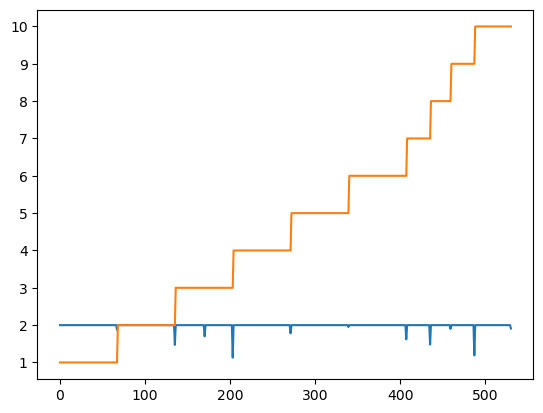

In [66]:
plt.plot(nframe/100)
plt.plot(dirid)
# plt.xlim(100,200)

In [54]:
job.get_dir_frame_idxs('7')

(40552, 43300)

In [47]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')

   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10 to export results
      Loading from /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois/info.npy
      Loading from /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois/F.npy
      Loading from /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois/spks.npy
      Loading from /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois/Fneu.npy
      Loading from /mnt/md0/runs/s3d-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10/rois/iscell.npy
      Saved stats.npy to /mnt/zeytin-f1/s3d-results/s3d-results-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10
      Saved info.npy to /mnt/zeytin-f1/s3d-results/s3d-results-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10
      Saved F.npy to /mnt/zeytin-f1/s3d-results/s3d-results-AH012_2024-08-09_1-2-3-4-5-6-7-8-9-10
      Saved spks.npy to /mnt/zeytin-f1/s3d-result

In [71]:
job.get_dir_frame_idxs('10')

(48409, 52700)